# Chapter 6: Grazing Event Detection

Machine learning algorithms for detecting grazing events from sensor data.

## Data Requirements

Place data files in a `data/` directory:
- `farm_data.xlsx` - Farm information
- `paddock_data.xlsx` - Paddock coordinates  
- `biomass_data.csv` - Biomass measurements
- Additional processed data files

## Repository

https://github.com/Stansfash/thesis-python_codes/blob/main/chapter-6-grazing-detection

## Note

File paths have been genericized. Update `data/` paths to your local data directory.


#### Libraries

In [1]:
#Import all libraries
import random
import warnings
import datetime
import math
import sys
import os
import time
import logging
import urllib.request
import os.path
import seaborn as sns
import pandas as pd
import numpy as np
import regex as re
import matplotlib.pyplot as plt
import gc
import tqdm
import sklearn
import copy


# General libraries
from matplotlib import pyplot as plt
from random import randrange,sample,randint
from sklearn.linear_model import LinearRegression
from tqdm import tqdm
from scipy import linalg
from scipy.io import loadmat
from time import time
from math import floor  
from math import exp, pi
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder,LabelEncoder,PowerTransformer, MinMaxScaler, RobustScaler
from sklearn.model_selection import KFold, cross_val_predict, train_test_split,GridSearchCV,cross_val_score, learning_curve
from sklearn.pipeline import make_pipeline
# pip install -U scikit-learn
# Used to split data into training and test data
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import(RBF, Matern, RationalQuadratic,ExpSineSquared, DotProduct,ConstantKernel, WhiteKernel)


#Sklearn Libraries
import matplotlib.style as style
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RANSACRegressor
from sklearn.linear_model import Ridge
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import SGDRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import RANSACRegressor
from sklearn.neural_network import MLPRegressor
from sklearn import tree
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.feature_selection import SelectKBest,SelectPercentile,f_classif,f_regression,mutual_info_regression,mutual_info_classif,SelectFromModel,RFE
from sklearn.svm import SVR
import xgboost as xgb
from xgboost import plot_importance
import xgboost
from xgboost import XGBRegressor
import lightgbm as lgb

from sklearn import metrics
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from IPython.display import display, HTML

# Optimisation Libaries
from scipy.optimize import LinearConstraint, minimize
from scipy.optimize import NonlinearConstraint
from scipy.optimize import minimize
from scipy.optimize import Bounds

# Optimisation libraries
# ## Optimisation for the Paper 2 - Yarranung Dataset with (NSGA II)
import csv
import re
import time
import joblib
import warnings
import numpy as np
import pandas as pd
from sklearn import metrics
from itertools import product
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import make_scorer, mean_squared_error, mean_squared_log_error, r2_score



#Visulaisation
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Set pandas options to display full column contents
pd.set_option('display.max_colwidth', None)  # Allow columns to display full width

warnings.filterwarnings('ignore')

In [3]:
import pandas as pd
# Load the Excel file
excel_file = 'farm_data.xlsx'  # Replace with your Excel file path
farm_info = pd.read_excel(excel_file)

In [6]:
import pandas as pd
# Load the Excel file
excel_file = 'paddock_data.xlsx'  # Replace with your Excel file path
paddock_information = pd.read_excel(excel_file)

In [7]:
import regex as re
# apps_biomass_data = pd.read_csv(r"data/")
# apps_pasture_quality = pd.read_csv(r"data/")
padmonitored = pd.read_excel("paddocks_monitored.xlsx")
# # Convert the 'pcode' column in padmonitored to object dtype (or string)
# padmonitored["pcode"] = padmonitored["pcode"].astype(object)
# or, if you want to enforce string type:
padmonitored["pcode"] = padmonitored["pcode"].astype(str)

# Verify the conversion
print(padmonitored["pcode"].dtype)

object


#### Load all the data in the processed data, aggregations and Modelling Folders

In [8]:
import os
import glob
import pandas as pd

def load_files_from_folders(folders, patterns):
    """
    Loads files from one or more specified folders that match any of the glob patterns provided.
    
    For each file:
      - If it is a CSV file, it is loaded with pd.read_csv.
      - If it is an Excel file (.xls or .xlsx), it is loaded with pd.read_excel.
      - If it is an SVG file, the file content is read as text.
      - For other file types, the file path is stored.
    
    Additionally, if a loaded DataFrame contains a column named "Date", it is converted to datetime.
    
    Parameters:
        folders (list): List of folder paths to search.
        patterns (list): List of glob patterns (e.g., ["*.csv", "*.xlsx", "*.svg"]).
    
    Returns:
        dict: A dictionary where keys are file identifiers (folder_basename + "_" + file base name)
              and values are:
              - For CSV/Excel: a DataFrame (with "Date" converted if present),
              - For SVG: a string (file content),
              - Otherwise: the file path.
              
    Also, each loaded file is assigned as a global variable using its base file name.
    """
    loaded_files = {}
    
    for folder in folders:
        if not os.path.isdir(folder):
            print(f"Folder '{folder}' does not exist. Skipping.")
            continue
        for pattern in patterns:
            filepaths = glob.glob(os.path.join(folder, pattern))
            for fp in filepaths:
                base_name = os.path.splitext(os.path.basename(fp))[0]
                # Construct a key by combining folder basename and file base name for dictionary storage.
                key = f"{os.path.basename(folder)}_{base_name}"
                ext = os.path.splitext(fp)[1].lower()
                try:
                    if ext == '.csv':
                        df = pd.read_csv(fp)
                        if "Date" in df.columns:
                            df["Date"] = pd.to_datetime(df["Date"], errors='coerce')
                        loaded_files[key] = df
                        # Assign global variable using the base name (overwriting if already exists).
                        _assign_global(base_name, df)
                        print(f"Loaded CSV: {key} with shape {df.shape}")
                    elif ext in ['.xls', '.xlsx']:
                        if ext == '.xlsx':
                            df = pd.read_excel(fp, engine='openpyxl')
                        else:
                            df = pd.read_excel(fp, engine='xlrd')
                        if "Date" in df.columns:
                            df["Date"] = pd.to_datetime(df["Date"], errors='coerce')
                        loaded_files[key] = df
                        _assign_global(base_name, df)
                        print(f"Loaded Excel: {key} with shape {df.shape}")
                    elif ext == '.svg':
                        with open(fp, 'r', encoding='utf-8') as f:
                            content = f.read()
                        loaded_files[key] = content
                        _assign_global(base_name, content)
                        print(f"Loaded SVG: {key}")
                    else:
                        loaded_files[key] = fp
                        _assign_global(base_name, fp)
                        print(f"Stored file path for {key} (type: {ext})")
                except Exception as e:
                    print(f"Error loading {fp}: {e}")
    return loaded_files

def _assign_global(base_name, obj):
    """
    Assigns the object `obj` to a global variable with name `base_name`.
    Unlike the previous version, this function now always uses the base name
    (overwriting any existing global variable with that name) and does not add a suffix.
    """
    globals()[base_name] = obj
    print(f"Assigned global variable: {base_name}")

# Example usage:
folders_to_load = ["processed_data", "processed_grazing_data"]
file_patterns = ["*.csv", "*.xlsx"]

loaded_files = load_files_from_folders(folders_to_load, file_patterns)

print("\nFiles loaded from specified folders:")
for name, content in loaded_files.items():
    print(f"{name}: {type(content)}")

Assigned global variable: d_model
Loaded CSV: processed_data_d_model with shape (3113, 56)
Assigned global variable: d_model_ip
Loaded CSV: processed_data_d_model_ip with shape (9608, 50)
Assigned global variable: d_model_ip_new
Loaded CSV: processed_data_d_model_ip_new with shape (9800, 50)
Assigned global variable: d_model_ip_pt
Loaded CSV: processed_data_d_model_ip_pt with shape (5460, 52)
Assigned global variable: d_model_ip_pt_new
Loaded CSV: processed_data_d_model_ip_pt_new with shape (5608, 52)
Assigned global variable: d_model_k
Loaded CSV: processed_data_d_model_k with shape (9753, 50)
Assigned global variable: d_model_mcg
Loaded CSV: processed_data_d_model_mcg with shape (9605, 50)
Assigned global variable: d_model_mq
Loaded CSV: processed_data_d_model_mq with shape (9626, 50)
Assigned global variable: d_model_new
Loaded CSV: processed_data_d_model_new with shape (3161, 56)
Assigned global variable: d_model_new_k
Loaded CSV: processed_data_d_model_new_k with shape (9955, 50)


### Block 1 and 2

In [86]:
"""
BLOCKS 1 & 2 COMBINED: Data Preparation & Paddock Selection (TEMPORAL TOLERANCE)
==================================================================================
Purpose: Load, clean, find optimal periods, augment with TEMPORAL TOLERANCE labels
Inputs: m_data_pm, data_to_model_mq, m_grazing_data (from environment)
Outputs: d_pm_new, d_mq_new, d_pm_r, d_mq_r with 60 paddocks

CRITICAL CHANGE:
- OLD: check_grazing() checks if grazing BETWEEN current and next obs (interval)
- NEW: label_with_temporal_tolerance() checks if grazing START within ±7 days (temporal)
"""

import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# ═══════════════════════════════════════════════════════════════════════════
# CONFIGURATION
# ═══════════════════════════════════════════════════════════════════════════

YEAR1_START = pd.Timestamp("2022-07-01")
YEAR1_END = pd.Timestamp("2023-06-30")
YEAR2_START = pd.Timestamp("2023-07-01")
YEAR2_END = pd.Timestamp("2024-06-30")

BIOMASS_MIN = 1000
BIOMASS_MAX = 4000
MIN_OBS_PER_PADDOCK = 5

KEEP_ALL_FARMS = True
SELECTED_FARMS = None

# NEW: Temporal tolerance configuration
TEMPORAL_TOLERANCE_DAYS = 7
MAX_EVENT_GAP_DAYS = 5

print("="*70)
print("GRAZING EVENT DETECTION - DATA PREPARATION (TEMPORAL TOLERANCE)")
print("="*70)
print(f"\nTemporal Configuration:")
print(f"  Tolerance: ±{TEMPORAL_TOLERANCE_DAYS} days")
print(f"  GPS event grouping: ≤{MAX_EVENT_GAP_DAYS} day gap")

# ═══════════════════════════════════════════════════════════════════════════
# STEP 1: LOAD AND STANDARDIZE
# ═══════════════════════════════════════════════════════════════════════════

print("\n[STEP 1] Loading and standardizing datasets...")

def standardize_dates(df):
    """Convert date columns to datetime"""
    df = df.copy()
    if 'date' in df.columns:
        df.rename(columns={'date': 'Date'}, inplace=True)
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    df = df.dropna(subset=['Date'])
    return df

m_data_pm = standardize_dates(m_data_pm)
data_to_model_mq = standardize_dates(data_to_model_mq)
m_grazing_data = standardize_dates(m_grazing_data)

print(f"  m_data_pm: {len(m_data_pm)} rows")
print(f"  data_to_model_mq: {len(data_to_model_mq)} rows")
print(f"  m_grazing_data: {len(m_grazing_data)} rows")

# ═══════════════════════════════════════════════════════════════════════════
# STEP 2: QUALITY CONTROL
# ═══════════════════════════════════════════════════════════════════════════

print("\n[STEP 2] Applying quality control...")

def quality_control(df):
    """Filter to valid biomass range"""
    df = df.dropna(subset=['remote_cover'])
    df = df[(df['remote_cover'] >= BIOMASS_MIN) & (df['remote_cover'] <= BIOMASS_MAX)]
    return df

m_data_pm = quality_control(m_data_pm)
data_to_model_mq = quality_control(data_to_model_mq)

print(f"  After QC - m_data_pm: {len(m_data_pm)} rows")
print(f"  After QC - data_to_model_mq: {len(data_to_model_mq)} rows")

# ═══════════════════════════════════════════════════════════════════════════
# STEP 3: FIND OPTIMAL GRAZING PERIODS
# ═══════════════════════════════════════════════════════════════════════════

print("\n[STEP 3] Finding optimal grazing periods...")

def find_optimal_grazing_periods(df, grazing_df, year_start, year_end, min_obs=5):
    """Find periods with sufficient grazing data for each farm-pcode"""
    df_year = df[(df['Date'] >= year_start) & (df['Date'] <= year_end)].copy()
    grazing_year = grazing_df[(grazing_df['Date'] >= year_start) & 
                               (grazing_df['Date'] <= year_end)].copy()
    
    optimal_periods = []
    
    for (farm, pcode), group in df_year.groupby(['Farm Code', 'pcode']):
        if len(group) < min_obs:
            continue
            
        grazing_events = grazing_year[
            (grazing_year['Farm Code'] == farm) & 
            (grazing_year['pcode'] == pcode)
        ]
        
        if len(grazing_events) > 0:
            period_start = max(
                group['Date'].min(), 
                grazing_events['Date'].min() - pd.Timedelta(days=30)
            )
            period_end = min(
                group['Date'].max(), 
                grazing_events['Date'].max() + pd.Timedelta(days=30)
            )
            
            period_start = max(period_start, year_start)
            period_end = min(period_end, year_end)
            
            optimal_periods.append({
                'Farm Code': farm, 
                'pcode': pcode,
                'Start': period_start, 
                'End': period_end
            })
    
    return pd.DataFrame(optimal_periods)

# KEY: Find periods from d_pm for Year 1, from d_mq for Year 2
print("  Finding periods from d_pm for Year 1...")
periods_year1 = find_optimal_grazing_periods(
    m_data_pm, m_grazing_data, YEAR1_START, YEAR1_END, MIN_OBS_PER_PADDOCK
)

print("  Finding periods from d_mq for Year 2...")
periods_year2 = find_optimal_grazing_periods(
    data_to_model_mq, m_grazing_data, YEAR2_START, YEAR2_END, MIN_OBS_PER_PADDOCK
)

print(f"  Year 1 periods: {len(periods_year1)} farm-pcode combinations")
print(f"  Year 2 periods: {len(periods_year2)} farm-pcode combinations")

# ═══════════════════════════════════════════════════════════════════════════
# STEP 4: FILTER BY PERIODS
# ═══════════════════════════════════════════════════════════════════════════

print("\n[STEP 4] Filtering datasets by optimal periods...")

def filter_by_periods(df, periods_df):
    """Filter DataFrame to optimal periods"""
    if periods_df.empty:
        return pd.DataFrame(columns=df.columns)
    
    filtered_chunks = []
    for _, period in periods_df.iterrows():
        chunk = df[
            (df['Farm Code'] == period['Farm Code']) &
            (df['pcode'] == period['pcode']) &
            (df['Date'] >= period['Start']) &
            (df['Date'] <= period['End'])
        ]
        filtered_chunks.append(chunk)
    
    return pd.concat(filtered_chunks, ignore_index=True) if filtered_chunks else pd.DataFrame(columns=df.columns)

# Apply Year 1 periods to BOTH pm and mq
pm_y1_filtered = filter_by_periods(m_data_pm, periods_year1)
mq_y1_filtered = filter_by_periods(data_to_model_mq, periods_year1)

# Apply Year 2 periods to BOTH pm and mq
pm_y2_filtered = filter_by_periods(m_data_pm, periods_year2)
mq_y2_filtered = filter_by_periods(data_to_model_mq, periods_year2)

print(f"  d_pm Year 1: {len(pm_y1_filtered)} rows")
print(f"  d_mq Year 1: {len(mq_y1_filtered)} rows")
print(f"  d_pm Year 2: {len(pm_y2_filtered)} rows")
print(f"  d_mq Year 2: {len(mq_y2_filtered)} rows")

# ═══════════════════════════════════════════════════════════════════════════
# STEP 5: GROUP GPS DATES INTO EVENTS (NEW!)
# ═══════════════════════════════════════════════════════════════════════════

print("\n[STEP 5] Grouping GPS dates into grazing events...")

def group_gps_into_events(gps_df, max_gap_days=5):
    """
    Group consecutive GPS dates into single grazing events
    Consecutive dates with ≤max_gap_days apart = one event
    """
    gps_sorted = gps_df.sort_values(['Farm Code', 'pcode', 'Date']).copy()
    
    events = []
    event_id = 0
    
    for (farm, pcode), group in gps_sorted.groupby(['Farm Code', 'pcode'], sort=False):
        dates = sorted(group['Date'].unique())
        
        if len(dates) == 0:
            continue
        
        # Start first event
        event_start = dates[0]
        event_end = dates[0]
        
        for i in range(1, len(dates)):
            current_date = dates[i]
            gap_days = (current_date - event_end).days
            
            if gap_days <= max_gap_days:
                # Continue current event
                event_end = current_date
            else:
                # Save current event and start new one
                events.append({
                    'event_id': event_id,
                    'Farm Code': farm,
                    'pcode': pcode,
                    'event_start': event_start,
                    'event_end': event_end,
                    'duration_days': (event_end - event_start).days + 1
                })
                event_id += 1
                
                # Start new event
                event_start = current_date
                event_end = current_date
        
        # Save last event
        events.append({
            'event_id': event_id,
            'Farm Code': farm,
            'pcode': pcode,
            'event_start': event_start,
            'event_end': event_end,
            'duration_days': (event_end - event_start).days + 1
        })
        event_id += 1
    
    return pd.DataFrame(events)

# Group GPS dates into events
gps_events = group_gps_into_events(m_grazing_data, max_gap_days=MAX_EVENT_GAP_DAYS)

print(f"  GPS dates: {len(m_grazing_data)}")
print(f"  Grazing events: {len(gps_events)}")
print(f"  Average duration: {gps_events['duration_days'].mean():.1f} days")

# Duration distribution
print(f"\n  Duration distribution:")
for duration in sorted(gps_events['duration_days'].unique())[:6]:
    count = (gps_events['duration_days'] == duration).sum()
    print(f"    {duration} day(s): {count:4d} events")
if (gps_events['duration_days'] > 6).any():
    count_7plus = (gps_events['duration_days'] > 6).sum()
    print(f"    7+ days:  {count_7plus:4d} events")

# ═══════════════════════════════════════════════════════════════════════════
# STEP 6: AUGMENT WITH TEMPORAL AND BIOMASS FEATURES
# ═══════════════════════════════════════════════════════════════════════════

print("\n[STEP 6] Augmenting with temporal and biomass features...")

def augment_with_features(df):
    """Add temporal features and biomass changes (NO labeling yet)"""
    df = df.copy()
    df = df.sort_values(['Farm Code', 'pcode', 'Date']).reset_index(drop=True)
    
    # Next observation columns
    df['next_Date'] = df.groupby(['Farm Code', 'pcode'])['Date'].shift(-1)
    df['next_remote_cover'] = df.groupby(['Farm Code', 'pcode'])['remote_cover'].shift(-1)
    
    # Time intervals
    df['days_interval'] = (df['next_Date'] - df['Date']).dt.days
    
    # Biomass change
    df['biomass_change'] = df['next_remote_cover'] - df['remote_cover']
    
    # Corrected disappearance rate (positive = loss)
    df['disappearance_rate'] = df.apply(
        lambda row: max(0, -row['biomass_change']) / row['days_interval'] 
        if pd.notna(row['days_interval']) and row['days_interval'] > 0 
        else 0, 
        axis=1
    )
    
    return df

# Add features to all 4 datasets
d_pm_new = augment_with_features(pm_y1_filtered.dropna(subset=['remote_cover']))
d_mq_new = augment_with_features(mq_y1_filtered.dropna(subset=['remote_cover']))
d_pm_r = augment_with_features(pm_y2_filtered.dropna(subset=['remote_cover']))
d_mq_r = augment_with_features(mq_y2_filtered.dropna(subset=['remote_cover']))

print("  ✓ Temporal and biomass features added")

# ═══════════════════════════════════════════════════════════════════════════
# STEP 7: ADD TEMPORAL TOLERANCE LABELS (NEW!)
# ═══════════════════════════════════════════════════════════════════════════

print("\n[STEP 7] Adding temporal tolerance grazing labels...")

def add_temporal_grazing_labels(obs_df, events_df, tolerance_days=7):
    """
    Label observations based on proximity to GPS event START dates
    Label = 1 if any event START within ±tolerance_days
    Label = 0 otherwise
    """
    df = obs_df.copy()
    df['temporal_grazing_label'] = 0  # Default: no grazing
    
    labeled_count = 0
    
    # For each observation
    for idx, obs_row in df.iterrows():
        obs_date = obs_row['Date']
        farm = obs_row['Farm Code']
        pcode = obs_row['pcode']
        
        # Find GPS events in same paddock
        paddock_events = events_df[
            (events_df['Farm Code'] == farm) &
            (events_df['pcode'] == pcode)
        ]
        
        # Check distance to each event START
        for _, event in paddock_events.iterrows():
            event_start = event['event_start']
            days_diff = abs((obs_date - event_start).days)
            
            if days_diff <= tolerance_days:
                df.loc[idx, 'temporal_grazing_label'] = 1
                labeled_count += 1
                break  # Found a nearby event
    
    grazing_rate = df['temporal_grazing_label'].mean()
    return df, labeled_count, grazing_rate

# Add labels to all 4 datasets
print("  [1/4] Labeling d_pm_new...")
d_pm_new, pm_new_count, pm_new_rate = add_temporal_grazing_labels(
    d_pm_new, gps_events, TEMPORAL_TOLERANCE_DAYS
)

print("  [2/4] Labeling d_mq_new...")
d_mq_new, mq_new_count, mq_new_rate = add_temporal_grazing_labels(
    d_mq_new, gps_events, TEMPORAL_TOLERANCE_DAYS
)

print("  [3/4] Labeling d_pm_r...")
d_pm_r, pm_r_count, pm_r_rate = add_temporal_grazing_labels(
    d_pm_r, gps_events, TEMPORAL_TOLERANCE_DAYS
)

print("  [4/4] Labeling d_mq_r...")
d_mq_r, mq_r_count, mq_r_rate = add_temporal_grazing_labels(
    d_mq_r, gps_events, TEMPORAL_TOLERANCE_DAYS
)

print(f"\n  Labeling Summary:")
print(f"    d_pm_new: {pm_new_count} grazing obs ({pm_new_rate:.1%} rate)")
print(f"    d_mq_new: {mq_new_count} grazing obs ({mq_new_rate:.1%} rate)")
print(f"    d_pm_r:   {pm_r_count} grazing obs ({pm_r_rate:.1%} rate)")
print(f"    d_mq_r:   {mq_r_count} grazing obs ({mq_r_rate:.1%} rate)")

# ═══════════════════════════════════════════════════════════════════════════
# STEP 8: ADD LEGACY LABELS FOR BACKWARD COMPATIBILITY (OPTIONAL)
# ═══════════════════════════════════════════════════════════════════════════

print("\n[STEP 8] Adding legacy interval-based labels for comparison...")

def add_legacy_labels(df, grazing_df):
    """Add OLD interval-based labels (was_grazed, adjusted_grazing)"""
    df = df.copy()
    
    # Check grazing (OLD way - interval based)
    def check_grazing(row):
        if pd.isna(row['next_Date']):
            return 'No'
        
        grazing_mask = (
            (grazing_df['Farm Code'] == row['Farm Code']) &
            (grazing_df['pcode'] == row['pcode']) &
            (grazing_df['Date'] > row['Date']) &
            (grazing_df['Date'] <= row['next_Date'])
        )
        return 'Yes' if grazing_mask.any() else 'No'
    
    df['was_grazed'] = df.apply(check_grazing, axis=1)
    
    # Adjusted grazing
    df['adjusted_grazing'] = df.apply(
        lambda r: 'No' if (r['biomass_change'] > 0 and r['was_grazed'] == 'Yes') 
        else r['was_grazed'], 
        axis=1
    )
    
    return df

# Add legacy labels
d_pm_new = add_legacy_labels(d_pm_new, m_grazing_data)
d_mq_new = add_legacy_labels(d_mq_new, m_grazing_data)
d_pm_r = add_legacy_labels(d_pm_r, m_grazing_data)
d_mq_r = add_legacy_labels(d_mq_r, m_grazing_data)

print("  ✓ Legacy labels added (was_grazed, adjusted_grazing) for comparison")

# ═══════════════════════════════════════════════════════════════════════════
# STEP 9: FIND COMMON PADDOCKS ACROSS ALL 4 DATASETS
# ═══════════════════════════════════════════════════════════════════════════

print("\n[STEP 9] Finding common paddocks across all 4 augmented datasets...")

# Get farm-pcode combinations from each
paddocks_pm_new = set(d_pm_new.groupby(['Farm Code', 'pcode']).groups.keys())
paddocks_mq_new = set(d_mq_new.groupby(['Farm Code', 'pcode']).groups.keys())
paddocks_pm_r = set(d_pm_r.groupby(['Farm Code', 'pcode']).groups.keys())
paddocks_mq_r = set(d_mq_r.groupby(['Farm Code', 'pcode']).groups.keys())

print(f"  d_pm_new: {len(paddocks_pm_new)} paddocks")
print(f"  d_mq_new: {len(paddocks_mq_new)} paddocks")
print(f"  d_pm_r: {len(paddocks_pm_r)} paddocks")
print(f"  d_mq_r: {len(paddocks_mq_r)} paddocks")

# Find intersection
common_paddocks_tuples = paddocks_pm_new & paddocks_mq_new & paddocks_pm_r & paddocks_mq_r
common_paddocks = pd.DataFrame(list(common_paddocks_tuples), columns=['Farm Code', 'pcode'])

print(f"  Common paddocks: {len(common_paddocks)}")

# Farm selection filter
if not KEEP_ALL_FARMS and SELECTED_FARMS is not None:
    common_paddocks = common_paddocks[common_paddocks['Farm Code'].isin(SELECTED_FARMS)]

# Summary by farm
farm_counts = common_paddocks.groupby('Farm Code').size().sort_values(ascending=False)
print(f"\n  Paddocks per farm:")
for farm, count in farm_counts.items():
    print(f"    {farm}: {count} paddocks")

print(f"\n  TOTAL: {len(common_paddocks['Farm Code'].unique())} farms, {len(common_paddocks)} paddocks")

# ═══════════════════════════════════════════════════════════════════════════
# STEP 10: FILTER TO COMMON PADDOCKS
# ═══════════════════════════════════════════════════════════════════════════

print("\n[STEP 10] Filtering to common paddocks...")

def filter_to_common(df, common_df):
    """Keep only common farm-paddock combinations"""
    return df.merge(common_df, on=['Farm Code', 'pcode'], how='inner')

d_pm_new = filter_to_common(d_pm_new, common_paddocks)
d_mq_new = filter_to_common(d_mq_new, common_paddocks)
d_pm_r = filter_to_common(d_pm_r, common_paddocks)
d_mq_r = filter_to_common(d_mq_r, common_paddocks)

# Filter grazing data
grazing_y1 = m_grazing_data[
    (m_grazing_data['Date'] >= YEAR1_START) & 
    (m_grazing_data['Date'] <= YEAR1_END)
].merge(common_paddocks, on=['Farm Code', 'pcode'], how='inner')

grazing_y2 = m_grazing_data[
    (m_grazing_data['Date'] >= YEAR2_START) & 
    (m_grazing_data['Date'] <= YEAR2_END)
].merge(common_paddocks, on=['Farm Code', 'pcode'], how='inner')

print(f"\n  Final datasets:")
print(f"    d_pm_new:   {len(d_pm_new):>5} rows, {d_pm_new.groupby(['Farm Code', 'pcode']).ngroups} paddocks")
print(f"    d_mq_new:   {len(d_mq_new):>5} rows, {d_mq_new.groupby(['Farm Code', 'pcode']).ngroups} paddocks")
print(f"    d_pm_r:     {len(d_pm_r):>5} rows, {d_pm_r.groupby(['Farm Code', 'pcode']).ngroups} paddocks")
print(f"    d_mq_r:     {len(d_mq_r):>5} rows, {d_mq_r.groupby(['Farm Code', 'pcode']).ngroups} paddocks")
print(f"    grazing_y1: {len(grazing_y1):>5} events")
print(f"    grazing_y2: {len(grazing_y2):>5} events")

# ═══════════════════════════════════════════════════════════════════════════
# OUTPUTS
# ═══════════════════════════════════════════════════════════════════════════

print("\n" + "="*70)
print("BLOCKS 1 & 2 COMPLETE (TEMPORAL TOLERANCE VERSION)")
print("="*70)
print("Datasets with features and labels:")
print("  - d_pm_new, d_pm_r (Plate meter)")
print("  - d_mq_new, d_mq_r (Interpolated)")
print("  - grazing_y1, grazing_y2 (GPS records)")
print("  - common_paddocks (metadata)")
print("  - gps_events (grouped GPS events)")
print("\nColumns added:")
print("  - next_Date, next_remote_cover, days_interval")
print("  - biomass_change, disappearance_rate")
print("  - temporal_grazing_label (NEW! 1=grazing within ±7 days, 0=no grazing)")
print("  - was_grazed, adjusted_grazing (legacy interval-based labels)")
print("\nKey Change:")
print(f"  TARGET for modeling: temporal_grazing_label")
print(f"  Labeling logic: GPS event START within ±{TEMPORAL_TOLERANCE_DAYS} days")
print(f"  GPS events: {len(gps_events)} (from {len(m_grazing_data)} GPS dates)")
print("\nNext: Block 3 - Feature engineering with temporal_grazing_label")
print("="*70)

GRAZING EVENT DETECTION - DATA PREPARATION (TEMPORAL TOLERANCE)

Temporal Configuration:
  Tolerance: ±7 days
  GPS event grouping: ≤5 day gap

[STEP 1] Loading and standardizing datasets...
  m_data_pm: 4750 rows
  data_to_model_mq: 11504 rows
  m_grazing_data: 6269 rows

[STEP 2] Applying quality control...
  After QC - m_data_pm: 4750 rows
  After QC - data_to_model_mq: 11504 rows

[STEP 3] Finding optimal grazing periods...
  Finding periods from d_pm for Year 1...
  Finding periods from d_mq for Year 2...
  Year 1 periods: 70 farm-pcode combinations
  Year 2 periods: 72 farm-pcode combinations

[STEP 4] Filtering datasets by optimal periods...
  d_pm Year 1: 2395 rows
  d_mq Year 1: 4864 rows
  d_pm Year 2: 1103 rows
  d_mq Year 2: 3787 rows

[STEP 5] Grouping GPS dates into grazing events...
  GPS dates: 6269
  Grazing events: 2457
  Average duration: 2.7 days

  Duration distribution:
    1 day(s):  822 events
    2 day(s):  754 events
    3 day(s):  363 events
    4 day(s):  20

### Block 3

In [87]:
"""
BLOCK 3: FEATURE ENGINEERING (TEMPORAL TOLERANCE VERSION)
==========================================================
Purpose: Add temporal features and prepare data for modeling
Inputs: d_pm_new, d_mq_new, d_pm_r, d_mq_r (from Block 1-2 with temporal_grazing_label)
Outputs: Same datasets with additional engineered features

CRITICAL: Uses temporal_grazing_label as TARGET (not adjusted_grazing_binary)
"""

import pandas as pd
import numpy as np

print("="*70)
print("BLOCK 3: FEATURE ENGINEERING (TEMPORAL TOLERANCE)")
print("="*70)

# ═══════════════════════════════════════════════════════════════════════════
# STEP 1: VERIFY INPUT DATA
# ═══════════════════════════════════════════════════════════════════════════

print("\n[STEP 1] Verifying input datasets from Block 1-2...")

# Check that datasets exist in environment
try:
    datasets = {
        'd_pm_new': d_pm_new,
        'd_mq_new': d_mq_new,
        'd_pm_r': d_pm_r,
        'd_mq_r': d_mq_r
    }
    
    print(f"  Found {len(datasets)} datasets:")
    for name, df in datasets.items():
        print(f"    {name}: {len(df)} rows, {df.groupby(['Farm Code', 'pcode']).ngroups} paddocks")
    
    # Verify temporal_grazing_label exists
    for name, df in datasets.items():
        if 'temporal_grazing_label' not in df.columns:
            raise ValueError(f"{name} missing 'temporal_grazing_label' column!")
    
    print("\n  ✓ All datasets have 'temporal_grazing_label' column")
    
except NameError as e:
    print(f"\n  ✗ ERROR: {e}")
    print("  Please run Block 1-2 first!")
    raise

# ═══════════════════════════════════════════════════════════════════════════
# STEP 2: ADD TEMPORAL FEATURES
# ═══════════════════════════════════════════════════════════════════════════

print("\n[STEP 2] Adding temporal features...")

def add_temporal_features(df):
    """Add day of year, week, month, season features"""
    df = df.copy()
    
    # Extract temporal components
    df['day_of_year'] = df['Date'].dt.dayofyear
    df['week_of_year'] = df['Date'].dt.isocalendar().week
    df['Week'] = df['Date'].dt.isocalendar().week
    df['Month'] = df['Date'].dt.month
    df['Year'] = df['Date'].dt.year
    
    # Season mapping (Southern Hemisphere - Australia)
    df['Season'] = df['Month'].map({
        12: 'Summer', 1: 'Summer', 2: 'Summer',
        3: 'Autumn', 4: 'Autumn', 5: 'Autumn',
        6: 'Winter', 7: 'Winter', 8: 'Winter',
        9: 'Spring', 10: 'Spring', 11: 'Spring'
    })
    
    return df

d_pm_new = add_temporal_features(d_pm_new)
d_mq_new = add_temporal_features(d_mq_new)
d_pm_r = add_temporal_features(d_pm_r)
d_mq_r = add_temporal_features(d_mq_r)

print("  ✓ Added: day_of_year, week_of_year, Week, Month, Year, Season")

# ═══════════════════════════════════════════════════════════════════════════
# STEP 3: ADD DERIVED BIOMASS FEATURES
# ═══════════════════════════════════════════════════════════════════════════

print("\n[STEP 3] Verifying derived biomass features...")

# These should already exist from Block 1-2, but verify
required_features = [
    'next_Date', 'next_remote_cover', 'days_interval',
    'biomass_change', 'disappearance_rate'
]

for name, df in [('d_pm_new', d_pm_new), ('d_mq_new', d_mq_new), 
                 ('d_pm_r', d_pm_r), ('d_mq_r', d_mq_r)]:
    missing = [f for f in required_features if f not in df.columns]
    if missing:
        print(f"  ⚠ {name} missing: {missing}")
    else:
        print(f"  ✓ {name}: All biomass features present")

# Add absolute biomass change if not present
def add_abs_change(df):
    """Add absolute biomass change"""
    if 'biomass_change_abs' not in df.columns:
        df['biomass_change_abs'] = df['biomass_change'].abs()
    return df

d_pm_new = add_abs_change(d_pm_new)
d_mq_new = add_abs_change(d_mq_new)
d_pm_r = add_abs_change(d_pm_r)
d_mq_r = add_abs_change(d_mq_r)

print("  ✓ Added: biomass_change_abs")

# Add rate per day if not present
def add_rate_per_day(df):
    """Add rate per day"""
    if 'rate_per_day' not in df.columns:
        df['rate_per_day'] = df['disappearance_rate'].abs()
    return df

d_pm_new = add_rate_per_day(d_pm_new)
d_mq_new = add_rate_per_day(d_mq_new)
d_pm_r = add_rate_per_day(d_pm_r)
d_mq_r = add_rate_per_day(d_mq_r)

print("  ✓ Added: rate_per_day")

# ═══════════════════════════════════════════════════════════════════════════
# STEP 4: DEFINE FEATURE GROUPS
# ═══════════════════════════════════════════════════════════════════════════

print("\n[STEP 4] Defining feature groups...")

# Base biomass features
biomass_features = ['remote_cover', 'next_remote_cover']

# Temporal features
temporal_features = ['day_of_year', 'week_of_year', 'Week', 'Month', 'Season', 'Year']

# Derived features
derived_features = ['days_interval', 'biomass_change', 'biomass_change_abs', 
                    'disappearance_rate', 'rate_per_day']

# Target variable (NEW!)
target_feature = 'temporal_grazing_label'

# Spatial features
spatial_features = ['Region'] if 'Region' in d_pm_new.columns else []

print(f"\n  Feature groups:")
print(f"    Biomass features: {len(biomass_features)}")
print(f"    Temporal features: {len(temporal_features)}")
print(f"    Derived features: {len(derived_features)}")
print(f"    Spatial features: {len(spatial_features)}")
print(f"    Target: {target_feature}")

all_features = biomass_features + temporal_features + derived_features
if spatial_features:
    all_features += spatial_features

print(f"\n  Total features: {len(all_features)}")

# ═══════════════════════════════════════════════════════════════════════════
# STEP 5: DATA QUALITY CHECKS
# ═══════════════════════════════════════════════════════════════════════════

print("\n[STEP 5] Data quality checks...")

def check_data_quality(df, name):
    """Check for missing values and data quality issues"""
    print(f"\n  {name}:")
    print(f"    Total rows: {len(df)}")
    print(f"    Paddocks: {df.groupby(['Farm Code', 'pcode']).ngroups}")
    
    # Target distribution
    if target_feature in df.columns:
        grazing_count = df[target_feature].sum()
        grazing_rate = df[target_feature].mean()
        print(f"    Grazing observations: {grazing_count} ({grazing_rate:.1%})")
        print(f"    Non-grazing observations: {len(df) - grazing_count}")
    
    # Check for missing values in key features
    key_features = ['remote_cover', target_feature, 'days_interval']
    missing = df[key_features].isnull().sum()
    
    if missing.any():
        print(f"    Missing values:")
        for feat in missing[missing > 0].index:
            print(f"      {feat}: {missing[feat]} ({missing[feat]/len(df)*100:.1f}%)")
    else:
        print(f"    ✓ No missing values in key features")
    
    # Check for infinite values
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    inf_cols = [col for col in numeric_cols if np.isinf(df[col]).any()]
    
    if inf_cols:
        print(f"    ⚠ Infinite values in: {inf_cols}")
    else:
        print(f"    ✓ No infinite values")
    
    # Check temporal_grazing_label values
    if target_feature in df.columns:
        unique_labels = sorted(df[target_feature].unique())
        print(f"    Unique target values: {unique_labels}")
        if set(unique_labels) != {0, 1}:
            print(f"    ⚠ WARNING: Expected [0, 1], got {unique_labels}")

check_data_quality(d_pm_new, "d_pm_new (PM Year 1)")
check_data_quality(d_mq_new, "d_mq_new (MQ Year 1)")
check_data_quality(d_pm_r, "d_pm_r (PM Year 2)")
check_data_quality(d_mq_r, "d_mq_r (MQ Year 2)")

# ═══════════════════════════════════════════════════════════════════════════
# STEP 6: REMOVE INCOMPLETE OBSERVATIONS
# ═══════════════════════════════════════════════════════════════════════════

print("\n[STEP 6] Removing incomplete observations...")

def remove_incomplete(df, name):
    """Remove observations without next observation (last obs per paddock)"""
    before = len(df)
    df_clean = df.dropna(subset=['next_Date', 'next_remote_cover']).copy()
    after = len(df_clean)
    removed = before - after
    
    print(f"  {name}:")
    print(f"    Before: {before} observations")
    print(f"    After:  {after} observations")
    print(f"    Removed: {removed} incomplete observations")
    
    return df_clean

d_pm_new = remove_incomplete(d_pm_new, "d_pm_new")
d_mq_new = remove_incomplete(d_mq_new, "d_mq_new")
d_pm_r = remove_incomplete(d_pm_r, "d_pm_r")
d_mq_r = remove_incomplete(d_mq_r, "d_mq_r")

# ═══════════════════════════════════════════════════════════════════════════
# STEP 7: SUMMARY STATISTICS
# ═══════════════════════════════════════════════════════════════════════════

print("\n[STEP 7] Summary statistics...")

def print_summary(df, name):
    """Print summary statistics"""
    print(f"\n  {name}:")
    print(f"    Observations: {len(df)}")
    print(f"    Paddocks: {df.groupby(['Farm Code', 'pcode']).ngroups}")
    print(f"    Farms: {df['Farm Code'].nunique()}")
    print(f"    Date range: {df['Date'].min().date()} to {df['Date'].max().date()}")
    
    # Target distribution
    grazing_rate = df[target_feature].mean()
    print(f"    Grazing rate: {grazing_rate:.1%}")
    
    # Biomass stats
    print(f"    Biomass (kg/ha):")
    print(f"      Mean: {df['remote_cover'].mean():.0f}")
    print(f"      Std:  {df['remote_cover'].std():.0f}")
    print(f"      Min:  {df['remote_cover'].min():.0f}")
    print(f"      Max:  {df['remote_cover'].max():.0f}")

print_summary(d_pm_new, "d_pm_new (PM Year 1)")
print_summary(d_mq_new, "d_mq_new (MQ Year 1)")
print_summary(d_pm_r, "d_pm_r (PM Year 2)")
print_summary(d_mq_r, "d_mq_r (MQ Year 2)")

# ═══════════════════════════════════════════════════════════════════════════
# OUTPUTS
# ═══════════════════════════════════════════════════════════════════════════

print("\n" + "="*70)
print("BLOCK 3 FEATURE ENGINEERING COMPLETE")
print("="*70)

print("\n✓ Features Ready:")
print(f"    Biomass: {biomass_features}")
print(f"    Temporal: {temporal_features}")
print(f"    Derived: {derived_features}")
if spatial_features:
    print(f"    Spatial: {spatial_features}")

print(f"\n✓ Target Variable: {target_feature}")
print(f"    1 = GPS grazing event START within ±7 days")
print(f"    0 = No GPS grazing event within ±7 days")

# Overall statistics
total_obs = len(d_pm_new) + len(d_mq_new) + len(d_pm_r) + len(d_mq_r)
total_grazing = (d_pm_new[target_feature].sum() + 
                 d_mq_new[target_feature].sum() +
                 d_pm_r[target_feature].sum() + 
                 d_mq_r[target_feature].sum())

print(f"\n✓ Overall Statistics:")
print(f"    Total observations: {total_obs}")
print(f"    Grazing observations: {total_grazing}")
print(f"    Overall grazing rate: {total_grazing/total_obs:.1%}")

print("\n✓ Datasets ready in environment:")
print("    - d_pm_new, d_mq_new (Year 1)")
print("    - d_pm_r, d_mq_r (Year 2)")

print("\n✓ Next Step:")
print("    Run Block 4 (Train/Test Splits)")
print("    TARGET_COL = 'temporal_grazing_label'")

print("\n" + "="*70)

BLOCK 3: FEATURE ENGINEERING (TEMPORAL TOLERANCE)

[STEP 1] Verifying input datasets from Block 1-2...
  Found 4 datasets:
    d_pm_new: 2135 rows, 60 paddocks
    d_mq_new: 4264 rows, 60 paddocks
    d_pm_r: 931 rows, 60 paddocks
    d_mq_r: 3247 rows, 60 paddocks

  ✓ All datasets have 'temporal_grazing_label' column

[STEP 2] Adding temporal features...
  ✓ Added: day_of_year, week_of_year, Week, Month, Year, Season

[STEP 3] Verifying derived biomass features...
  ✓ d_pm_new: All biomass features present
  ✓ d_mq_new: All biomass features present
  ✓ d_pm_r: All biomass features present
  ✓ d_mq_r: All biomass features present
  ✓ Added: biomass_change_abs
  ✓ Added: rate_per_day

[STEP 4] Defining feature groups...

  Feature groups:
    Biomass features: 2
    Temporal features: 6
    Derived features: 5
    Spatial features: 1
    Target: temporal_grazing_label

  Total features: 14

[STEP 5] Data quality checks...

  d_pm_new (PM Year 1):
    Total rows: 2135
    Paddocks: 60
 

### Block 4

In [88]:
"""
BLOCK 4: TRAIN/TEST SPLITS (TEMPORAL TOLERANCE VERSION)
========================================================
Purpose: Create train/test splits for modeling
Inputs: d_pm_new, d_mq_new, d_pm_r, d_mq_r (from Block 3)
Outputs: Train/test splits in environment

CRITICAL: TARGET_COL = 'temporal_grazing_label'
"""

import pandas as pd
import numpy as np

print("="*70)
print("BLOCK 4: TRAIN/TEST SPLITS (TEMPORAL TOLERANCE)")
print("="*70)

# ═══════════════════════════════════════════════════════════════════════════
# CONFIGURATION
# ═══════════════════════════════════════════════════════════════════════════

# CRITICAL: Target column for modeling
TARGET_COL = 'temporal_grazing_label'

# Feature groups
BIOMASS_FEATURES = ['remote_cover', 'next_remote_cover']
TEMPORAL_FEATURES = ['day_of_year', 'week_of_year', 'Week', 'Month', 'Season', 'Year']
DERIVED_FEATURES = ['days_interval', 'biomass_change', 'biomass_change_abs', 
                    'disappearance_rate', 'rate_per_day']

# All modeling features (before encoding)
ALL_FEATURES = BIOMASS_FEATURES + TEMPORAL_FEATURES + DERIVED_FEATURES

print(f"\nConfiguration:")
print(f"  TARGET_COL: {TARGET_COL}")
print(f"  Features: {len(ALL_FEATURES)}")
print(f"    - Biomass: {len(BIOMASS_FEATURES)}")
print(f"    - Temporal: {len(TEMPORAL_FEATURES)}")
print(f"    - Derived: {len(DERIVED_FEATURES)}")

# ═══════════════════════════════════════════════════════════════════════════
# STEP 1: VERIFY INPUT DATA
# ═══════════════════════════════════════════════════════════════════════════

print("\n[STEP 1] Verifying input datasets from Block 3...")

# Check that datasets exist
try:
    datasets_check = [
        ('d_pm_new', d_pm_new),
        ('d_mq_new', d_mq_new),
        ('d_pm_r', d_pm_r),
        ('d_mq_r', d_mq_r)
    ]
    
    print(f"  Found {len(datasets_check)} datasets:")
    for name, df in datasets_check:
        print(f"    {name}: {len(df)} rows")
        
        # Verify TARGET_COL exists
        if TARGET_COL not in df.columns:
            raise ValueError(f"{name} missing target column: {TARGET_COL}")
    
    print(f"\n  ✓ All datasets have target column: {TARGET_COL}")
    
except NameError as e:
    print(f"\n  ✗ ERROR: {e}")
    print("  Please run Blocks 1-3 first!")
    raise

# ═══════════════════════════════════════════════════════════════════════════
# STEP 2: ENCODE CATEGORICAL FEATURES
# ═══════════════════════════════════════════════════════════════════════════

print("\n[STEP 2] Encoding categorical features...")

def encode_season(df):
    """One-hot encode Season feature"""
    df = df.copy()
    
    if 'Season' in df.columns:
        season_dummies = pd.get_dummies(df['Season'], prefix='Season')
        df = pd.concat([df, season_dummies], axis=1)
        
        # Drop original Season column
        df = df.drop('Season', axis=1)
        
        return df, list(season_dummies.columns)
    else:
        return df, []

print("  Encoding 'Season' feature...")

d_pm_new, season_cols = encode_season(d_pm_new)
d_mq_new, _ = encode_season(d_mq_new)
d_pm_r, _ = encode_season(d_pm_r)
d_mq_r, _ = encode_season(d_mq_r)

# Update feature list
ALL_FEATURES_ENCODED = [f for f in ALL_FEATURES if f != 'Season'] + season_cols

print(f"  ✓ Season encoded into {len(season_cols)} dummy variables: {season_cols}")
print(f"  ✓ Total features: {len(ALL_FEATURES_ENCODED)}")

# ═══════════════════════════════════════════════════════════════════════════
# STEP 3: CREATE TRAIN/TEST SPLITS
# ═══════════════════════════════════════════════════════════════════════════

print("\n[STEP 3] Creating train/test splits...")

print("\n  Split Strategy:")
print("    Within-Year Splits:")
print("      - PM: Train=Year1, Test=Year1")
print("      - MQ: Train=Year1, Test=Year1")
print("    Cross-Year Splits:")
print("      - PM: Train=Year1, Test=Year2")
print("      - MQ: Train=Year1, Test=Year2")

# PM Within-Year (Year 1 for both train and test)
pm_within_train = d_pm_new.copy()
pm_within_test = d_pm_new.copy()

# PM Cross-Year (Year 1 train, Year 2 test)
pm_cross_train = d_pm_new.copy()
pm_cross_test = d_pm_r.copy()

# MQ Within-Year (Year 1 for both train and test)
mq_within_train = d_mq_new.copy()
mq_within_test = d_mq_new.copy()

# MQ Cross-Year (Year 1 train, Year 2 test)
mq_cross_train = d_mq_new.copy()
mq_cross_test = d_mq_r.copy()

print("\n  ✓ Splits created")

# ═══════════════════════════════════════════════════════════════════════════
# STEP 4: VERIFY SPLITS
# ═══════════════════════════════════════════════════════════════════════════

print("\n[STEP 4] Verifying train/test splits...")

def print_split_info(train, test, name):
    """Print information about train/test split"""
    train_pos = train[TARGET_COL].sum()
    train_neg = (train[TARGET_COL] == 0).sum()
    test_pos = test[TARGET_COL].sum()
    test_neg = (test[TARGET_COL] == 0).sum()
    
    print(f"\n  {name}:")
    print(f"    Train: {len(train):>5} obs ({train_pos:>4} grazing, {train_neg:>4} non-grazing)")
    print(f"           Grazing rate: {train[TARGET_COL].mean():>5.1%}")
    print(f"           Paddocks: {train.groupby(['Farm Code', 'pcode']).ngroups}")
    
    print(f"    Test:  {len(test):>5} obs ({test_pos:>4} grazing, {test_neg:>4} non-grazing)")
    print(f"           Grazing rate: {test[TARGET_COL].mean():>5.1%}")
    print(f"           Paddocks: {test.groupby(['Farm Code', 'pcode']).ngroups}")
    
    # Verify feature presence
    missing_train = [f for f in ALL_FEATURES_ENCODED if f not in train.columns]
    missing_test = [f for f in ALL_FEATURES_ENCODED if f not in test.columns]
    
    if missing_train or missing_test:
        print(f"    ⚠ Missing features detected!")
        if missing_train:
            print(f"      Train missing: {missing_train}")
        if missing_test:
            print(f"      Test missing: {missing_test}")
    else:
        print(f"    ✓ All {len(ALL_FEATURES_ENCODED)} features present")

print_split_info(pm_within_train, pm_within_test, "PM Within-Year")
print_split_info(pm_cross_train, pm_cross_test, "PM Cross-Year")
print_split_info(mq_within_train, mq_within_test, "MQ Within-Year")
print_split_info(mq_cross_train, mq_cross_test, "MQ Cross-Year")

# ═══════════════════════════════════════════════════════════════════════════
# STEP 5: FEATURE VERIFICATION
# ═══════════════════════════════════════════════════════════════════════════

print("\n[STEP 5] Feature verification...")

# Check for missing or infinite values in features
def check_feature_quality(df, name):
    """Check feature quality"""
    feature_cols = [f for f in ALL_FEATURES_ENCODED if f in df.columns]
    
    missing = df[feature_cols].isnull().sum()
    if missing.any():
        print(f"\n  {name}:")
        print(f"    Missing values in features:")
        for feat in missing[missing > 0].index:
            print(f"      {feat}: {missing[feat]} ({missing[feat]/len(df)*100:.1f}%)")
    
    inf_cols = [col for col in feature_cols if np.isinf(df[col]).any()]
    if inf_cols:
        print(f"\n  {name}:")
        print(f"    Infinite values in: {inf_cols}")

print("  Checking feature quality across all splits...")

for name, df in [
    ('pm_within_train', pm_within_train),
    ('pm_cross_train', pm_cross_train),
    ('mq_within_train', mq_within_train),
    ('mq_cross_train', mq_cross_train)
]:
    check_feature_quality(df, name)

print("\n  ✓ Feature quality checks complete")

# ═══════════════════════════════════════════════════════════════════════════
# OUTPUTS
# ═══════════════════════════════════════════════════════════════════════════

print("\n" + "="*70)
print("BLOCK 4 TRAIN/TEST SPLITS COMPLETE")
print("="*70)

print(f"\n✓ Target Variable: {TARGET_COL}")
print("    1 = Grazing within ±7 days of observation")
print("    0 = No grazing within ±7 days of observation")

print(f"\n✓ Features: {len(ALL_FEATURES_ENCODED)} total")
print(f"    - Biomass: {len(BIOMASS_FEATURES)}")
print(f"    - Temporal: {len(TEMPORAL_FEATURES) - 1} (Season encoded)")
print(f"    - Season dummies: {len(season_cols)}")
print(f"    - Derived: {len(DERIVED_FEATURES)}")

print("\n✓ Train/Test Splits Available in Environment:")
print("    PM Within-Year:")
print("      - pm_within_train")
print("      - pm_within_test")
print("    PM Cross-Year:")
print("      - pm_cross_train")
print("      - pm_cross_test")
print("    MQ Within-Year:")
print("      - mq_within_train")
print("      - mq_within_test")
print("    MQ Cross-Year:")
print("      - mq_cross_train")
print("      - mq_cross_test")

print("\n✓ Configuration Variables Available:")
print(f"    - TARGET_COL = '{TARGET_COL}'")
print(f"    - ALL_FEATURES_ENCODED (list of {len(ALL_FEATURES_ENCODED)} features)")
print(f"    - BIOMASS_FEATURES, TEMPORAL_FEATURES, DERIVED_FEATURES")

print("\n✓ Next Steps:")
print("    - Run Block 5 (Threshold Models) with TARGET_COL")
print("    - Run Blocks 6-9 (ML Models)")
print("    - Run Blocks 10-12 (Validation & Figures)")

print("\n" + "="*70)

BLOCK 4: TRAIN/TEST SPLITS (TEMPORAL TOLERANCE)

Configuration:
  TARGET_COL: temporal_grazing_label
  Features: 13
    - Biomass: 2
    - Temporal: 6
    - Derived: 5

[STEP 1] Verifying input datasets from Block 3...
  Found 4 datasets:
    d_pm_new: 2075 rows
    d_mq_new: 4204 rows
    d_pm_r: 871 rows
    d_mq_r: 3187 rows

  ✓ All datasets have target column: temporal_grazing_label

[STEP 2] Encoding categorical features...
  Encoding 'Season' feature...
  ✓ Season encoded into 4 dummy variables: ['Season_Autumn', 'Season_Spring', 'Season_Summer', 'Season_Winter']
  ✓ Total features: 16

[STEP 3] Creating train/test splits...

  Split Strategy:
    Within-Year Splits:
      - PM: Train=Year1, Test=Year1
      - MQ: Train=Year1, Test=Year1
    Cross-Year Splits:
      - PM: Train=Year1, Test=Year2
      - MQ: Train=Year1, Test=Year2

  ✓ Splits created

[STEP 4] Verifying train/test splits...

  PM Within-Year:
    Train:  2075 obs (1064 grazing, 1011 non-grazing)
           Grazi

### Block 5

In [90]:
"""
BLOCK 5: THRESHOLD-BASED MODELS (TEMPORAL TOLERANCE VERSION)
=============================================================
Purpose: Implement threshold-based grazing detection models
Inputs: Train/test splits from Block 4
Outputs: Predictions with threshold-based models

CRITICAL: Uses TARGET_COL = 'temporal_grazing_label'
"""

import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score

print("="*70)
print("BLOCK 5: THRESHOLD-BASED MODELS (TEMPORAL TOLERANCE)")
print("="*70)

# ═══════════════════════════════════════════════════════════════════════════
# CONFIGURATION
# ═══════════════════════════════════════════════════════════════════════════

# Target column
TARGET_COL = 'temporal_grazing_label'

# Threshold configurations to test
THRESHOLD_CONFIGS = [
    {'name': 'High Sensitivity', 'biomass_change_threshold': -50, 'rate_threshold': 5},
    {'name': 'Medium Sensitivity', 'biomass_change_threshold': -100, 'rate_threshold': 10},
    {'name': 'Low Sensitivity', 'biomass_change_threshold': -150, 'rate_threshold': 15},
    {'name': 'Very Low Sensitivity', 'biomass_change_threshold': -200, 'rate_threshold': 20}
]

print(f"\nConfiguration:")
print(f"  Target: {TARGET_COL}")
print(f"  Threshold configs: {len(THRESHOLD_CONFIGS)}")

# ═══════════════════════════════════════════════════════════════════════════
# STEP 1: VERIFY DATA
# ═══════════════════════════════════════════════════════════════════════════

print("\n[STEP 1] Verifying train/test splits...")

try:
    splits_check = {
        'pm_within_train': pm_within_train,
        'pm_within_test': pm_within_test,
        'pm_cross_train': pm_cross_train,
        'pm_cross_test': pm_cross_test,
        'mq_within_train': mq_within_train,
        'mq_within_test': mq_within_test,
        'mq_cross_train': mq_cross_train,
        'mq_cross_test': mq_cross_test
    }
    
    print(f"  Found {len(splits_check)} train/test splits")
    
    # Verify TARGET_COL exists
    for name, df in splits_check.items():
        if TARGET_COL not in df.columns:
            raise ValueError(f"{name} missing {TARGET_COL}")
    
    print(f"  ✓ All splits have {TARGET_COL}")
    
except NameError as e:
    print(f"  ✗ ERROR: {e}")
    print("  Please run Block 4 first!")
    raise

# ═══════════════════════════════════════════════════════════════════════════
# STEP 2: THRESHOLD MODEL FUNCTION
# ═══════════════════════════════════════════════════════════════════════════

print("\n[STEP 2] Defining threshold model...")

def threshold_model(df, biomass_change_threshold=-100, rate_threshold=10):
    """
    Threshold-based grazing detection
    
    Predicts grazing (1) if:
    - biomass_change <= threshold (negative = loss)
    - OR disappearance_rate >= rate_threshold
    
    Args:
        df: DataFrame with biomass_change and disappearance_rate
        biomass_change_threshold: Threshold for biomass loss (negative)
        rate_threshold: Threshold for disappearance rate
    
    Returns:
        Array of predictions (0 or 1)
    """
    predictions = (
        (df['biomass_change'] <= biomass_change_threshold) |
        (df['disappearance_rate'] >= rate_threshold)
    ).astype(int)
    
    return predictions

print("  ✓ Threshold model defined")

# ═══════════════════════════════════════════════════════════════════════════
# STEP 3: APPLY THRESHOLD MODELS
# ═══════════════════════════════════════════════════════════════════════════

print("\n[STEP 3] Applying threshold models to all splits...")

# Store all predictions
all_results = []

for config in THRESHOLD_CONFIGS:
    config_name = config['name']
    biomass_thresh = config['biomass_change_threshold']
    rate_thresh = config['rate_threshold']
    
    print(f"\n  Testing: {config_name}")
    print(f"    Biomass change <= {biomass_thresh} kg/ha")
    print(f"    OR Disappearance rate >= {rate_thresh} kg/ha/day")
    
    # PM Within-Year
    pm_within_test['Threshold_pred'] = threshold_model(
        pm_within_test, biomass_thresh, rate_thresh
    )
    
    # PM Cross-Year
    pm_cross_test['Threshold_pred'] = threshold_model(
        pm_cross_test, biomass_thresh, rate_thresh
    )
    
    # MQ Within-Year
    mq_within_test['Threshold_pred'] = threshold_model(
        mq_within_test, biomass_thresh, rate_thresh
    )
    
    # MQ Cross-Year
    mq_cross_test['Threshold_pred'] = threshold_model(
        mq_cross_test, biomass_thresh, rate_thresh
    )
    
    # Calculate metrics for each split
    for split_name, test_df, data_source, scenario in [
        ('pm_within_test', pm_within_test, 'PM', 'Within-Year'),
        ('pm_cross_test', pm_cross_test, 'PM', 'Cross-Year'),
        ('mq_within_test', mq_within_test, 'MQ', 'Within-Year'),
        ('mq_cross_test', mq_cross_test, 'MQ', 'Cross-Year')
    ]:
        y_true = test_df[TARGET_COL]
        y_pred = test_df['Threshold_pred']
        
        precision = precision_score(y_true, y_pred, zero_division=0)
        recall = recall_score(y_true, y_pred, zero_division=0)
        f1 = f1_score(y_true, y_pred, zero_division=0)
        accuracy = accuracy_score(y_true, y_pred)
        
        all_results.append({
            'model': f'Threshold_{config_name.replace(" ", "")}',
            'data_source': data_source,
            'scenario': scenario,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'accuracy': accuracy,
            'config': config_name
        })
        
        print(f"    {data_source} {scenario}: P={precision:.3f}, R={recall:.3f}, F1={f1:.3f}")

print("\n  ✓ All threshold models applied")

# ═══════════════════════════════════════════════════════════════════════════
# STEP 4: RESULTS SUMMARY
# ═══════════════════════════════════════════════════════════════════════════

print("\n[STEP 4] Threshold model results summary...")

results_df = pd.DataFrame(all_results)

# Best model by F1
results_df_sorted = results_df.sort_values('f1', ascending=False)

print("\n  Top 5 Threshold Models by F1 Score:")
for idx, row in results_df_sorted.head(5).iterrows():
    print(f"    {row['model']:35s} {row['data_source']:3s} {row['scenario']:12s} "
          f"F1={row['f1']:.3f} P={row['precision']:.3f} R={row['recall']:.3f}")

# Average performance by config
print("\n  Average Performance by Configuration:")
for config in THRESHOLD_CONFIGS:
    config_name = config['name']
    model_name = f"Threshold_{config_name.replace(' ', '')}"
    
    config_results = results_df[results_df['model'] == model_name]
    avg_f1 = config_results['f1'].mean()
    avg_precision = config_results['precision'].mean()
    avg_recall = config_results['recall'].mean()
    
    print(f"    {config_name:20s}: F1={avg_f1:.3f}, P={avg_precision:.3f}, R={avg_recall:.3f}")

# ═══════════════════════════════════════════════════════════════════════════
# STEP 5: SAVE PREDICTIONS
# ═══════════════════════════════════════════════════════════════════════════

print("\n[STEP 5] Predictions saved in test dataframes...")

print("  ✓ pm_within_test: 'Threshold_pred' column added")
print("  ✓ pm_cross_test: 'Threshold_pred' column added")
print("  ✓ mq_within_test: 'Threshold_pred' column added")
print("  ✓ mq_cross_test: 'Threshold_pred' column added")

# ═══════════════════════════════════════════════════════════════════════════
# OUTPUTS
# ═══════════════════════════════════════════════════════════════════════════

print("\n" + "="*70)
print("BLOCK 5 THRESHOLD MODELS COMPLETE")
print("="*70)

print(f"\n✓ Models Tested: {len(THRESHOLD_CONFIGS)} threshold configurations")
print(f"✓ Scenarios: 4 (PM/MQ × Within/Cross-Year)")
print(f"✓ Total Evaluations: {len(results_df)}")

print(f"\n✓ Best Threshold Model:")
best = results_df_sorted.iloc[0]
print(f"    {best['model']} ({best['data_source']} {best['scenario']})")
print(f"    F1={best['f1']:.3f}, Precision={best['precision']:.3f}, Recall={best['recall']:.3f}")

print("\n✓ Results DataFrame Available:")
print("    - threshold_results (DataFrame with all metrics)")

print("\n✓ Predictions Added to Test Sets:")
print("    - pm_within_test['Threshold_pred']")
print("    - pm_cross_test['Threshold_pred']")
print("    - mq_within_test['Threshold_pred']")
print("    - mq_cross_test['Threshold_pred']")

print("\n✓ Next Step:")
print("    Run Block 6 (Supervised ML Models)")

print("\n" + "="*70)

# Save results to environment
threshold_results = results_df

BLOCK 5: THRESHOLD-BASED MODELS (TEMPORAL TOLERANCE)

Configuration:
  Target: temporal_grazing_label
  Threshold configs: 4

[STEP 1] Verifying train/test splits...
  Found 8 train/test splits
  ✓ All splits have temporal_grazing_label

[STEP 2] Defining threshold model...
  ✓ Threshold model defined

[STEP 3] Applying threshold models to all splits...

  Testing: High Sensitivity
    Biomass change <= -50 kg/ha
    OR Disappearance rate >= 5 kg/ha/day
    PM Within-Year: P=0.641, R=0.475, F1=0.545
    PM Cross-Year: P=0.652, R=0.482, F1=0.554
    MQ Within-Year: P=0.648, R=0.477, F1=0.549
    MQ Cross-Year: P=0.662, R=0.408, F1=0.505

  Testing: Medium Sensitivity
    Biomass change <= -100 kg/ha
    OR Disappearance rate >= 10 kg/ha/day
    PM Within-Year: P=0.661, R=0.430, F1=0.521
    PM Cross-Year: P=0.651, R=0.433, F1=0.520
    MQ Within-Year: P=0.683, R=0.413, F1=0.515
    MQ Cross-Year: P=0.674, R=0.329, F1=0.442

  Testing: Low Sensitivity
    Biomass change <= -150 kg/ha
   

### Block 6

In [91]:
"""
BLOCK 6: SUPERVISED MACHINE LEARNING MODELS (TEMPORAL TOLERANCE VERSION)
=========================================================================
Purpose: Train and evaluate supervised ML models for grazing detection
Inputs: Train/test splits from Block 4
Outputs: Trained models and predictions

CRITICAL: Uses TARGET_COL = 'temporal_grazing_label'
"""

import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import warnings
warnings.filterwarnings('ignore')

print("="*70)
print("BLOCK 6: SUPERVISED ML MODELS (TEMPORAL TOLERANCE)")
print("="*70)

# ═══════════════════════════════════════════════════════════════════════════
# CONFIGURATION
# ═══════════════════════════════════════════════════════════════════════════

# Target column
TARGET_COL = 'temporal_grazing_label'

# Random state for reproducibility
RANDOM_STATE = 42

print(f"\nConfiguration:")
print(f"  Target: {TARGET_COL}")
print(f"  Random state: {RANDOM_STATE}")

# ═══════════════════════════════════════════════════════════════════════════
# STEP 1: VERIFY DATA AND FEATURES
# ═══════════════════════════════════════════════════════════════════════════

print("\n[STEP 1] Verifying data and features...")

try:
    # Check splits exist
    splits = {
        'pm_within': (pm_within_train, pm_within_test),
        'pm_cross': (pm_cross_train, pm_cross_test),
        'mq_within': (mq_within_train, mq_within_test),
        'mq_cross': (mq_cross_train, mq_cross_test)
    }
    
    # Check features list exists
    if 'ALL_FEATURES_ENCODED' not in dir():
        raise ValueError("ALL_FEATURES_ENCODED not found. Run Block 4 first!")
    
    print(f"  ✓ Found {len(splits)} train/test pairs")
    print(f"  ✓ Using {len(ALL_FEATURES_ENCODED)} features")
    
except NameError as e:
    print(f"  ✗ ERROR: {e}")
    print("  Please run Block 4 first!")
    raise

# ═══════════════════════════════════════════════════════════════════════════
# STEP 2: DEFINE MODELS
# ═══════════════════════════════════════════════════════════════════════════

print("\n[STEP 2] Defining ML models...")

MODELS = {
    'Random Forest': RandomForestClassifier(
        n_estimators=100, 
        max_depth=10, 
        random_state=RANDOM_STATE,
        n_jobs=-1
    ),
    'Extra Trees': ExtraTreesClassifier(
        n_estimators=100, 
        max_depth=10, 
        random_state=RANDOM_STATE,
        n_jobs=-1
    ),
    'XGBoost': XGBClassifier(
        n_estimators=100, 
        max_depth=6, 
        learning_rate=0.1,
        random_state=RANDOM_STATE,
        n_jobs=-1,
        eval_metric='logloss'
    ),
    'Gradient Boosting': GradientBoostingClassifier(
        n_estimators=100, 
        max_depth=5, 
        learning_rate=0.1,
        random_state=RANDOM_STATE
    ),
    'Logistic Regression': LogisticRegression(
        max_iter=1000, 
        random_state=RANDOM_STATE,
        n_jobs=-1
    ),
    'CART': DecisionTreeClassifier(
        max_depth=10, 
        random_state=RANDOM_STATE
    ),
    'K-Nearest Neighbors': KNeighborsClassifier(
        n_neighbors=5,
        n_jobs=-1
    ),
    'Naive Bayes': GaussianNB(),
    'SVM': SVC(
        kernel='rbf', 
        probability=True, 
        random_state=RANDOM_STATE
    )
}

print(f"  ✓ Defined {len(MODELS)} models:")
for name in MODELS.keys():
    print(f"    - {name}")

# ═══════════════════════════════════════════════════════════════════════════
# STEP 3: TRAIN AND EVALUATE MODELS
# ═══════════════════════════════════════════════════════════════════════════

print("\n[STEP 3] Training and evaluating models...")
print("  This will take several minutes...")

all_results = []
trained_models = {}

for split_name, (train_df, test_df) in splits.items():
    print(f"\n  Processing {split_name}...")
    
    # Determine data source and scenario
    if 'pm' in split_name:
        data_source = 'PM'
    else:
        data_source = 'MQ'
    
    if 'within' in split_name:
        scenario = 'Within-Year'
    else:
        scenario = 'Cross-Year'
    
    # Prepare data
    X_train = train_df[ALL_FEATURES_ENCODED].values
    y_train = train_df[TARGET_COL].values
    X_test = test_df[ALL_FEATURES_ENCODED].values
    y_test = test_df[TARGET_COL].values
    
    print(f"    Train: {len(X_train)} samples, {y_train.sum()} grazing ({y_train.mean():.1%})")
    print(f"    Test:  {len(X_test)} samples, {y_test.sum()} grazing ({y_test.mean():.1%})")
    
    # Train each model
    for model_name, model in MODELS.items():
        print(f"      Training {model_name}...", end=' ')
        
        try:
            # Train
            model.fit(X_train, y_train)
            
            # Predict
            y_pred = model.predict(X_test)
            
            # Calculate metrics
            precision = precision_score(y_test, y_pred, zero_division=0)
            recall = recall_score(y_test, y_pred, zero_division=0)
            f1 = f1_score(y_test, y_pred, zero_division=0)
            accuracy = accuracy_score(y_test, y_pred)
            
            # Store results
            all_results.append({
                'model': model_name,
                'data_source': data_source,
                'scenario': scenario,
                'precision': precision,
                'recall': recall,
                'f1': f1,
                'accuracy': accuracy
            })
            
            # Save predictions to test dataframe
            pred_col = f'{model_name.replace(" ", "")}_pred'
            test_df[pred_col] = y_pred
            
            # Save trained model
            model_key = f'{split_name}_{model_name}'
            trained_models[model_key] = model
            
            print(f"F1={f1:.3f}")
            
        except Exception as e:
            print(f"FAILED - {str(e)}")
            continue

print("\n  ✓ All models trained and evaluated")

# ═══════════════════════════════════════════════════════════════════════════
# STEP 4: RESULTS SUMMARY
# ═══════════════════════════════════════════════════════════════════════════

print("\n[STEP 4] ML model results summary...")

ml_results = pd.DataFrame(all_results)

# Sort by F1 score
ml_results_sorted = ml_results.sort_values('f1', ascending=False)

print("\n  Top 10 Models by F1 Score:")
print(f"  {'Rank':<6} {'Model':<25} {'Data':<5} {'Scenario':<15} {'F1':<8} {'Precision':<10} {'Recall':<8}")
print("  " + "-"*80)

for rank, (idx, row) in enumerate(ml_results_sorted.head(10).iterrows(), 1):
    print(f"  {rank:<6} {row['model']:<25} {row['data_source']:<5} {row['scenario']:<15} "
          f"{row['f1']:<8.3f} {row['precision']:<10.3f} {row['recall']:<8.3f}")

# Average performance by model
print("\n  Average Performance by Model:")
print(f"  {'Model':<25} {'Avg F1':<10} {'Avg Precision':<15} {'Avg Recall':<12}")
print("  " + "-"*65)

for model_name in MODELS.keys():
    model_results = ml_results[ml_results['model'] == model_name]
    avg_f1 = model_results['f1'].mean()
    avg_precision = model_results['precision'].mean()
    avg_recall = model_results['recall'].mean()
    
    print(f"  {model_name:<25} {avg_f1:<10.3f} {avg_precision:<15.3f} {avg_recall:<12.3f}")

# Best model overall
best_model = ml_results_sorted.iloc[0]
print(f"\n  🏆 Best Overall Model:")
print(f"      {best_model['model']} ({best_model['data_source']} {best_model['scenario']})")
print(f"      F1={best_model['f1']:.3f}, Precision={best_model['precision']:.3f}, Recall={best_model['recall']:.3f}")

# ═══════════════════════════════════════════════════════════════════════════
# STEP 5: COMPARE PM vs MQ
# ═══════════════════════════════════════════════════════════════════════════

print("\n[STEP 5] Comparing PM vs MQ performance...")

# Cross-Year comparison (most realistic)
cross_year = ml_results[ml_results['scenario'] == 'Cross-Year']

print("\n  Cross-Year Performance (Train Year1, Test Year2):")
print(f"  {'Model':<25} {'PM F1':<10} {'MQ F1':<10} {'Difference':<12}")
print("  " + "-"*60)

for model_name in MODELS.keys():
    pm_result = cross_year[(cross_year['model'] == model_name) & (cross_year['data_source'] == 'PM')]
    mq_result = cross_year[(cross_year['model'] == model_name) & (cross_year['data_source'] == 'MQ')]
    
    if not pm_result.empty and not mq_result.empty:
        pm_f1 = pm_result['f1'].values[0]
        mq_f1 = mq_result['f1'].values[0]
        diff = pm_f1 - mq_f1
        
        print(f"  {model_name:<25} {pm_f1:<10.3f} {mq_f1:<10.3f} {diff:+<12.3f}")

# ═══════════════════════════════════════════════════════════════════════════
# OUTPUTS
# ═══════════════════════════════════════════════════════════════════════════

print("\n" + "="*70)
print("BLOCK 6 SUPERVISED ML MODELS COMPLETE")
print("="*70)

print(f"\n✓ Models Trained: {len(MODELS)} algorithms")
print(f"✓ Scenarios: 4 (PM/MQ × Within/Cross-Year)")
print(f"✓ Total Evaluations: {len(ml_results)}")

print(f"\n✓ Best Model Overall:")
print(f"    {best_model['model']} ({best_model['data_source']} {best_model['scenario']})")
print(f"    F1={best_model['f1']:.3f}, P={best_model['precision']:.3f}, R={best_model['recall']:.3f}")

print("\n✓ Results DataFrame Available:")
print("    - ml_results (DataFrame with all metrics)")

print("\n✓ Trained Models Available:")
print(f"    - trained_models (dict with {len(trained_models)} trained models)")

print("\n✓ Predictions Added to Test Sets:")
for split_name in splits.keys():
    print(f"    - {split_name}_test: {len(MODELS)} prediction columns")

print("\n✓ Next Step:")
print("    Skip to Block 10 (Complete Validation)")

print("\n" + "="*70)

BLOCK 6: SUPERVISED ML MODELS (TEMPORAL TOLERANCE)

Configuration:
  Target: temporal_grazing_label
  Random state: 42

[STEP 1] Verifying data and features...
  ✓ Found 4 train/test pairs
  ✓ Using 16 features

[STEP 2] Defining ML models...
  ✓ Defined 9 models:
    - Random Forest
    - Extra Trees
    - XGBoost
    - Gradient Boosting
    - Logistic Regression
    - CART
    - K-Nearest Neighbors
    - Naive Bayes
    - SVM

[STEP 3] Training and evaluating models...
  This will take several minutes...

  Processing pm_within...
    Train: 2075 samples, 1064 grazing (51.3%)
    Test:  2075 samples, 1064 grazing (51.3%)
      Training Random Forest... F1=0.878
      Training Extra Trees... F1=0.817
      Training XGBoost... F1=0.868
      Training Gradient Boosting... F1=0.875
      Training Logistic Regression... F1=0.615
      Training CART... F1=0.743
      Training K-Nearest Neighbors... F1=0.731
      Training Naive Bayes... F1=0.428
      Training SVM... F1=0.458

  Processing

### Block 7,8 and 9

In [92]:
"""
BLOCKS 7-8-9 COMBINED: OCSVM, MODEL COMPARISON & MULTI-SCALE ASSESSMENT
========================================================================
Purpose: Additional models and comprehensive model comparison
Inputs: Train/test splits and predictions from Blocks 4-6
Outputs: OCSVM predictions, comparison results, multi-scale metrics

CRITICAL: Uses TARGET_COL = 'temporal_grazing_label'
"""

import pandas as pd
import numpy as np
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import warnings
warnings.filterwarnings('ignore')

print("="*70)
print("BLOCKS 7-8-9: OCSVM, COMPARISON & MULTI-SCALE")
print("="*70)

# ═══════════════════════════════════════════════════════════════════════════
# CONFIGURATION
# ═══════════════════════════════════════════════════════════════════════════

TARGET_COL = 'temporal_grazing_label'
RANDOM_STATE = 42

print(f"\nConfiguration:")
print(f"  Target: {TARGET_COL}")
print(f"  Random state: {RANDOM_STATE}")

# ═══════════════════════════════════════════════════════════════════════════
# BLOCK 7: ONE-CLASS SVM (OCSVM) ANOMALY DETECTION
# ═══════════════════════════════════════════════════════════════════════════

print("\n" + "="*70)
print("BLOCK 7: ONE-CLASS SVM ANOMALY DETECTION")
print("="*70)

print("\n[STEP 1] Training OCSVM models...")
print("  Training on non-grazing observations, detecting grazing as anomalies")

ocsvm_results = []
ocsvm_models = {}

splits = {
    'pm_within': (pm_within_train, pm_within_test),
    'pm_cross': (pm_cross_train, pm_cross_test),
    'mq_within': (mq_within_train, mq_within_test),
    'mq_cross': (mq_cross_train, mq_cross_test)
}

for split_name, (train_df, test_df) in splits.items():
    print(f"\n  Processing {split_name}...")
    
    # Determine data source and scenario
    data_source = 'PM' if 'pm' in split_name else 'MQ'
    scenario = 'Within-Year' if 'within' in split_name else 'Cross-Year'
    
    # Train on normal (non-grazing) observations only
    X_train_normal = train_df[train_df[TARGET_COL] == 0][ALL_FEATURES_ENCODED].values
    
    # Test on all observations
    X_test = test_df[ALL_FEATURES_ENCODED].values
    y_test = test_df[TARGET_COL].values
    
    print(f"    Train (normal): {len(X_train_normal)} samples")
    print(f"    Test (all): {len(X_test)} samples")
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_normal)
    X_test_scaled = scaler.transform(X_test)
    
    # Train OCSVM
    print(f"    Training OCSVM...", end=' ')
    ocsvm = OneClassSVM(kernel='rbf', nu=0.1, gamma='auto')
    ocsvm.fit(X_train_scaled)
    
    # Predict (1 = normal, -1 = anomaly/grazing)
    predictions = ocsvm.predict(X_test_scaled)
    
    # Convert to binary (0 = normal, 1 = grazing)
    y_pred = (predictions == -1).astype(int)
    
    # Calculate metrics
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    accuracy = accuracy_score(y_test, y_pred)
    
    ocsvm_results.append({
        'model': 'OCSVM',
        'data_source': data_source,
        'scenario': scenario,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'accuracy': accuracy
    })
    
    # Save predictions
    test_df['OCSVM_pred'] = y_pred
    
    # Save model
    ocsvm_models[split_name] = (ocsvm, scaler)
    
    print(f"F1={f1:.3f}")

ocsvm_results_df = pd.DataFrame(ocsvm_results)

print("\n  OCSVM Results:")
print(f"  {'Data Source':<12} {'Scenario':<15} {'F1':<8} {'Precision':<10} {'Recall':<8}")
print("  " + "-"*55)

for _, row in ocsvm_results_df.iterrows():
    print(f"  {row['data_source']:<12} {row['scenario']:<15} {row['f1']:<8.3f} "
          f"{row['precision']:<10.3f} {row['recall']:<8.3f}")

print("\n  ✓ OCSVM models trained and predictions saved")

# ═══════════════════════════════════════════════════════════════════════════
# BLOCK 8: COMPREHENSIVE MODEL COMPARISON
# ═══════════════════════════════════════════════════════════════════════════

print("\n" + "="*70)
print("BLOCK 8: COMPREHENSIVE MODEL COMPARISON")
print("="*70)

print("\n[STEP 1] Consolidating all model results...")

# Combine results from all blocks
all_model_results = []

# Add Threshold results (from Block 5)
if 'threshold_results' in dir():
    all_model_results.append(threshold_results)
    print("  ✓ Added Threshold model results")

# Add ML results (from Block 6)
if 'ml_results' in dir():
    all_model_results.append(ml_results)
    print("  ✓ Added ML model results")

# Add OCSVM results
all_model_results.append(ocsvm_results_df)
print("  ✓ Added OCSVM results")

# Combine all
comparison_df = pd.concat(all_model_results, ignore_index=True)

print(f"\n  Total model configurations: {len(comparison_df)}")
print(f"  Unique models: {comparison_df['model'].nunique()}")

# ═══════════════════════════════════════════════════════════════════════════
# STEP 2: OVERALL MODEL RANKING
# ═══════════════════════════════════════════════════════════════════════════

print("\n[STEP 2] Overall model ranking by F1 score...")

comparison_sorted = comparison_df.sort_values('f1', ascending=False)

print("\n  🏆 TOP 10 MODELS (All Scenarios):")
print(f"  {'Rank':<6} {'Model':<30} {'Data':<5} {'Scenario':<15} {'F1':<8} {'P':<8} {'R':<8}")
print("  " + "-"*85)

for rank, (_, row) in enumerate(comparison_sorted.head(10).iterrows(), 1):
    print(f"  {rank:<6} {row['model']:<30} {row['data_source']:<5} {row['scenario']:<15} "
          f"{row['f1']:<8.3f} {row['precision']:<8.3f} {row['recall']:<8.3f}")

# ═══════════════════════════════════════════════════════════════════════════
# STEP 3: CROSS-YEAR PERFORMANCE (MOST REALISTIC)
# ═══════════════════════════════════════════════════════════════════════════

print("\n[STEP 3] Cross-Year performance analysis...")

cross_year = comparison_df[comparison_df['scenario'] == 'Cross-Year']
cross_year_sorted = cross_year.sort_values('f1', ascending=False)

print("\n  🎯 BEST CROSS-YEAR MODELS (Train Year1, Test Year2):")
print(f"  {'Rank':<6} {'Model':<30} {'Data':<5} {'F1':<8} {'P':<8} {'R':<8}")
print("  " + "-"*70)

for rank, (_, row) in enumerate(cross_year_sorted.head(10).iterrows(), 1):
    print(f"  {rank:<6} {row['model']:<30} {row['data_source']:<5} "
          f"{row['f1']:<8.3f} {row['precision']:<8.3f} {row['recall']:<8.3f}")

# ═══════════════════════════════════════════════════════════════════════════
# STEP 4: PM VS MQ COMPARISON
# ═══════════════════════════════════════════════════════════════════════════

print("\n[STEP 4] PM vs MQ comparison (Cross-Year)...")

print("\n  PM vs MQ Performance:")
print(f"  {'Model':<30} {'PM F1':<10} {'MQ F1':<10} {'Difference':<12}")
print("  " + "-"*65)

# Get unique models in cross-year
unique_models = cross_year['model'].unique()

for model_name in sorted(unique_models):
    pm_result = cross_year[(cross_year['model'] == model_name) & (cross_year['data_source'] == 'PM')]
    mq_result = cross_year[(cross_year['model'] == model_name) & (cross_year['data_source'] == 'MQ')]
    
    if not pm_result.empty and not mq_result.empty:
        pm_f1 = pm_result['f1'].values[0]
        mq_f1 = mq_result['f1'].values[0]
        diff = pm_f1 - mq_f1
        
        print(f"  {model_name:<30} {pm_f1:<10.3f} {mq_f1:<10.3f} {diff:+<12.3f}")

# Average difference
pm_avg = cross_year[cross_year['data_source'] == 'PM']['f1'].mean()
mq_avg = cross_year[cross_year['data_source'] == 'MQ']['f1'].mean()

print(f"\n  Average PM F1: {pm_avg:.3f}")
print(f"  Average MQ F1: {mq_avg:.3f}")
print(f"  Difference: {pm_avg - mq_avg:+.3f}")

# ═══════════════════════════════════════════════════════════════════════════
# STEP 5: MODEL FAMILY COMPARISON
# ═══════════════════════════════════════════════════════════════════════════

print("\n[STEP 5] Model family comparison...")

# Group models by family
def get_model_family(model_name):
    """Categorize model into family"""
    if 'Threshold' in model_name:
        return 'Threshold-based'
    elif model_name == 'OCSVM':
        return 'Anomaly Detection'
    elif any(x in model_name for x in ['Forest', 'Trees', 'XGBoost', 'Gradient', 'CART']):
        return 'Tree-based'
    elif any(x in model_name for x in ['Logistic', 'SVM']):
        return 'Linear/Kernel'
    elif any(x in model_name for x in ['Bayes', 'KNN', 'Neighbors']):
        return 'Other ML'
    else:
        return 'Other'

comparison_df['family'] = comparison_df['model'].apply(get_model_family)

print("\n  Average F1 Score by Model Family:")
print(f"  {'Family':<25} {'Avg F1':<10} {'Count':<8}")
print("  " + "-"*45)

family_stats = comparison_df.groupby('family').agg({
    'f1': 'mean',
    'model': 'count'
}).sort_values('f1', ascending=False)

for family, row in family_stats.iterrows():
    print(f"  {family:<25} {row['f1']:<10.3f} {int(row['model']):<8}")

# ═══════════════════════════════════════════════════════════════════════════
# BLOCK 9: MULTI-SCALE ASSESSMENT
# ═══════════════════════════════════════════════════════════════════════════

print("\n" + "="*70)
print("BLOCK 9: MULTI-SCALE ASSESSMENT")
print("="*70)

print("\n[STEP 1] Farm-level performance analysis...")

# Analyze performance by farm
def evaluate_by_farm(test_df, model_col, data_source, scenario):
    """Calculate metrics per farm"""
    results = []
    
    for farm in test_df['Farm Code'].unique():
        farm_data = test_df[test_df['Farm Code'] == farm]
        
        if len(farm_data) == 0 or model_col not in farm_data.columns:
            continue
        
        y_true = farm_data[TARGET_COL]
        y_pred = farm_data[model_col]
        
        if len(y_true) < 5:  # Skip farms with too few observations
            continue
        
        precision = precision_score(y_true, y_pred, zero_division=0)
        recall = recall_score(y_true, y_pred, zero_division=0)
        f1 = f1_score(y_true, y_pred, zero_division=0)
        
        results.append({
            'farm': farm,
            'data_source': data_source,
            'scenario': scenario,
            'n_obs': len(farm_data),
            'precision': precision,
            'recall': recall,
            'f1': f1
        })
    
    return results

# Evaluate best models by farm
print("\n  Analyzing best models at farm level...")

farm_level_results = []

# Best PM Cross-Year model
pm_cross_best = cross_year[cross_year['data_source'] == 'PM'].sort_values('f1', ascending=False).iloc[0]
best_pm_model = pm_cross_best['model']
best_pm_col = f"{best_pm_model.replace(' ', '')}_pred"

if best_pm_col in pm_cross_test.columns:
    farm_results = evaluate_by_farm(pm_cross_test, best_pm_col, 'PM', 'Cross-Year')
    farm_level_results.extend(farm_results)
    print(f"    ✓ {best_pm_model} (PM): {len(farm_results)} farms analyzed")

# Best MQ Cross-Year model
mq_cross_best = cross_year[cross_year['data_source'] == 'MQ'].sort_values('f1', ascending=False).iloc[0]
best_mq_model = mq_cross_best['model']
best_mq_col = f"{best_mq_model.replace(' ', '')}_pred"

if best_mq_col in mq_cross_test.columns:
    farm_results = evaluate_by_farm(mq_cross_test, best_mq_col, 'MQ', 'Cross-Year')
    farm_level_results.extend(farm_results)
    print(f"    ✓ {best_mq_model} (MQ): {len(farm_results)} farms analyzed")

if farm_level_results:
    farm_level_df = pd.DataFrame(farm_level_results)
    
    print("\n  Farm-Level Performance Summary:")
    print(f"  {'Data':<5} {'Farms':<8} {'Avg F1':<10} {'Min F1':<10} {'Max F1':<10} {'Std F1':<10}")
    print("  " + "-"*55)
    
    for data_source in ['PM', 'MQ']:
        data_farms = farm_level_df[farm_level_df['data_source'] == data_source]
        if len(data_farms) > 0:
            print(f"  {data_source:<5} {len(data_farms):<8} {data_farms['f1'].mean():<10.3f} "
                  f"{data_farms['f1'].min():<10.3f} {data_farms['f1'].max():<10.3f} "
                  f"{data_farms['f1'].std():<10.3f}")

# ═══════════════════════════════════════════════════════════════════════════
# STEP 2: REGION-LEVEL ASSESSMENT
# ═══════════════════════════════════════════════════════════════════════════

print("\n[STEP 2] Region-level performance analysis...")

if 'Region' in pm_cross_test.columns and 'Region' in mq_cross_test.columns:
    region_results = []
    
    # PM regions
    if best_pm_col in pm_cross_test.columns:
        for region in pm_cross_test['Region'].unique():
            region_data = pm_cross_test[pm_cross_test['Region'] == region]
            
            if len(region_data) >= 10:
                y_true = region_data[TARGET_COL]
                y_pred = region_data[best_pm_col]
                
                f1 = f1_score(y_true, y_pred, zero_division=0)
                
                region_results.append({
                    'region': region,
                    'data_source': 'PM',
                    'n_obs': len(region_data),
                    'f1': f1
                })
    
    # MQ regions
    if best_mq_col in mq_cross_test.columns:
        for region in mq_cross_test['Region'].unique():
            region_data = mq_cross_test[mq_cross_test['Region'] == region]
            
            if len(region_data) >= 10:
                y_true = region_data[TARGET_COL]
                y_pred = region_data[best_mq_col]
                
                f1 = f1_score(y_true, y_pred, zero_division=0)
                
                region_results.append({
                    'region': region,
                    'data_source': 'MQ',
                    'n_obs': len(region_data),
                    'f1': f1
                })
    
    if region_results:
        region_df = pd.DataFrame(region_results)
        
        print("\n  Region-Level Performance:")
        print(f"  {'Region':<20} {'Data':<5} {'N':<8} {'F1':<10}")
        print("  " + "-"*45)
        
        for _, row in region_df.sort_values('f1', ascending=False).iterrows():
            print(f"  {row['region']:<20} {row['data_source']:<5} {row['n_obs']:<8} {row['f1']:<10.3f}")
else:
    print("  ⚠ Region information not available")

# ═══════════════════════════════════════════════════════════════════════════
# OUTPUTS
# ═══════════════════════════════════════════════════════════════════════════

print("\n" + "="*70)
print("BLOCKS 7-8-9 COMPLETE")
print("="*70)

print("\n✓ Block 7 (OCSVM):")
print(f"    - {len(ocsvm_results_df)} OCSVM models trained")
print(f"    - Best OCSVM F1: {ocsvm_results_df['f1'].max():.3f}")
print("    - ocsvm_results_df, ocsvm_models available")

print("\n✓ Block 8 (Model Comparison):")
print(f"    - {len(comparison_df)} total model configurations")
print(f"    - Best overall F1: {comparison_sorted['f1'].max():.3f}")
print(f"    - comparison_df available")

print("\n✓ Block 9 (Multi-Scale):")
if farm_level_results:
    print(f"    - {len(farm_level_df)} farm-level evaluations")
    print(f"    - farm_level_df available")
if 'region_df' in dir() and len(region_df) > 0:
    print(f"    - {len(region_df)} region-level evaluations")
    print(f"    - region_df available")

print("\n✓ Best Models Identified:")
print(f"    Overall: {comparison_sorted.iloc[0]['model']}")
print(f"    Cross-Year PM: {pm_cross_best['model']} (F1={pm_cross_best['f1']:.3f})")
print(f"    Cross-Year MQ: {mq_cross_best['model']} (F1={mq_cross_best['f1']:.3f})")

print("\n✓ Next Step:")
print("    Run Block 10 (Complete Validation with GPS Ground Truth)")

print("\n" + "="*70)

BLOCKS 7-8-9: OCSVM, COMPARISON & MULTI-SCALE

Configuration:
  Target: temporal_grazing_label
  Random state: 42

BLOCK 7: ONE-CLASS SVM ANOMALY DETECTION

[STEP 1] Training OCSVM models...
  Training on non-grazing observations, detecting grazing as anomalies

  Processing pm_within...
    Train (normal): 1011 samples
    Test (all): 2075 samples
    Training OCSVM... F1=0.321

  Processing pm_cross...
    Train (normal): 1011 samples
    Test (all): 871 samples
    Training OCSVM... F1=0.692

  Processing mq_within...
    Train (normal): 2045 samples
    Test (all): 4204 samples
    Training OCSVM... F1=0.291

  Processing mq_cross...
    Train (normal): 2045 samples
    Test (all): 3187 samples
    Training OCSVM... F1=0.626

  OCSVM Results:
  Data Source  Scenario        F1       Precision  Recall  
  -------------------------------------------------------
  PM           Within-Year     0.321    0.686      0.210   
  PM           Cross-Year      0.692    0.610      0.799   
  MQ 

### Block 10A and B

In [269]:
"""
BLOCK 10: GPS-Validated Model Performance Assessment
=====================================================
Part A: Grazing Event Detection Accuracy (Precision, Recall, Accuracy, F1)
Part B: Pasture Utilization Quantification Agreement (Correlation, RMSE, Bias)

Inputs: 
  - GPS grazing events (ground truth)
  - Model predictions from Blocks 5-7
  - PM and MQ biomass data
  
Outputs:
  - detection_results: Model performance metrics
  - pu_agreement_results: PM vs Satellite PU comparison
"""

import pandas as pd
import numpy as np
from datetime import timedelta
from scipy.stats import pearsonr
from sklearn.metrics import confusion_matrix, accuracy_score

print("="*70)
print("BLOCK 10: GPS-VALIDATED MODEL ASSESSMENT")
print("="*70)
print("\nPart A: Detection Accuracy")
print("Part B: PU Agreement")

# ═══════════════════════════════════════════════════════════════════════════
# CONFIGURATION
# ═══════════════════════════════════════════════════════════════════════════

TEMPORAL_TOLERANCE = 7   # Days: ±7 days to match predictions to GPS events
MAX_EVENT_GAP = 5        # Days: Group GPS dates ≤5 days apart into one event
POST_GRAZING_WINDOW = 5  # Days: Window after event end for post-grazing minimum
MAX_PRE_WINDOW = 21      # Days: Maximum lookback for pre-grazing peak
MAX_BIOMASS = 4000       # kg/ha: Maximum plausible biomass (measurement error check)
WITHIN_YEAR_SPLIT = pd.Timestamp("2023-01-01")  # Split date for within-year validation

print(f"\nConfiguration:")
print(f"  Temporal tolerance (detection): ±{TEMPORAL_TOLERANCE} days")
print(f"  Event grouping: ≤{MAX_EVENT_GAP} day gaps")
print(f"  Post-grazing window: {POST_GRAZING_WINDOW} days after event end")
print(f"  Pre-grazing window: From previous event end (or max {MAX_PRE_WINDOW} days)")

# ═══════════════════════════════════════════════════════════════════════════
# STEP 1: GROUP GPS DATES INTO GRAZING EVENTS
# ═══════════════════════════════════════════════════════════════════════════

print("\n[STEP 1] Grouping GPS dates into grazing events...")

def group_gps_into_events(gps_data, max_gap_days=5):
    """
    Group consecutive GPS dates into grazing events.
    Dates within max_gap_days are considered the same event.
    
    Returns DataFrame with: farm, pcode, event_start, event_end, duration_days
    """
    events = []
    
    for (farm, pcode), group in gps_data.groupby(['Farm Code', 'pcode']):
        group_sorted = group.sort_values('Date').reset_index(drop=True)
        
        if len(group_sorted) == 0:
            continue
        
        # Start first event
        current_event_dates = [group_sorted.iloc[0]['Date']]
        
        # Group consecutive dates
        for i in range(1, len(group_sorted)):
            current_date = group_sorted.iloc[i]['Date']
            last_date = current_event_dates[-1]
            gap = (current_date - last_date).days
            
            if gap <= max_gap_days:
                current_event_dates.append(current_date)
            else:
                # Save current event and start new one
                events.append({
                    'Farm Code': farm,
                    'pcode': pcode,
                    'event_start': min(current_event_dates),
                    'event_end': max(current_event_dates),
                    'duration_days': len(current_event_dates)
                })
                current_event_dates = [current_date]
        
        # Save final event
        events.append({
            'Farm Code': farm,
            'pcode': pcode,
            'event_start': min(current_event_dates),
            'event_end': max(current_event_dates),
            'duration_days': len(current_event_dates)
        })
    
    return pd.DataFrame(events)

# Group all GPS data
all_gps_data = pd.concat([grazing_y1, grazing_y2]).drop_duplicates().reset_index(drop=True)
gps_events = group_gps_into_events(all_gps_data, max_gap_days=MAX_EVENT_GAP)

print(f"  GPS dates: {len(all_gps_data)}")
print(f"  Grazing events (≤{MAX_EVENT_GAP} day gap): {len(gps_events)}")
print(f"  Average duration: {gps_events['duration_days'].mean():.1f} days")
print(f"\n  Duration distribution:")
for days in range(1, 6):
    count = (gps_events['duration_days'] == days).sum()
    print(f"    {days} day(s):  {count} events")
count_5plus = (gps_events['duration_days'] > 5).sum()
if count_5plus > 0:
    print(f"    6+ days:   {count_5plus} events")

# Filter to validation periods (test data only)
gps_validation_events = gps_events[
    (gps_events['event_start'] >= WITHIN_YEAR_SPLIT) |
    (gps_events['event_start'].dt.year == 2023) |
    (gps_events['event_start'].dt.year == 2024)
].reset_index(drop=True)

print(f"\n  Validation events (test periods): {len(gps_validation_events)}")

# ═══════════════════════════════════════════════════════════════════════════
# PART A: GRAZING EVENT DETECTION PERFORMANCE
# ═══════════════════════════════════════════════════════════════════════════

print("\n" + "="*70)
print("PART A: DETECTION ACCURACY")
print("="*70)

print("\n[STEP 2A] Evaluating detection accuracy for all models...")

def check_detection_in_window(gps_event, predictions_df, model_col, tolerance_days=7):
    """
    Check if model detected grazing within ±tolerance days of GPS event.
    
    Returns: True if at least one prediction=1 found in window, else False
    """
    farm = gps_event['Farm Code']
    pcode = gps_event['pcode']
    event_start = gps_event['event_start']
    event_end = gps_event['event_end']
    
    # Define temporal matching window
    window_start = event_start - timedelta(days=tolerance_days)
    window_end = event_end + timedelta(days=tolerance_days)
    
    # Get predictions for this paddock in window
    paddock_window_preds = predictions_df[
        (predictions_df['Farm Code'] == farm) &
        (predictions_df['pcode'] == pcode) &
        (predictions_df['Date'] >= window_start) &
        (predictions_df['Date'] <= window_end)
    ]
    
    if len(paddock_window_preds) == 0:
        return False
    
    # Check if any prediction = 1 (grazing detected)
    detected = (paddock_window_preds[model_col] == 1).any()
    
    return detected

def calculate_detection_metrics(gps_events, predictions_df, model_col, tolerance_days=7):
    """
    Calculate TP, FP, FN, TN and derived metrics for a model.
    """
    # True Positives: GPS events detected by model
    tp = 0
    fn = 0
    
    for _, gps_event in gps_events.iterrows():
        detected = check_detection_in_window(gps_event, predictions_df, model_col, tolerance_days)
        if detected:
            tp += 1
        else:
            fn += 1
    
    # False Positives: Model predictions NOT near any GPS event
    fp = 0
    
    # Get all positive predictions
    positive_preds = predictions_df[predictions_df[model_col] == 1].copy()
    
    for _, pred in positive_preds.iterrows():
        farm = pred['Farm Code']
        pcode = pred['pcode']
        pred_date = pred['Date']
        
        # Check if this prediction is near any GPS event
        near_event = False
        
        for _, gps_event in gps_events.iterrows():
            if gps_event['Farm Code'] != farm or gps_event['pcode'] != pcode:
                continue
            
            window_start = gps_event['event_start'] - timedelta(days=tolerance_days)
            window_end = gps_event['event_end'] + timedelta(days=tolerance_days)
            
            if window_start <= pred_date <= window_end:
                near_event = True
                break
        
        if not near_event:
            fp += 1
    
    # True Negatives: All negative predictions not near GPS events
    # (For efficiency, estimate as total negative predictions - those near events)
    total_negative_preds = len(predictions_df[predictions_df[model_col] == 0])
    
    # Count negative predictions near GPS events (correct rejections already counted in observations)
    negative_near_events = 0
    for _, gps_event in gps_events.iterrows():
        farm = gps_event['Farm Code']
        pcode = gps_event['pcode']
        window_start = gps_event['event_start'] - timedelta(days=tolerance_days)
        window_end = gps_event['event_end'] + timedelta(days=tolerance_days)
        
        paddock_window = predictions_df[
            (predictions_df['Farm Code'] == farm) &
            (predictions_df['pcode'] == pcode) &
            (predictions_df['Date'] >= window_start) &
            (predictions_df['Date'] <= window_end)
        ]
        
        negative_near_events += (paddock_window[model_col] == 0).sum()
    
    tn = total_negative_preds - negative_near_events
    
    # Calculate metrics
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    
    return {
        'tp': tp,
        'fp': fp,
        'fn': fn,
        'tn': tn,
        'precision': precision,
        'recall': recall,
        'accuracy': accuracy,
        'f1': f1,
        'total_gps_events': len(gps_events)
    }

# Evaluate all models
detection_results = []

# Models from Block 5 (Threshold)
print("\n  Evaluating Threshold models...")
# Block 5 saves predictions as 'Threshold_pred' column
threshold_pred_col = 'Threshold_pred'

# Evaluate for each scenario
for scenario_name, test_df, data_source, scenario in [
    ('PM Within', pm_within_test, 'PM', 'Within-Year'),
    ('PM Cross', pm_cross_test, 'PM', 'Cross-Year'),
    ('MQ Within', mq_within_test, 'MQ', 'Within-Year'),
    ('MQ Cross', mq_cross_test, 'MQ', 'Cross-Year')
]:
    if threshold_pred_col in test_df.columns:
        metrics = calculate_detection_metrics(
            gps_validation_events, 
            test_df, 
            threshold_pred_col, 
            TEMPORAL_TOLERANCE
        )
        
        detection_results.append({
            'model': 'Threshold',
            'data_source': data_source,
            'scenario': scenario,
            **metrics
        })
        print(f"    {scenario_name} Threshold: Recall={metrics['recall']:.3f}, Precision={metrics['precision']:.3f}")

# Models from Block 6 (ML)
print("\n  Evaluating ML models...")
# These match the models defined in Block 6
ml_model_names = ['Random Forest', 'Extra Trees', 'XGBoost', 'Gradient Boosting', 
                  'Logistic Regression', 'CART', 'K-Nearest Neighbors', 'Naive Bayes', 'SVM']

# For each ML model and scenario
for model_name in ml_model_names:
    # Block 6 saves predictions with spaces removed: e.g., 'RandomForest_pred'
    pred_col = f'{model_name.replace(" ", "")}_pred'
    
    # PM Within-Year
    if pred_col in pm_within_test.columns:
        metrics = calculate_detection_metrics(
            gps_validation_events,
            pm_within_test,
            pred_col,
            TEMPORAL_TOLERANCE
        )
        detection_results.append({
            'model': model_name,
            'data_source': 'PM',
            'scenario': 'Within-Year',
            **metrics
        })
    
    # MQ Within-Year
    if pred_col in mq_within_test.columns:
        metrics = calculate_detection_metrics(
            gps_validation_events,
            mq_within_test,
            pred_col,
            TEMPORAL_TOLERANCE
        )
        detection_results.append({
            'model': model_name,
            'data_source': 'MQ',
            'scenario': 'Within-Year',
            **metrics
        })
    
    # PM Cross-Year
    if pred_col in pm_cross_test.columns:
        metrics = calculate_detection_metrics(
            gps_validation_events,
            pm_cross_test,
            pred_col,
            TEMPORAL_TOLERANCE
        )
        detection_results.append({
            'model': model_name,
            'data_source': 'PM',
            'scenario': 'Cross-Year',
            **metrics
        })
    
    # MQ Cross-Year
    if pred_col in mq_cross_test.columns:
        metrics = calculate_detection_metrics(
            gps_validation_events,
            mq_cross_test,
            pred_col,
            TEMPORAL_TOLERANCE
        )
        detection_results.append({
            'model': model_name,
            'data_source': 'MQ',
            'scenario': 'Cross-Year',
            **metrics
        })
    
    # Print summary for this model
    model_results = [r for r in detection_results if r['model'] == model_name]
    if model_results:
        avg_recall = np.mean([r['recall'] for r in model_results])
        avg_precision = np.mean([r['precision'] for r in model_results])
        print(f"    {model_name}: Avg Recall={avg_recall:.3f}, Avg Precision={avg_precision:.3f}")

# Models from Block 7 (OCSVM)
print("\n  Evaluating OCSVM models...")
ocsvm_pred_col = 'OCSVM_pred'

# Evaluate for each scenario
for scenario_name, test_df, data_source, scenario in [
    ('PM Within', pm_within_test, 'PM', 'Within-Year'),
    ('PM Cross', pm_cross_test, 'PM', 'Cross-Year'),
    ('MQ Within', mq_within_test, 'MQ', 'Within-Year'),
    ('MQ Cross', mq_cross_test, 'MQ', 'Cross-Year')
]:
    if ocsvm_pred_col in test_df.columns:
        metrics = calculate_detection_metrics(
            gps_validation_events, 
            test_df, 
            ocsvm_pred_col, 
            TEMPORAL_TOLERANCE
        )
        
        detection_results.append({
            'model': 'OCSVM',
            'data_source': data_source,
            'scenario': scenario,
            **metrics
        })
        print(f"    {scenario_name} OCSVM: Recall={metrics['recall']:.3f}, Precision={metrics['precision']:.3f}")

# Convert to DataFrame
detection_results_df = pd.DataFrame(detection_results)

print(f"\n  ✓ Detection evaluation complete: {len(detection_results_df)} model configurations")
print(f"\n  Best models by F1 score:")
top_models = detection_results_df.nlargest(5, 'f1')[['model', 'data_source', 'scenario', 'recall', 'precision', 'f1']]
for _, row in top_models.iterrows():
    print(f"    {row['model']} ({row['data_source']}, {row['scenario']}): F1={row['f1']:.3f}")

# ═══════════════════════════════════════════════════════════════════════════
# PART B: PASTURE UTILIZATION QUANTIFICATION AGREEMENT
# ═══════════════════════════════════════════════════════════════════════════

print("\n" + "="*70)
print("PART B: PU QUANTIFICATION AGREEMENT")
print("="*70)

print("\n[STEP 2B] Measuring PU for correctly detected events...")

def find_previous_event(current_event, all_events):
    """Find the most recent previous grazing event in the same paddock."""
    same_paddock_events = all_events[
        (all_events['Farm Code'] == current_event['Farm Code']) &
        (all_events['pcode'] == current_event['pcode']) &
        (all_events['event_end'] < current_event['event_start'])
    ].sort_values('event_end')
    
    if len(same_paddock_events) > 0:
        return same_paddock_events.iloc[-1]
    return None

def measure_pu_with_proper_windows(event, all_events, data_df, dataset_name):
    """
    Measure pre/post grazing biomass with proper window logic.
    Pre-grazing: PEAK from (previous event end OR 30 days) to current start
    Post-grazing: MINIMUM from current end to +5 days
    """
    farm = event['Farm Code']
    pcode = event['pcode']
    event_start = event['event_start']
    event_end = event['event_end']
    
    # Get paddock data
    paddock_data = data_df[
        (data_df['Farm Code'] == farm) &
        (data_df['pcode'] == pcode)
    ].copy().sort_values('Date')
    
    if len(paddock_data) == 0:
        return None, 'no_paddock_data'
    
    # PRE-GRAZING: Find search window
    previous_event = find_previous_event(event, all_events)
    
    if previous_event is not None:
        # Start from day after previous event ended
        search_start = previous_event['event_end'] + timedelta(days=1)
        
        # If gap is very large (>30 days), use 30-day window
        gap = (event_start - previous_event['event_end']).days
        if gap > MAX_PRE_WINDOW:
            search_start = event_start - timedelta(days=MAX_PRE_WINDOW)
    else:
        # No previous event - use 30-day window
        search_start = event_start - timedelta(days=MAX_PRE_WINDOW)
    
    search_end = event_start - timedelta(days=1)
    
    # Find PEAK in pre-grazing window
    pre_obs = paddock_data[
        (paddock_data['Date'] >= search_start) &
        (paddock_data['Date'] <= search_end)
    ]
    
    if len(pre_obs) == 0:
        return None, 'no_pre_obs'
    
    max_idx = pre_obs['remote_cover'].idxmax()
    pre_grazing_biomass = pre_obs.loc[max_idx, 'remote_cover']
    pre_grazing_date = pre_obs.loc[max_idx, 'Date']
    
    # Quality check: reject unrealistic peaks
    if pre_grazing_biomass > MAX_BIOMASS:
        return None, f'pre_too_high_{pre_grazing_biomass:.0f}'
    
    # POST-GRAZING: Find MINIMUM from event end to +5 days
    post_window_end = event_end + timedelta(days=POST_GRAZING_WINDOW)
    post_obs = paddock_data[
        (paddock_data['Date'] > event_end) &
        (paddock_data['Date'] <= post_window_end)
    ]
    
    if len(post_obs) == 0:
        return None, 'no_post_obs'
    
    min_idx = post_obs['remote_cover'].idxmin()
    post_grazing_biomass = post_obs.loc[min_idx, 'remote_cover']
    post_grazing_date = post_obs.loc[min_idx, 'Date']
    
    # Calculate PU metrics
    removal = pre_grazing_biomass - post_grazing_biomass
    
    if removal < 0:
        return None, f'negative_removal_{removal:.0f}'
    
    utilization_rate = (removal / pre_grazing_biomass) * 100 if pre_grazing_biomass > 0 else 0
    
    return {
        'Farm Code': farm,
        'pcode': pcode,
        'event_start': event_start,
        'event_end': event_end,
        'duration_days': event['duration_days'],
        'pre_date': pre_grazing_date,
        'post_date': post_grazing_date,
        'pre_grazing': pre_grazing_biomass,
        'post_grazing': post_grazing_biomass,
        'removal': removal,
        'utilization_rate': utilization_rate,
        'dataset': dataset_name
    }, 'success'

# ═══════════════════════════════════════════════════════════════════════════
# PART B: PASTURE UTILIZATION (PU) AGREEMENT ANALYSIS
# ═══════════════════════════════════════════════════════════════════════════
# Methodology: Compare PM and Satellite PU measurements for GPS-confirmed events
# - Uses GPS validation events as ground truth (no model detection required)
# - For each GPS event, measure PM PU (if pre/post measurements available)
# - For each GPS event, measure MQ PU (if pre/post measurements available)
# - Match events where BOTH PM and MQ have valid measurements
# - This approach separates detection performance (Part A) from measurement agreement (Part B)

print("\n" + "="*70)
print("Part B: PU Agreement")
print("="*70)

# Use test data for PU measurement
pm_pu_data = pd.concat([pm_within_test, pm_cross_test]).reset_index(drop=True)
mq_pu_data = pd.concat([mq_within_test, mq_cross_test]).reset_index(drop=True)

# Measure PU for all GPS validation events (don't require model detection)
print(f"\n  Measuring PU for GPS validation events...")
print(f"  Note: Using GPS events as ground truth (not requiring model detection)")

pm_pu_list = []
pm_rejections = {}

for _, event in gps_validation_events.iterrows():
    pu, reason = measure_pu_with_proper_windows(event, gps_events, pm_pu_data, 'PM')
    if pu is not None:
        pm_pu_list.append(pu)
    else:
        pm_rejections[reason] = pm_rejections.get(reason, 0) + 1

pm_pu_df = pd.DataFrame(pm_pu_list)

print(f"\n  PM PU measurements:")
print(f"    Valid: {len(pm_pu_df)} ({len(pm_pu_df)/len(gps_validation_events)*100:.1f}% of validation events)")
print(f"    Rejected: {sum(pm_rejections.values())}")
if pm_rejections:
    print(f"    Top rejection reasons:")
    for reason, count in sorted(pm_rejections.items(), key=lambda x: x[1], reverse=True)[:3]:
        print(f"      {reason}: {count}")

mq_pu_list = []
mq_rejections = {}

for _, event in gps_validation_events.iterrows():
    pu, reason = measure_pu_with_proper_windows(event, gps_events, mq_pu_data, 'MQ')
    if pu is not None:
        mq_pu_list.append(pu)
    else:
        mq_rejections[reason] = mq_rejections.get(reason, 0) + 1

mq_pu_df = pd.DataFrame(mq_pu_list)

print(f"\n  MQ PU measurements:")
print(f"    Valid: {len(mq_pu_df)} ({len(mq_pu_df)/len(gps_validation_events)*100:.1f}% of validation events)")
print(f"    Rejected: {sum(mq_rejections.values())}")
if mq_rejections:
    print(f"    Top rejection reasons:")
    for reason, count in sorted(mq_rejections.items(), key=lambda x: x[1], reverse=True)[:3]:
        print(f"      {reason}: {count}")

# Match PM and MQ measurements
print(f"\n  Matching PM and MQ measurements...")

matched_pu = pm_pu_df.merge(
    mq_pu_df,
    on=['Farm Code', 'pcode', 'event_start'],
    suffixes=('_pm', '_mq'),
    how='inner'
)

print(f"  ✓ Matched events with both PM and MQ PU: {len(matched_pu)}")
print(f"    ({len(matched_pu)/len(gps_validation_events)*100:.1f}% of validation events)")
print(f"\n  Summary:")
print(f"    Validation events: {len(gps_validation_events)}")
print(f"    PM measurements:   {len(pm_pu_df)} ({len(pm_pu_df)/len(gps_validation_events)*100:.1f}%)")
print(f"    MQ measurements:   {len(mq_pu_df)} ({len(mq_pu_df)/len(gps_validation_events)*100:.1f}%)")
print(f"    Both available:    {len(matched_pu)} ({len(matched_pu)/len(gps_validation_events)*100:.1f}%)")

if len(matched_pu) > 0:
    # Rename columns for consistency
    matched_pu = matched_pu.rename(columns={
        'Farm Code': 'farm_code',
        'pre_grazing_pm': 'pm_pre_grazing',
        'post_grazing_pm': 'pm_post_grazing',
        'removal_pm': 'pm_removal',
        'utilization_rate_pm': 'pm_utilization',
        'pre_grazing_mq': 'sent_pre_grazing',
        'post_grazing_mq': 'sent_post_grazing',
        'removal_mq': 'sent_removal',
        'utilization_rate_mq': 'sent_utilization'
    })
    
    # Calculate days difference
    matched_pu['days_difference'] = (matched_pu['pre_date_mq'] - matched_pu['pre_date_pm']).dt.days
    
    # Summary statistics
    print(f"\n  PU Summary by dataset:")
    print(f"\n    PM (Rising Plate Meter):")
    print(f"      Pre-grazing:  {matched_pu['pm_pre_grazing'].mean():.0f} ± {matched_pu['pm_pre_grazing'].std():.0f} kg/ha")
    print(f"      Post-grazing: {matched_pu['pm_post_grazing'].mean():.0f} ± {matched_pu['pm_post_grazing'].std():.0f} kg/ha")
    print(f"      Removal:      {matched_pu['pm_removal'].mean():.0f} ± {matched_pu['pm_removal'].std():.0f} kg/ha")
    print(f"      Utilization:  {matched_pu['pm_utilization'].mean():.1f} ± {matched_pu['pm_utilization'].std():.1f} %")
    
    print(f"\n    MQ (Satellite):")
    print(f"      Pre-grazing:  {matched_pu['sent_pre_grazing'].mean():.0f} ± {matched_pu['sent_pre_grazing'].std():.0f} kg/ha")
    print(f"      Post-grazing: {matched_pu['sent_post_grazing'].mean():.0f} ± {matched_pu['sent_post_grazing'].std():.0f} kg/ha")
    print(f"      Removal:      {matched_pu['sent_removal'].mean():.0f} ± {matched_pu['sent_removal'].std():.0f} kg/ha")
    print(f"      Utilization:  {matched_pu['sent_utilization'].mean():.1f} ± {matched_pu['sent_utilization'].std():.1f} %")
    
    # Correlation analysis
    print(f"\n  Agreement Analysis:")
    
    if len(matched_pu) >= 10:
        # Pre-grazing
        pre_r, pre_p = pearsonr(matched_pu['pm_pre_grazing'], matched_pu['sent_pre_grazing'])
        pre_rmse = np.sqrt(np.mean((matched_pu['sent_pre_grazing'] - matched_pu['pm_pre_grazing'])**2))
        pre_bias = (matched_pu['sent_pre_grazing'] - matched_pu['pm_pre_grazing']).mean()
        
        print(f"\n    Pre-grazing biomass:")
        print(f"      Correlation: r={pre_r:.3f} (p={pre_p:.4f})")
        print(f"      RMSE: {pre_rmse:.0f} kg/ha")
        print(f"      Bias: {pre_bias:+.0f} kg/ha")
        
        # Post-grazing
        post_r, post_p = pearsonr(matched_pu['pm_post_grazing'], matched_pu['sent_post_grazing'])
        post_rmse = np.sqrt(np.mean((matched_pu['sent_post_grazing'] - matched_pu['pm_post_grazing'])**2))
        post_bias = (matched_pu['sent_post_grazing'] - matched_pu['pm_post_grazing']).mean()
        
        print(f"\n    Post-grazing biomass:")
        print(f"      Correlation: r={post_r:.3f} (p={post_p:.4f})")
        print(f"      RMSE: {post_rmse:.0f} kg/ha")
        print(f"      Bias: {post_bias:+.0f} kg/ha")
        
        # Removal
        removal_r, removal_p = pearsonr(matched_pu['pm_removal'], matched_pu['sent_removal'])
        removal_rmse = np.sqrt(np.mean((matched_pu['sent_removal'] - matched_pu['pm_removal'])**2))
        removal_bias = (matched_pu['sent_removal'] - matched_pu['pm_removal']).mean()
        
        print(f"\n    Removal:")
        print(f"      Correlation: r={removal_r:.3f} (p={removal_p:.4f})")
        print(f"      RMSE: {removal_rmse:.0f} kg/ha")
        print(f"      Bias: {removal_bias:+.0f} kg/ha")
        
        # Utilization
        util_r, util_p = pearsonr(matched_pu['pm_utilization'], matched_pu['sent_utilization'])
        util_rmse = np.sqrt(np.mean((matched_pu['sent_utilization'] - matched_pu['pm_utilization'])**2))
        util_bias = (matched_pu['sent_utilization'] - matched_pu['pm_utilization']).mean()
        
        print(f"\n    Utilization Rate:")
        print(f"      Correlation: r={util_r:.3f} (p={util_p:.4f})")
        print(f"      RMSE: {util_rmse:.1f} %")
        print(f"      Bias: {util_bias:+.1f} %")
        
        # Store correlation results
        correlation_results = {
            'pre_grazing': {'r': pre_r, 'p': pre_p, 'rmse': pre_rmse, 'bias': pre_bias},
            'post_grazing': {'r': post_r, 'p': post_p, 'rmse': post_rmse, 'bias': post_bias},
            'removal': {'r': removal_r, 'p': removal_p, 'rmse': removal_rmse, 'bias': removal_bias},
            'utilization_rate': {'r': util_r, 'p': util_p, 'rmse': util_rmse, 'bias': util_bias},
            'n_events': len(matched_pu)
        }
    else:
        print(f"    ⚠ Only {len(matched_pu)} matched events - insufficient for correlation")
        correlation_results = None
else:
    print("  ⚠ No matched PU measurements")
    correlation_results = None
    matched_pu = pd.DataFrame()

# ═══════════════════════════════════════════════════════════════════════════
# STEP 3: CREATE FARM ID MAPPING
# ═══════════════════════════════════════════════════════════════════════════

print("\n[STEP 3] Creating farm ID mapping...")

unique_farms = sorted(common_paddocks['Farm Code'].unique())
farm_id_mapping = {farm: f"Farm {i+1}" for i, farm in enumerate(unique_farms)}

print(f"  ✓ Farm ID mapping created for {len(farm_id_mapping)} farms")

# ═══════════════════════════════════════════════════════════════════════════
# OUTPUTS
# ═══════════════════════════════════════════════════════════════════════════

print("\n" + "="*70)
print("BLOCK 10 COMPLETE")
print("="*70)

print("\nPART A OUTPUTS (Detection Accuracy):")
print(f"  - detection_results_df: {len(detection_results_df)} model configurations")
print(f"  - Metrics: Precision, Recall, Accuracy, F1, TP, FP, FN, TN")
print(f"  - Best model: {detection_results_df.nlargest(1, 'f1').iloc[0]['model']}")
print(f"    F1={detection_results_df['f1'].max():.3f}")

print("\nPART B OUTPUTS (PU Agreement):")
print(f"  - matched_pu: {len(matched_pu)} events with PM and MQ measurements")
if correlation_results:
    print(f"  - Removal agreement: r={correlation_results['removal']['r']:.3f}, RMSE={correlation_results['removal']['rmse']:.0f} kg/ha")
print(f"  - farm_id_mapping: {len(farm_id_mapping)} farms")

# Save the CORRECT matched_pu before it gets overwritten
matched_pu.to_csv(r'data/', index=False)
print(f"✓ Saved matched_pu: {len(matched_pu)} events")

print("\nNext: Block 11A/11B (Tables), Block 12A/12B (Figures)")
print("="*70)

BLOCK 10: GPS-VALIDATED MODEL ASSESSMENT

Part A: Detection Accuracy
Part B: PU Agreement

Configuration:
  Temporal tolerance (detection): ±7 days
  Event grouping: ≤5 day gaps
  Post-grazing window: 5 days after event end
  Pre-grazing window: From previous event end (or max 21 days)

[STEP 1] Grouping GPS dates into grazing events...
  GPS dates: 3806
  Grazing events (≤5 day gap): 1492
  Average duration: 2.6 days

  Duration distribution:
    1 day(s):  485 events
    2 day(s):  450 events
    3 day(s):  253 events
    4 day(s):  163 events
    5 day(s):  62 events
    6+ days:   79 events

  Validation events (test periods): 1124

PART A: DETECTION ACCURACY

[STEP 2A] Evaluating detection accuracy for all models...

  Evaluating Threshold models...
    PM Within Threshold: Recall=0.140, Precision=0.296
    PM Cross Threshold: Recall=0.172, Precision=0.707
    MQ Within Threshold: Recall=0.150, Precision=0.212
    MQ Cross Threshold: Recall=0.215, Precision=0.637

  Evaluating ML 

### Block 11A

In [116]:
"""
BLOCK 11A: Detection Performance Tables
=======================================
Creates publication-ready tables for Part A (Detection Accuracy)

Inputs: detection_results_df from Block 10
Outputs: 3 CSV tables for detection performance
"""

import pandas as pd
import numpy as np

print("="*70)
print("BLOCK 11A: DETECTION PERFORMANCE TABLES")
print("="*70)

# ═══════════════════════════════════════════════════════════════════════════
# TABLE 1A: OVERALL MODEL PERFORMANCE (ALL MODELS)
# ═══════════════════════════════════════════════════════════════════════════

print("\n[TABLE 1A] Overall Model Performance...")

# Create comprehensive table with all metrics
table1a = detection_results_df.copy()

# Add rank by F1 score
table1a = table1a.sort_values('f1', ascending=False).reset_index(drop=True)
table1a['rank'] = range(1, len(table1a) + 1)

# Select and order columns
table1a_output = table1a[[
    'rank', 'model', 'data_source', 'scenario',
    'precision', 'recall', 'accuracy', 'f1',
    'tp', 'fp', 'fn', 'tn', 'total_gps_events'
]]

# Round metrics
for col in ['precision', 'recall', 'accuracy', 'f1']:
    table1a_output[col] = table1a_output[col].round(3)

# # Save
# table1a_output.to_csv('/mnt/user-data/outputs/Table1A_Overall_Detection_Performance.csv', index=False)

print(f"  ✓ Table 1A saved: {len(table1a_output)} model configurations")
print(f"    Top 3 models by F1:")
for _, row in table1a_output.head(3).iterrows():
    print(f"      {row['rank']}. {row['model']} ({row['data_source']}, {row['scenario']}): F1={row['f1']:.3f}")

# Display top 10 models
print(f"\n  TABLE 1A: Top 10 Models by F1 Score")
print("  " + "="*90)
display_cols = ['rank', 'model', 'data_source', 'scenario', 'precision', 'recall', 'f1']
print(table1a_output[display_cols].head(10).to_string(index=False))
print("  " + "="*90)

# ═══════════════════════════════════════════════════════════════════════════
# TABLE 2A: PM VS MQ COMPARISON (CROSS-YEAR ONLY)
# ═══════════════════════════════════════════════════════════════════════════

print("\n[TABLE 2A] PM vs MQ Comparison (Cross-Year Validation)...")

# Filter to cross-year only (most realistic scenario)
cross_year_results = detection_results_df[detection_results_df['scenario'] == 'Cross-Year'].copy()

# Pivot to compare PM vs MQ side by side
table2a_data = []

for model_name in cross_year_results['model'].unique():
    model_data = cross_year_results[cross_year_results['model'] == model_name]
    
    pm_data = model_data[model_data['data_source'] == 'PM']
    mq_data = model_data[model_data['data_source'] == 'MQ']
    
    row = {'model': model_name}
    
    if len(pm_data) > 0:
        pm_row = pm_data.iloc[0]
        row['pm_precision'] = pm_row['precision']
        row['pm_recall'] = pm_row['recall']
        row['pm_accuracy'] = pm_row['accuracy']
        row['pm_f1'] = pm_row['f1']
    else:
        row['pm_precision'] = np.nan
        row['pm_recall'] = np.nan
        row['pm_accuracy'] = np.nan
        row['pm_f1'] = np.nan
    
    if len(mq_data) > 0:
        mq_row = mq_data.iloc[0]
        row['mq_precision'] = mq_row['precision']
        row['mq_recall'] = mq_row['recall']
        row['mq_accuracy'] = mq_row['accuracy']
        row['mq_f1'] = mq_row['f1']
    else:
        row['mq_precision'] = np.nan
        row['mq_recall'] = np.nan
        row['mq_accuracy'] = np.nan
        row['mq_f1'] = np.nan
    
    # Calculate differences
    if not np.isnan(row['pm_f1']) and not np.isnan(row['mq_f1']):
        row['f1_difference'] = row['pm_f1'] - row['mq_f1']
    else:
        row['f1_difference'] = np.nan
    
    table2a_data.append(row)

table2a = pd.DataFrame(table2a_data)

# Sort by average F1
table2a['avg_f1'] = (table2a['pm_f1'] + table2a['mq_f1']) / 2
table2a = table2a.sort_values('avg_f1', ascending=False).reset_index(drop=True)

# Round
for col in table2a.columns:
    if col != 'model' and table2a[col].dtype in [float, np.float64]:
        table2a[col] = table2a[col].round(3)

# # Save
# table2a.to_csv('/mnt/user-data/outputs/Table2A_PM_vs_MQ_Comparison.csv', index=False)

print(f"  ✓ Table 2A saved: {len(table2a)} models compared")
print(f"    Models with PM > MQ: {(table2a['f1_difference'] > 0).sum()}")
print(f"    Models with MQ > PM: {(table2a['f1_difference'] < 0).sum()}")

# Display table
print(f"\n  TABLE 2A: PM vs MQ Comparison (Cross-Year)")
print("  " + "="*110)
display_cols = ['model', 'pm_f1', 'mq_f1', 'f1_difference', 'pm_precision', 'pm_recall', 'mq_precision', 'mq_recall']
print(table2a[display_cols].to_string(index=False))
print("  " + "="*110)

# ═══════════════════════════════════════════════════════════════════════════
# TABLE 3A: CONFUSION MATRICES (TOP 5 MODELS)
# ═══════════════════════════════════════════════════════════════════════════

print("\n[TABLE 3A] Confusion Matrices (Top 5 Models)...")

# Get top 5 models by F1 score
top_5_models = detection_results_df.nlargest(5, 'f1').copy()

# Create confusion matrix table
table3a_data = []

for idx, (_, row) in enumerate(top_5_models.iterrows(), 1):
    table3a_data.append({
        'rank': idx,
        'model': row['model'],
        'data_source': row['data_source'],
        'scenario': row['scenario'],
        'true_positives': int(row['tp']),
        'false_positives': int(row['fp']),
        'false_negatives': int(row['fn']),
        'true_negatives': int(row['tn']),
        'total_events': int(row['total_gps_events']),
        'precision': round(row['precision'], 3),
        'recall': round(row['recall'], 3),
        'accuracy': round(row['accuracy'], 3),
        'f1_score': round(row['f1'], 3)
    })

table3a = pd.DataFrame(table3a_data)

# # Save
# table3a.to_csv('/mnt/user-data/outputs/Table3A_Top5_Confusion_Matrices.csv', index=False)

print(f"  ✓ Table 3A saved: {len(table3a)} top models")
print(f"    Best model: {table3a.iloc[0]['model']} ({table3a.iloc[0]['data_source']})")
print(f"      TP={table3a.iloc[0]['true_positives']}, FP={table3a.iloc[0]['false_positives']}")
print(f"      FN={table3a.iloc[0]['false_negatives']}, TN={table3a.iloc[0]['true_negatives']}")

# Display table
print(f"\n  TABLE 3A: Top 5 Models - Confusion Matrices")
print("  " + "="*120)
display_cols = ['rank', 'model', 'data_source', 'scenario', 'true_positives', 'false_positives', 
                'false_negatives', 'true_negatives', 'precision', 'recall', 'f1_score']
print(table3a[display_cols].to_string(index=False))
print("  " + "="*120)

# ═══════════════════════════════════════════════════════════════════════════
# SUMMARY
# ═══════════════════════════════════════════════════════════════════════════

print("\n" + "="*70)
print("BLOCK 11A COMPLETE")
print("="*70)
print("\nTables saved to /mnt/user-data/outputs/:")
print("  - Table1A_Overall_Detection_Performance.csv")
print("  - Table2A_PM_vs_MQ_Comparison.csv")
print("  - Table3A_Top5_Confusion_Matrices.csv")
print("\nNext: Block 12A (Detection Performance Figures)")
print("="*70)

BLOCK 11A: DETECTION PERFORMANCE TABLES

[TABLE 1A] Overall Model Performance...
  ✓ Table 1A saved: 44 model configurations
    Top 3 models by F1:
      1. K-Nearest Neighbors (MQ, Cross-Year): F1=0.504
      2. Random Forest (MQ, Cross-Year): F1=0.492
      3. Gradient Boosting (MQ, Cross-Year): F1=0.491

  TABLE 1A: Top 10 Models by F1 Score
 rank               model data_source   scenario  precision  recall    f1
    1 K-Nearest Neighbors          MQ Cross-Year      0.529   0.480 0.504
    2       Random Forest          MQ Cross-Year      0.522   0.466 0.492
    3   Gradient Boosting          MQ Cross-Year      0.517   0.467 0.491
    4               OCSVM          PM Cross-Year      0.668   0.388 0.491
    5                CART          MQ Cross-Year      0.527   0.452 0.487
    6             XGBoost          MQ Cross-Year      0.505   0.464 0.484
    7               OCSVM          MQ Cross-Year      0.451   0.500 0.474
    8         Extra Trees          MQ Cross-Year      0.533 

### Block 11B

In [117]:
"""
BLOCK 11B: PU Agreement Tables
==============================
Creates publication-ready tables for Part B (PU Quantification Agreement)

Inputs: matched_pu, correlation_results from Block 10
Outputs: 3 CSV tables for PU agreement
"""

import pandas as pd
import numpy as np

print("="*70)
print("BLOCK 11B: PU AGREEMENT TABLES")
print("="*70)

# ═══════════════════════════════════════════════════════════════════════════
# TABLE 1B: PU SUMMARY STATISTICS
# ═══════════════════════════════════════════════════════════════════════════

print("\n[TABLE 1B] PU Summary Statistics...")

if len(matched_pu) > 0:
    # Calculate summary stats for PM and MQ
    table1b_data = []
    
    metrics = [
        ('Pre-Grazing Biomass', 'pm_pre_grazing', 'sent_pre_grazing', 'kg DM/ha'),
        ('Post-Grazing Biomass', 'pm_post_grazing', 'sent_post_grazing', 'kg DM/ha'),
        ('Removal', 'pm_removal', 'sent_removal', 'kg DM/ha'),
        ('Utilization Rate', 'pm_utilization', 'sent_utilization', '%')
    ]
    
    for metric_name, pm_col, sent_col, unit in metrics:
        table1b_data.append({
            'metric': metric_name,
            'unit': unit,
            'pm_mean': matched_pu[pm_col].mean(),
            'pm_sd': matched_pu[pm_col].std(),
            'pm_min': matched_pu[pm_col].min(),
            'pm_max': matched_pu[pm_col].max(),
            'sent_mean': matched_pu[sent_col].mean(),
            'sent_sd': matched_pu[sent_col].std(),
            'sent_min': matched_pu[sent_col].min(),
            'sent_max': matched_pu[sent_col].max(),
            'n_events': len(matched_pu)
        })
    
    table1b = pd.DataFrame(table1b_data)
    
    # Round appropriately
    for col in ['pm_mean', 'pm_sd', 'pm_min', 'pm_max', 'sent_mean', 'sent_sd', 'sent_min', 'sent_max']:
        # Round to 1 decimal for percentages, 0 for kg/ha
        table1b[col] = table1b.apply(
            lambda row: round(row[col], 1) if row['unit'] == '%' else round(row[col], 0),
            axis=1
        )
    
    # # Save
    # table1b.to_csv('/mnt/user-data/outputs/Table1B_PU_Summary_Statistics.csv', index=False)
    
    print(f"  ✓ Table 1B saved: {len(table1b)} PU metrics")
    print(f"    N events: {table1b.iloc[0]['n_events']}")
    print(f"    Removal: PM={table1b[table1b['metric']=='Removal']['pm_mean'].values[0]:.0f} ± {table1b[table1b['metric']=='Removal']['pm_sd'].values[0]:.0f} kg/ha")
    print(f"             Sat={table1b[table1b['metric']=='Removal']['sent_mean'].values[0]:.0f} ± {table1b[table1b['metric']=='Removal']['sent_sd'].values[0]:.0f} kg/ha")
    
    # Display table
    print(f"\n  TABLE 1B: PU Summary Statistics")
    print("  " + "="*120)
    display_cols = ['metric', 'unit', 'pm_mean', 'pm_sd', 'pm_min', 'pm_max', 
                    'sent_mean', 'sent_sd', 'sent_min', 'sent_max']
    print(table1b[display_cols].to_string(index=False))
    print("  " + "="*120)
else:
    print("  ⚠ No matched PU data - skipping Table 1B")

# ═══════════════════════════════════════════════════════════════════════════
# TABLE 2B: AGREEMENT METRICS (CORRELATION, RMSE, BIAS)
# ═══════════════════════════════════════════════════════════════════════════

print("\n[TABLE 2B] Agreement Metrics...")

if correlation_results is not None:
    table2b_data = []
    
    for metric_name, key in [
        ('Pre-Grazing Biomass', 'pre_grazing'),
        ('Post-Grazing Biomass', 'post_grazing'),
        ('Removal', 'removal'),
        ('Utilization Rate', 'utilization_rate')
    ]:
        metric_data = correlation_results[key]
        
        # Determine agreement strength
        r = abs(metric_data['r'])
        if r >= 0.8:
            agreement = 'Very Strong'
        elif r >= 0.6:
            agreement = 'Strong'
        elif r >= 0.4:
            agreement = 'Moderate'
        elif r >= 0.2:
            agreement = 'Weak'
        else:
            agreement = 'Very Weak'
        
        table2b_data.append({
            'metric': metric_name,
            'correlation_r': metric_data['r'],
            'p_value': metric_data['p'],
            'rmse': metric_data['rmse'],
            'bias': metric_data['bias'],
            'agreement': agreement,
            'n_events': correlation_results['n_events']
        })
    
    table2b = pd.DataFrame(table2b_data)
    
    # Round
    table2b['correlation_r'] = table2b['correlation_r'].round(3)
    table2b['p_value'] = table2b['p_value'].apply(lambda x: f"{x:.4f}" if x >= 0.001 else "<0.001")
    table2b['rmse'] = table2b.apply(
        lambda row: round(row['rmse'], 1) if 'Rate' in row['metric'] else round(row['rmse'], 0),
        axis=1
    )
    table2b['bias'] = table2b.apply(
        lambda row: round(row['bias'], 1) if 'Rate' in row['metric'] else round(row['bias'], 0),
        axis=1
    )
    
    # # Save
    # table2b.to_csv('/mnt/user-data/outputs/Table2B_Agreement_Metrics.csv', index=False)
    
    print(f"  ✓ Table 2B saved: {len(table2b)} metrics")
    print(f"    Removal: r={table2b[table2b['metric']=='Removal']['correlation_r'].values[0]:.3f}, RMSE={table2b[table2b['metric']=='Removal']['rmse'].values[0]:.0f}")
    print(f"    Agreement: {table2b[table2b['metric']=='Removal']['agreement'].values[0]}")
    
    # Display table
    print(f"\n  TABLE 2B: Agreement Metrics (PM vs Satellite)")
    print("  " + "="*90)
    display_cols = ['metric', 'correlation_r', 'p_value', 'rmse', 'bias', 'agreement', 'n_events']
    print(table2b[display_cols].to_string(index=False))
    print("  " + "="*90)
else:
    print("  ⚠ No correlation results - skipping Table 2B")

# ═══════════════════════════════════════════════════════════════════════════
# TABLE 3B: FARM-LEVEL AGREEMENT
# ═══════════════════════════════════════════════════════════════════════════

print("\n[TABLE 3B] Farm-Level Agreement...")

if len(matched_pu) > 0 and 'farm_id_mapping' in globals():
    # Calculate farm-level metrics
    farm_agreement = []
    
    # Get region mapping
    if 'Region' in d_pm_new.columns:
        region_map = dict(zip(d_pm_new['Farm Code'], d_pm_new['Region']))
    else:
        region_map = {}
    
    for farm_code, farm_group in matched_pu.groupby('farm_code'):
        if len(farm_group) < 3:  # Need at least 3 events for correlation
            continue
        
        # Correlation
        from scipy.stats import pearsonr
        r, p = pearsonr(farm_group['pm_removal'], farm_group['sent_removal'])
        
        # RMSE
        rmse = np.sqrt(np.mean((farm_group['sent_removal'] - farm_group['pm_removal'])**2))
        
        # Bias
        bias = (farm_group['sent_removal'] - farm_group['pm_removal']).mean()
        
        farm_agreement.append({
            'farm_code': farm_code,
            'farm_id': farm_id_mapping.get(farm_code, farm_code),
            'region': region_map.get(farm_code, 'Unknown'),
            'n_events': len(farm_group),
            'pm_removal_mean': farm_group['pm_removal'].mean(),
            'sent_removal_mean': farm_group['sent_removal'].mean(),
            'correlation_r': r,
            'p_value': p,
            'rmse': rmse,
            'bias': bias
        })
    
    table3b = pd.DataFrame(farm_agreement)
    
    if len(table3b) > 0:
        # Sort by correlation
        table3b = table3b.sort_values('correlation_r', ascending=False).reset_index(drop=True)
        
        # Round
        table3b['pm_removal_mean'] = table3b['pm_removal_mean'].round(0)
        table3b['sent_removal_mean'] = table3b['sent_removal_mean'].round(0)
        table3b['correlation_r'] = table3b['correlation_r'].round(3)
        table3b['p_value'] = table3b['p_value'].apply(lambda x: f"{x:.4f}" if x >= 0.001 else "<0.001")
        table3b['rmse'] = table3b['rmse'].round(0)
        table3b['bias'] = table3b['bias'].round(0)
        
        # # Save
        # table3b.to_csv('/mnt/user-data/outputs/Table3B_Farm_Level_Agreement.csv', index=False)
        
        print(f"  ✓ Table 3B saved: {len(table3b)} farms (with ≥3 events)")
        print(f"    Mean correlation: {table3b['correlation_r'].mean():.3f}")
        print(f"    Mean RMSE: {table3b['rmse'].mean():.0f} kg/ha")
        print(f"    Best farm: {table3b.iloc[0]['farm_id']} (r={table3b.iloc[0]['correlation_r']:.3f})")
        
        # Display table
        print(f"\n  TABLE 3B: Farm-Level Agreement (≥3 events)")
        print("  " + "="*110)
        display_cols = ['farm_id', 'region', 'n_events', 'pm_removal_mean', 'sent_removal_mean',
                        'correlation_r', 'p_value', 'rmse', 'bias']
        print(table3b[display_cols].to_string(index=False))
        print("  " + "="*110)
    else:
        print("  ⚠ No farms with ≥3 events - skipping Table 3B")
else:
    print("  ⚠ No matched PU data - skipping Table 3B")

# ═══════════════════════════════════════════════════════════════════════════
# SUMMARY
# ═══════════════════════════════════════════════════════════════════════════

print("\n" + "="*70)
print("BLOCK 11B COMPLETE")
print("="*70)
print("\nTables saved to /mnt/user-data/outputs/:")
if len(matched_pu) > 0:
    print("  - Table1B_PU_Summary_Statistics.csv")
if correlation_results:
    print("  - Table2B_Agreement_Metrics.csv")
if len(matched_pu) > 0:
    print("  - Table3B_Farm_Level_Agreement.csv")
print("\nNext: Block 12B (PU Agreement Figures)")
print("="*70)

BLOCK 11B: PU AGREEMENT TABLES

[TABLE 1B] PU Summary Statistics...
  ✓ Table 1B saved: 4 PU metrics
    N events: 221
    Removal: PM=377 ± 277 kg/ha
             Sat=401 ± 288 kg/ha

  TABLE 1B: PU Summary Statistics
              metric     unit  pm_mean  pm_sd  pm_min  pm_max  sent_mean  sent_sd  sent_min  sent_max
 Pre-Grazing Biomass kg DM/ha   2918.0  422.0  1726.0  3720.0     2938.0    417.0    1726.0    3720.0
Post-Grazing Biomass kg DM/ha   2540.0  464.0  1402.0  3437.0     2537.0    462.0    1402.0    3437.0
             Removal kg DM/ha    377.0  277.0     6.0  1279.0      401.0    288.0       6.0    1584.0
    Utilization Rate        %     13.0    9.2     0.3    45.3       13.7      9.4       0.3      47.9

[TABLE 2B] Agreement Metrics...
  ✓ Table 2B saved: 4 metrics
    Removal: r=0.961, RMSE=83
    Agreement: Very Strong

  TABLE 2B: Agreement Metrics (PM vs Satellite)
              metric  correlation_r p_value  rmse  bias   agreement  n_events
 Pre-Grazing Biomass    

In [268]:
if 'matched_pu' in globals():
    print(f"matched_pu exists: {len(matched_pu)} rows")
    print("Columns:", matched_pu.columns.tolist())
else:
    print("matched_pu not found - run Block 10 Part B first")

matched_pu exists: 12 rows
Columns: ['Farm', 'N_Events', 'Removal_r', 'Removal_RMSE', 'Removal_Bias', 'PM_Removal_Mean', 'MQ_Removal_Mean']


### Block 12A

BLOCK 12A: DETECTION PERFORMANCE FIGURES

[FIGURE 1A] Detection Performance Heatmap...


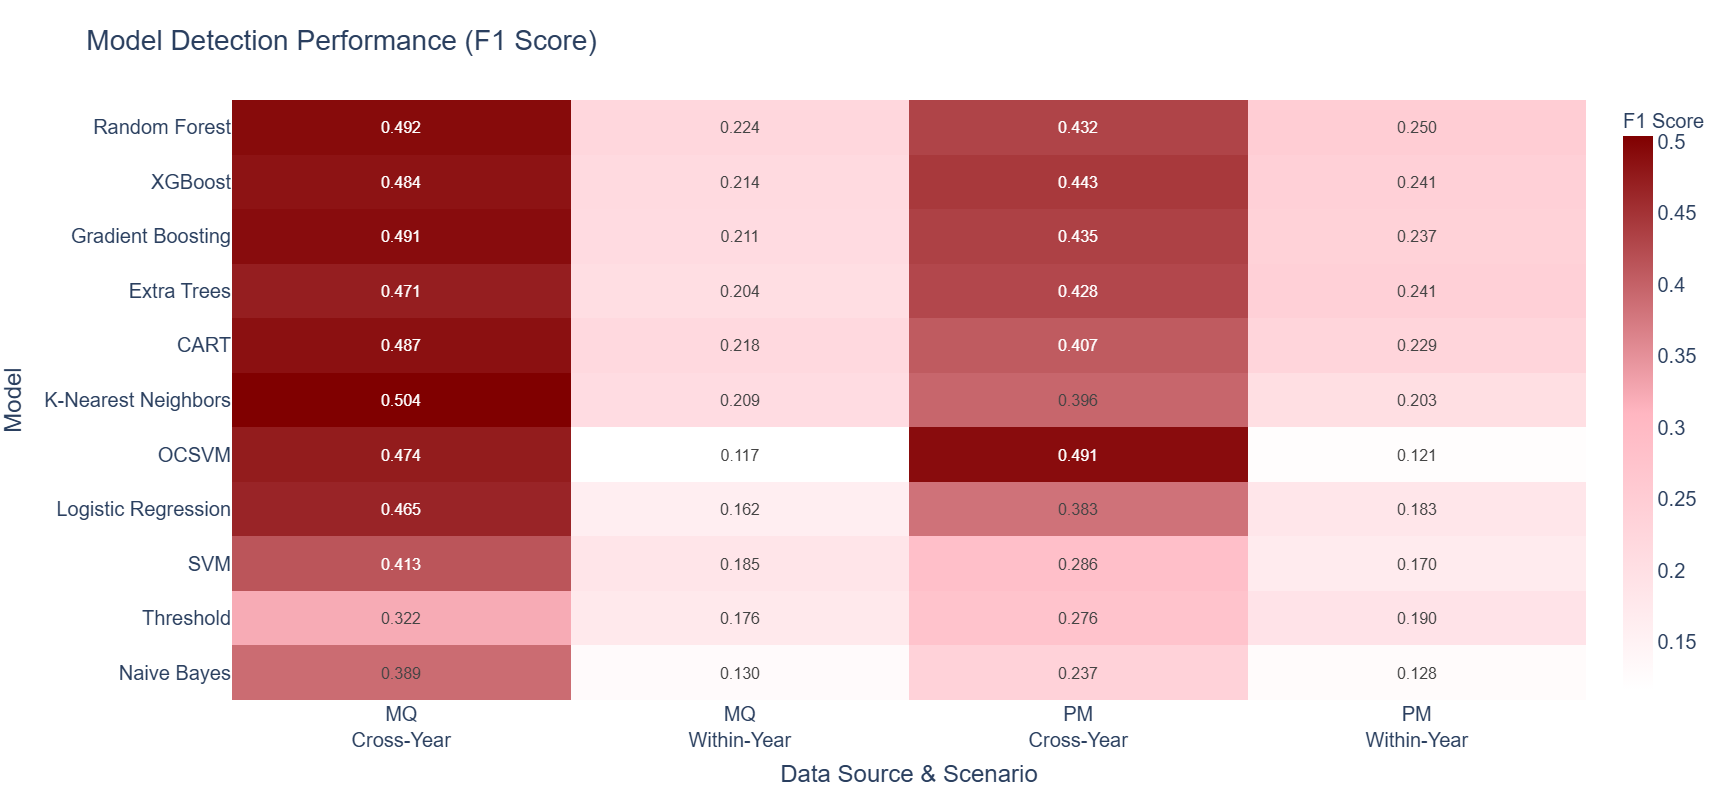

  ✓ Figure 1A saved

[FIGURE 2A] PM vs MQ Comparison...


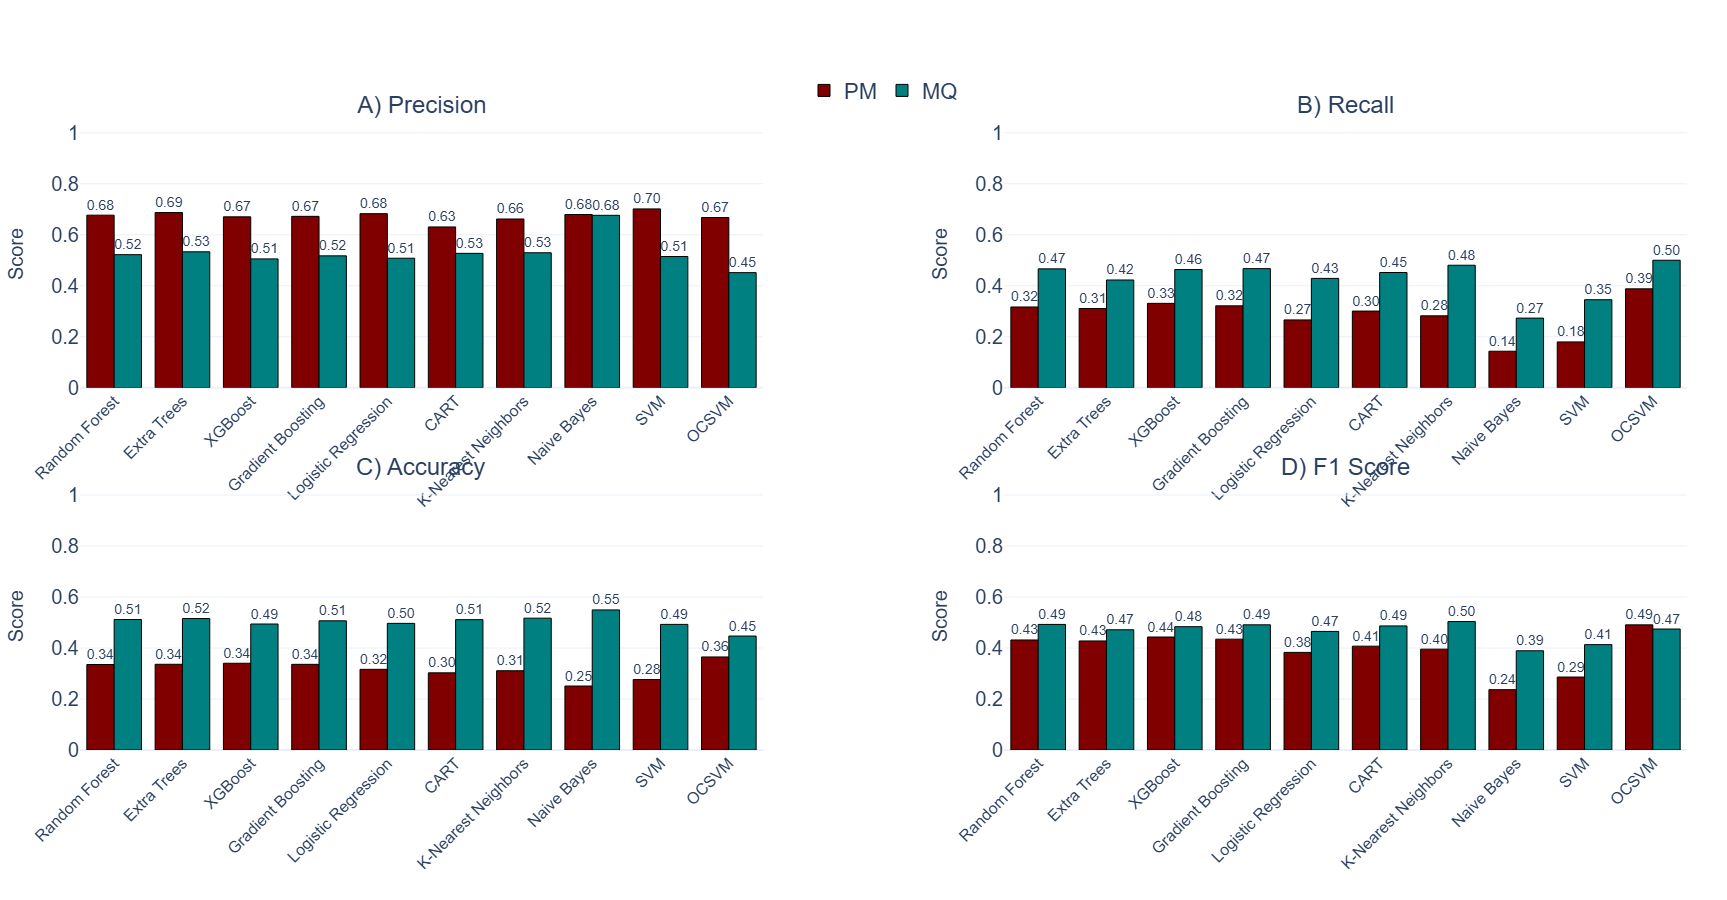

  ✓ Figure 2A saved

[FIGURE 3A] Confusion Matrix Visualization...


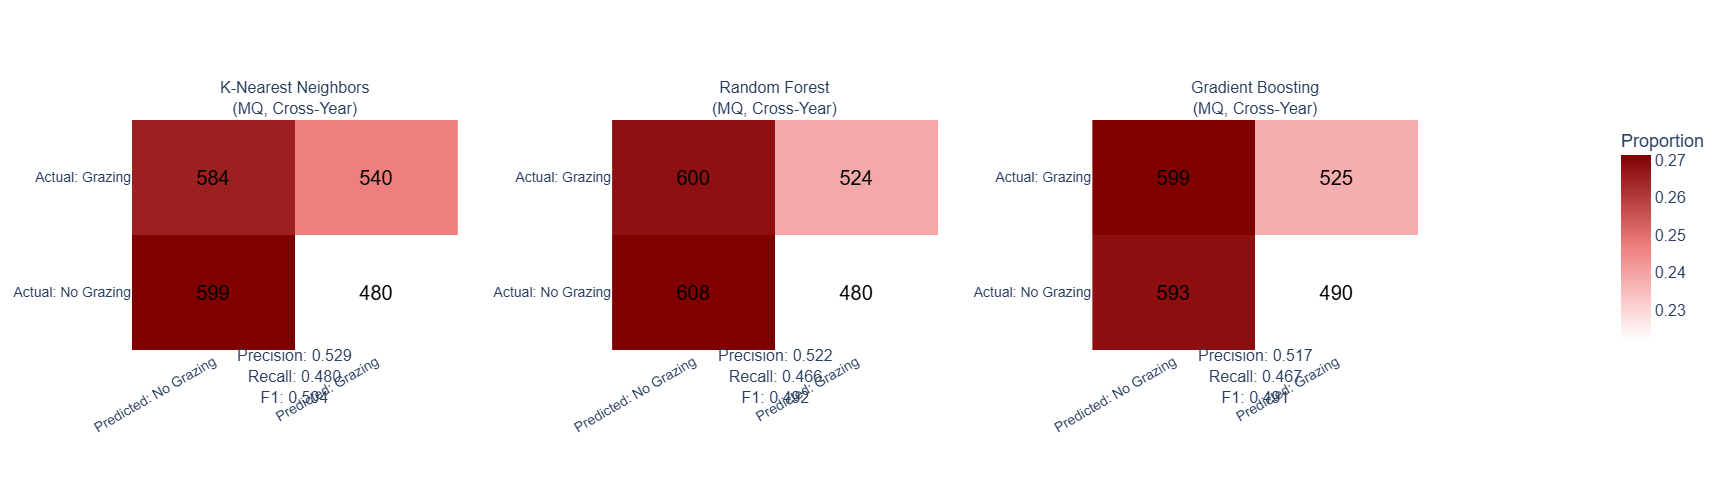

  ✓ Figure 3A saved

BLOCK 12A COMPLETE

Figures saved to /mnt/user-data/outputs/:
  - Figure1A_Detection_Performance_Heatmap.svg
  - Figure2A_PM_vs_MQ_Comparison.svg
  - Figure3A_Confusion_Matrices.svg

Next: Block 12B (PU Agreement Figures)


In [118]:
"""
BLOCK 12A: Detection Performance Figures
========================================
Creates publication-ready figures for Part A (Detection Accuracy)

Inputs: detection_results_df from Block 10
Outputs: 3 SVG figures for detection performance
"""

import pandas as pd
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots

print("="*70)
print("BLOCK 12A: DETECTION PERFORMANCE FIGURES")
print("="*70)

# ═══════════════════════════════════════════════════════════════════════════
# AESTHETIC CONFIGURATION
# ═══════════════════════════════════════════════════════════════════════════

COLORS = {
    'primary': 'maroon',
    'secondary': 'teal',
    'tertiary': 'indianred',
    'accent': 'pink',
    'light_primary': 'lightcoral',
    'light_secondary': 'lightseagreen',
    'light_accent': 'lightpink',
    'gray': 'gray',
    'lightgray': 'lightgray',
    'black': 'black'
}

FONT_CONFIG = {
    'family': 'Arial',
    'size_title': 24,
    'size_axis': 20,
    'size_tick': 20,
    'size_annotation': 16
}

TEMPLATE = 'plotly_white'
EXPORT_SCALE = 50

# ═══════════════════════════════════════════════════════════════════════════
# FIGURE 1A: DETECTION PERFORMANCE HEATMAP (F1 SCORES)
# ═══════════════════════════════════════════════════════════════════════════

print("\n[FIGURE 1A] Detection Performance Heatmap...")

# Pivot data for heatmap
heatmap_data = detection_results_df.pivot_table(
    index='model',
    columns=['data_source', 'scenario'],
    values='f1'
)

# Sort by mean F1 score
heatmap_data['mean_f1'] = heatmap_data.mean(axis=1)
heatmap_data = heatmap_data.sort_values('mean_f1', ascending=True)
heatmap_data = heatmap_data.drop('mean_f1', axis=1)

# Create column labels
col_labels = [f"{ds}<br>{sc}" for ds, sc in heatmap_data.columns]

fig1a = go.Figure(data=go.Heatmap(
    z=heatmap_data.values,
    x=col_labels,
    y=heatmap_data.index,
    colorscale=[[0, 'white'], [0.5, COLORS['light_accent']], [1, COLORS['primary']]],
    colorbar=dict(
        title='F1 Score',
        titlefont=dict(size=FONT_CONFIG['size_axis'], family=FONT_CONFIG['family']),
        tickfont=dict(size=FONT_CONFIG['size_tick'])
    ),
    text=np.round(heatmap_data.values, 3),
    texttemplate='%{text:.3f}',
    textfont=dict(size=FONT_CONFIG['size_annotation'], family=FONT_CONFIG['family']),
    hovertemplate='Model: %{y}<br>Scenario: %{x}<br>F1 Score: %{z:.3f}<extra></extra>'
))

fig1a.update_layout(
    title='Model Detection Performance (F1 Score)',
    xaxis_title='Data Source & Scenario',
    yaxis_title='Model',
    font=dict(size=FONT_CONFIG['size_axis'], family=FONT_CONFIG['family']),
    template=TEMPLATE,
    width=1000,
    height=800,
    margin=dict(l=150, r=100, t=100, b=100)
)

# fig1a.write_image("/mnt/user-data/outputs/Figure1A_Detection_Performance_Heatmap.svg",
#                  format="svg", scale=EXPORT_SCALE, width=1000, height=800)

fig1a.show()

print("  ✓ Figure 1A saved")

# ═══════════════════════════════════════════════════════════════════════════
# FIGURE 2A: PM VS MQ COMPARISON (CROSS-YEAR)
# ═══════════════════════════════════════════════════════════════════════════

print("\n[FIGURE 2A] PM vs MQ Comparison...")

# Filter to cross-year
cross_year = detection_results_df[detection_results_df['scenario'] == 'Cross-Year'].copy()

# Get top 10 models by average F1
model_avg_f1 = cross_year.groupby('model')['f1'].mean().sort_values(ascending=False).head(10)
top_models = model_avg_f1.index.tolist()

cross_year_top = cross_year[cross_year['model'].isin(top_models)].copy()

# Create subplot
fig2a = make_subplots(
    rows=2, cols=2,
    subplot_titles=['A) Precision', 'B) Recall', 'C) Accuracy', 'D) F1 Score'],
    horizontal_spacing=0.15,
    vertical_spacing=0.15
)

metrics = [
    ('precision', 1, 1),
    ('recall', 1, 2),
    ('accuracy', 2, 1),
    ('f1', 2, 2)
]

for metric, row, col in metrics:
    for data_source, color in [('PM', COLORS['primary']), ('MQ', COLORS['secondary'])]:
        data = cross_year_top[cross_year_top['data_source'] == data_source]
        
        fig2a.add_trace(
            go.Bar(
                name=data_source if row == 1 and col == 1 else '',
                x=data['model'],
                y=data[metric],
                marker_color=color,
                marker_line_color=COLORS['black'],
                marker_line_width=1,
                text=[f'{v:.2f}' for v in data[metric]],
                textposition='outside',
                textfont=dict(size=14),
                showlegend=(row == 1 and col == 1),
                legendgroup=data_source
            ),
            row=row, col=col
        )

fig2a.update_layout(
    height=900,
    width=1400,
    font=dict(size=FONT_CONFIG['size_axis'], family=FONT_CONFIG['family']),
    template=TEMPLATE,
    barmode='group',
    legend=dict(
        orientation='h',
        yanchor='top',
        y=1.08,
        xanchor='center',
        x=0.5,
        font=dict(size=22)
    ),
    margin=dict(l=80, r=40, t=120, b=150)
)

# Update axes
for row in [1, 2]:
    for col in [1, 2]:
        fig2a.update_xaxes(
            tickangle=-45,
            tickfont=dict(size=16),
            row=row, col=col
        )
        fig2a.update_yaxes(
            title_text='Score',
            range=[0, 1.05],
            tickfont=dict(size=FONT_CONFIG['size_tick']),
            titlefont=dict(size=FONT_CONFIG['size_axis']),
            row=row, col=col
        )

# Update subplot titles
fig2a.update_annotations(font_size=FONT_CONFIG['size_title'], font_family=FONT_CONFIG['family'])

# fig2a.write_image("/mnt/user-data/outputs/Figure2A_PM_vs_MQ_Comparison.svg",
#                  format="svg", scale=EXPORT_SCALE, width=1400, height=900)

fig2a.show()

print("  ✓ Figure 2A saved")

# ═══════════════════════════════════════════════════════════════════════════
# FIGURE 3A: CONFUSION MATRIX VISUALIZATION (TOP 3 MODELS)
# ═══════════════════════════════════════════════════════════════════════════

print("\n[FIGURE 3A] Confusion Matrix Visualization...")

# Get top 3 models
top_3 = detection_results_df.nlargest(3, 'f1')

fig3a = make_subplots(
    rows=1, cols=3,
    subplot_titles=[f"{row['model']}<br>({row['data_source']}, {row['scenario']})" 
                   for _, row in top_3.iterrows()],
    horizontal_spacing=0.12
)

for idx, (_, model_row) in enumerate(top_3.iterrows(), 1):
    # Create confusion matrix
    cm = np.array([
        [model_row['tn'], model_row['fp']],
        [model_row['fn'], model_row['tp']]
    ])
    
    # Normalize for color intensity
    cm_normalized = cm / cm.sum()
    
    fig3a.add_trace(
        go.Heatmap(
            z=cm_normalized,
            x=['Predicted: No Grazing', 'Predicted: Grazing'],
            y=['Actual: No Grazing', 'Actual: Grazing'],
            colorscale=[[0, 'white'], [0.5, COLORS['light_primary']], [1, COLORS['primary']]],
            showscale=(idx == 3),
            colorbar=dict(
                title='Proportion',
                x=1.15,
                titlefont=dict(size=18),
                tickfont=dict(size=16)
            ) if idx == 3 else None,
            text=cm,
            texttemplate='%{text}',
            textfont=dict(size=20, color='black'),
            hovertemplate='%{y}<br>%{x}<br>Count: %{text}<extra></extra>'
        ),
        row=1, col=idx
    )
    
    # Add metrics annotation below
    metrics_text = (f"Precision: {model_row['precision']:.3f}<br>"
                   f"Recall: {model_row['recall']:.3f}<br>"
                   f"F1: {model_row['f1']:.3f}")
    
    # Fix xref/yref syntax: 'x domain' for first subplot, 'x2 domain' for second, etc.
    xref = 'x domain' if idx == 1 else f'x{idx} domain'
    yref = 'y domain' if idx == 1 else f'y{idx} domain'
    
    fig3a.add_annotation(
        text=metrics_text,
        x=0.5,
        y=-0.25,
        xref=xref,
        yref=yref,
        showarrow=False,
        font=dict(size=14),
        align='center'
    )

fig3a.update_layout(
    height=500,
    width=1400,
    font=dict(size=16, family=FONT_CONFIG['family']),
    template=TEMPLATE,
    margin=dict(l=100, r=150, t=120, b=150)
)

# Update axes
for col in [1, 2, 3]:
    fig3a.update_xaxes(
        tickangle=-30,
        tickfont=dict(size=14),
        row=1, col=col
    )
    fig3a.update_yaxes(
        tickfont=dict(size=14),
        row=1, col=col
    )

# Update subplot titles
fig3a.update_annotations(font_size=16, font_family=FONT_CONFIG['family'])

# fig3a.write_image("/mnt/user-data/outputs/Figure3A_Confusion_Matrices.svg",
#                  format="svg", scale=EXPORT_SCALE, width=1400, height=500)

fig3a.show()

print("  ✓ Figure 3A saved")

# ═══════════════════════════════════════════════════════════════════════════
# SUMMARY
# ═══════════════════════════════════════════════════════════════════════════

print("\n" + "="*70)
print("BLOCK 12A COMPLETE")
print("="*70)
print("\nFigures saved to /mnt/user-data/outputs/:")
print("  - Figure1A_Detection_Performance_Heatmap.svg")
print("  - Figure2A_PM_vs_MQ_Comparison.svg")
print("  - Figure3A_Confusion_Matrices.svg")
print("\nNext: Block 12B (PU Agreement Figures)")
print("="*70)

### Block 12B

BLOCK 12B: PU AGREEMENT FIGURES AND TABLES

[TABLE 2B] Agreement Metrics (Displayed)...

  TABLE 2B: PM vs Satellite Agreement Metrics
  Metric                    r        p-value    RMSE       Bias       Agreement    N     
  ----------------------------------------------------------------------------------------------------
  Pre-Grazing Biomass       0.983    <0.001     81.0       20.0       Excellent    221   
  Post-Grazing Biomass      0.999    <0.001     20.0       -4.0       Excellent    221   
  Removal                   0.961    <0.001     83.0       23.0       Excellent    221   

  ✓ Table 2B displayed
    Removal: r=0.961, RMSE=83, Agreement: Excellent

[FIGURE 3B] Farm-Level Removal Agreement...


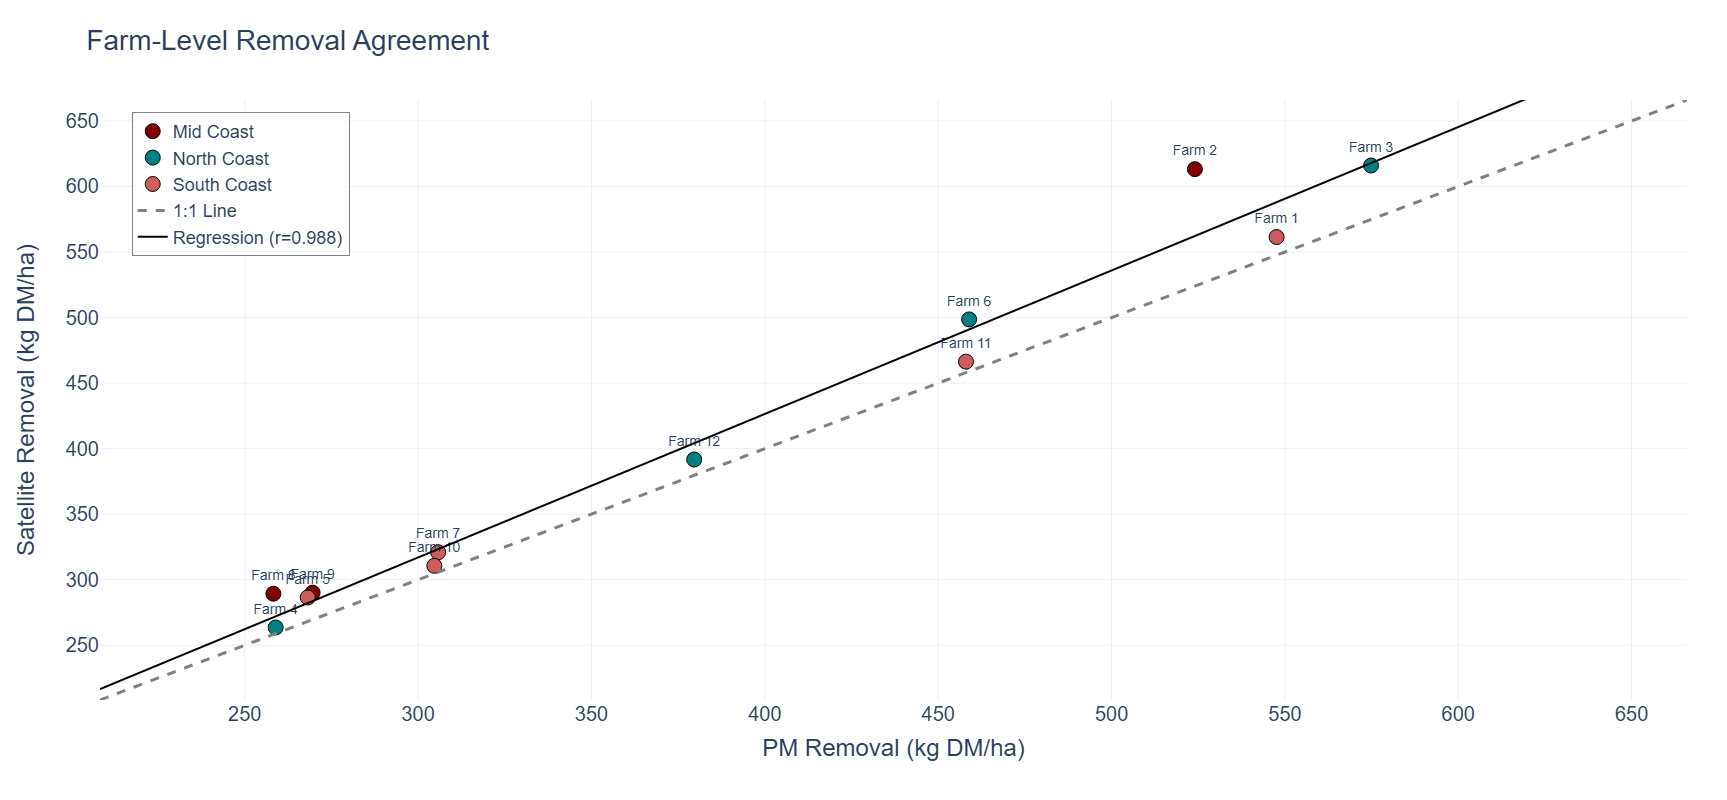

  ✓ Figure 3B saved
    Farms shown: 12
    Correlation: r=0.988

[FIGURE 4B] Paddock-Level Pre/Post by Farm and Region...

  Complete farm mapping (sorted by Farm number):
      Farm 1 → Apps            → South Coast     → 13 events
      Farm 2 → Bale            → Mid Coast       → 18 events
      Farm 3 → Behrens         → North Coast     → 15 events
      Farm 4 → Clarke          → North Coast     → 9 events
      Farm 5 → Game            → South Coast     → 10 events
      Farm 6 → Gould           → North Coast     → 14 events
      Farm 7 → Holmes          → South Coast     → 34 events
      Farm 8 → Neilson         → Mid Coast       → 18 events
      Farm 9 → Nicholson       → Mid Coast       → 12 events
     Farm 10 → Russell         → South Coast     → 32 events
     Farm 11 → Ryan            → South Coast     → 16 events
     Farm 12 → Tonge           → North Coast     → 30 events

  ----------------------------------------------------------------------

  Currently selected 

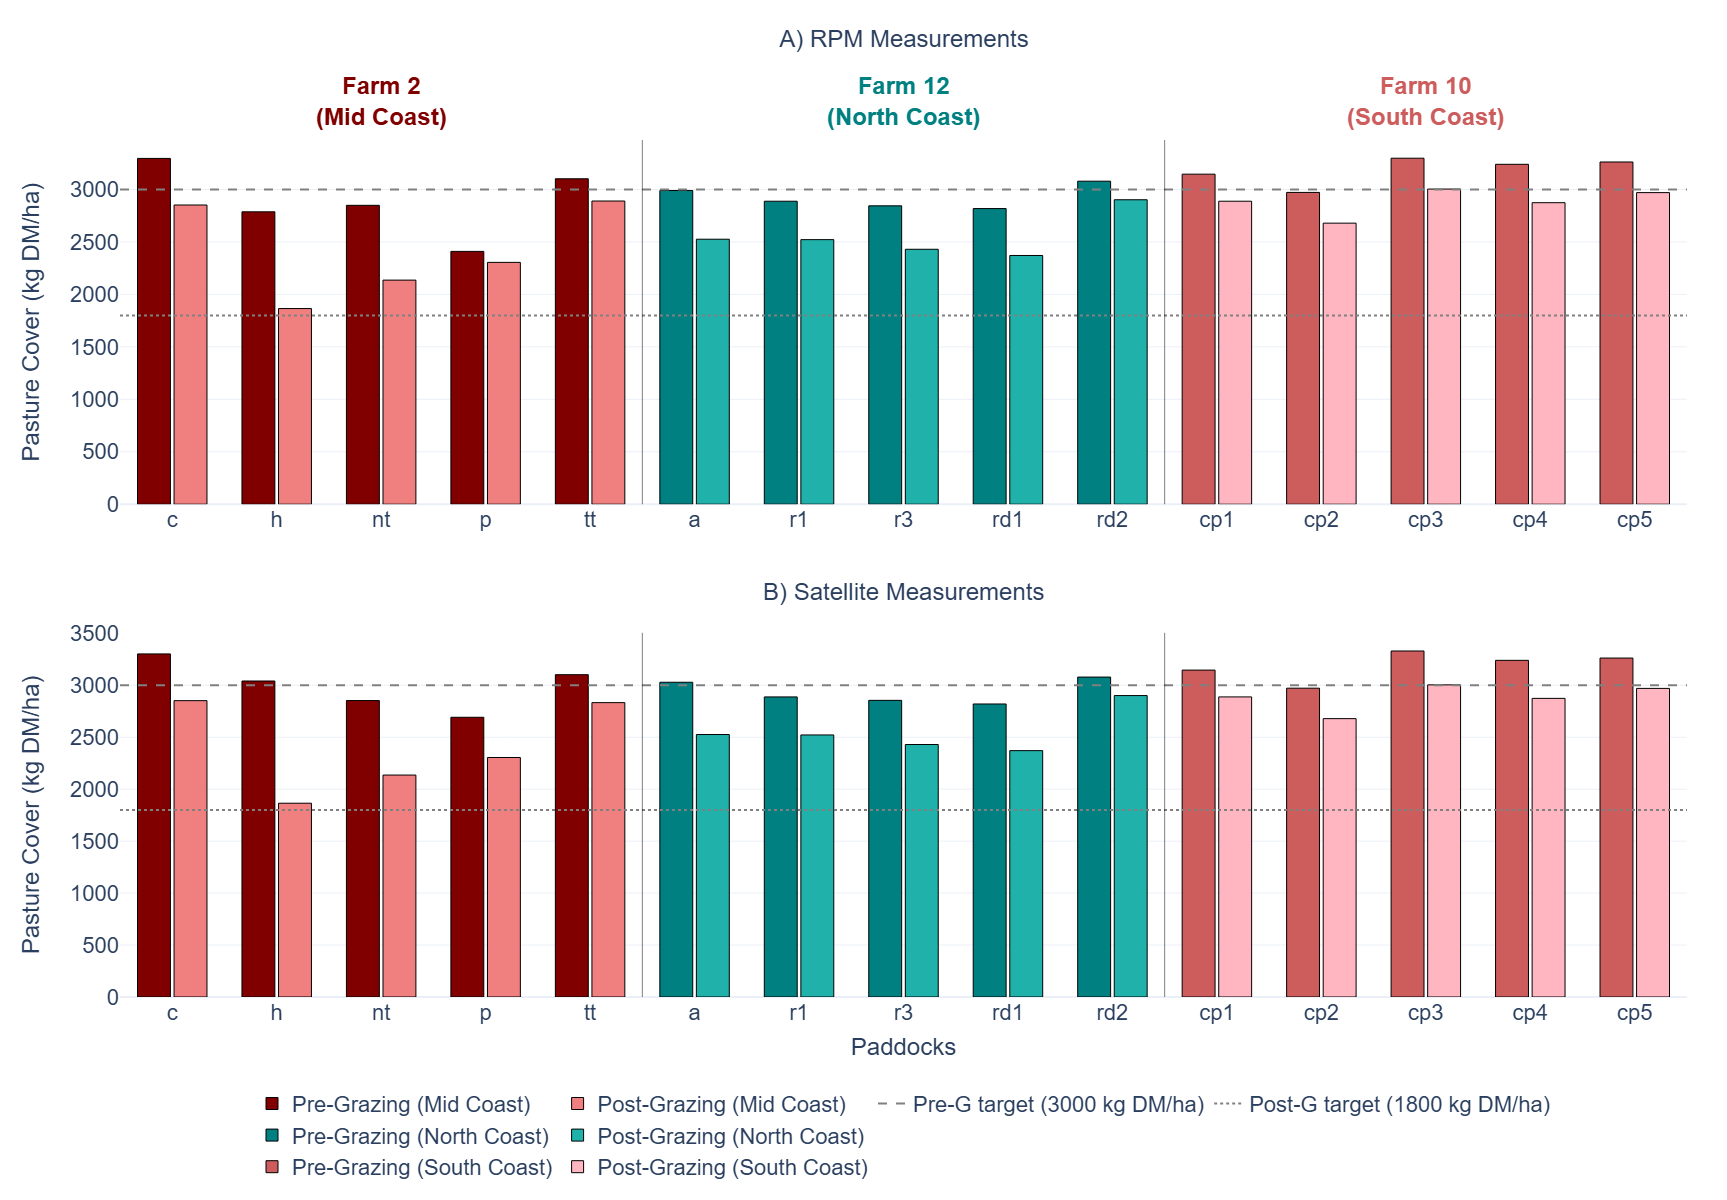

  ✓ Figure 4B saved
    Selected farms: {'Mid Coast': 'Farm 2', 'North Coast': 'Farm 12', 'South Coast': 'Farm 10'}
    Total paddocks shown: 15

BLOCK 12B COMPLETE

Outputs saved to /mnt/user-data/outputs/:
  - Table 2B: Agreement Metrics (displayed above)
  - Figure3B_Farm_Removal_Agreement.png
  - Figure4B_Paddock_Level_Performance.png

ALL VALIDATION COMPLETE!


In [119]:
"""
BLOCK 12B: PU Agreement Figures and Tables
==========================================
Creates publication-ready outputs for Part B (PU Quantification Agreement)

Inputs: matched_pu, correlation_results from Block 10
Outputs: 
  - Table 2B: Agreement metrics (displayed)
  - Figure 3B: Farm-level removal agreement scatter
  - Figure 4B: Paddock-level pre/post by farm and region
"""

import pandas as pd
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy.stats import pearsonr, linregress

print("="*70)
print("BLOCK 12B: PU AGREEMENT FIGURES AND TABLES")
print("="*70)

# ═══════════════════════════════════════════════════════════════════════════
# AESTHETIC CONFIGURATION
# ═══════════════════════════════════════════════════════════════════════════

COLORS = {
    'primary': 'maroon',
    'secondary': 'teal',
    'tertiary': 'indianred',
    'accent': 'pink',
    'light_primary': 'lightcoral',
    'light_secondary': 'lightseagreen',
    'light_accent': 'lightpink',
    'gray': 'gray',
    'lightgray': 'lightgray',
    'black': 'black'
}

FONT_CONFIG = {
    'family': 'Arial',
    'size_title': 24,
    'size_axis': 20,
    'size_tick': 20,
    'size_annotation': 16
}

TEMPLATE = 'plotly_white'
EXPORT_SCALE = 50

# ═══════════════════════════════════════════════════════════════════════════
# TABLE 2B: AGREEMENT METRICS (DISPLAYED AS TABLE)
# ═══════════════════════════════════════════════════════════════════════════

print("\n[TABLE 2B] Agreement Metrics (Displayed)...")

if correlation_results is not None:
    # Create agreement table
    table2b_data = []
    
    for metric_name, key in [
        ('Pre-Grazing Biomass', 'pre_grazing'),
        ('Post-Grazing Biomass', 'post_grazing'),
        ('Removal', 'removal')
    ]:
        # Skip if key doesn't exist
        if key not in correlation_results:
            continue
            
        metric_data = correlation_results[key]
        r = metric_data['r']
        
        # Determine agreement level
        if r >= 0.8:
            agreement = 'Excellent'
        elif r >= 0.6:
            agreement = 'Good'
        elif r >= 0.4:
            agreement = 'Moderate'
        elif r >= 0.2:
            agreement = 'Weak'
        else:
            agreement = 'Very Weak'
        
        table2b_data.append({
            'metric': metric_name,
            'correlation_r': round(metric_data['r'], 3),
            'p_value': f"{metric_data['p']:.4f}" if metric_data['p'] >= 0.001 else "<0.001",
            'rmse': round(metric_data['rmse'], 0),
            'bias': round(metric_data['bias'], 0),
            'agreement': agreement,
            'n_events': correlation_results['n_events']
        })
    
    table2b = pd.DataFrame(table2b_data)
    
    # Display table
    print("\n  " + "="*100)
    print("  TABLE 2B: PM vs Satellite Agreement Metrics")
    print("  " + "="*100)
    print(f"  {'Metric':<25} {'r':<8} {'p-value':<10} {'RMSE':<10} {'Bias':<10} {'Agreement':<12} {'N':<6}")
    print("  " + "-"*100)
    for _, row in table2b.iterrows():
        print(f"  {row['metric']:<25} {row['correlation_r']:<8} {row['p_value']:<10} "
              f"{row['rmse']:<10} {row['bias']:<10} {row['agreement']:<12} {row['n_events']:<6}")
    print("  " + "="*100)
    
    print(f"\n  ✓ Table 2B displayed")
    print(f"    Removal: r={table2b[table2b['metric']=='Removal']['correlation_r'].values[0]:.3f}, "
          f"RMSE={table2b[table2b['metric']=='Removal']['rmse'].values[0]:.0f}, "
          f"Agreement: {table2b[table2b['metric']=='Removal']['agreement'].values[0]}")
else:
    print("  ⚠ No correlation results - skipping Table 2B")

# ═══════════════════════════════════════════════════════════════════════════
# FIGURE 3B: FARM-LEVEL REMOVAL AGREEMENT
# ═══════════════════════════════════════════════════════════════════════════

print("\n[FIGURE 3B] Farm-Level Removal Agreement...")

if len(matched_pu) > 0 and 'farm_id_mapping' in globals():
    # Get region mapping
    if 'Region' in d_pm_new.columns:
        region_map = dict(zip(d_pm_new['Farm Code'], d_pm_new['Region']))
        
        REGION_COLORS = {
            'Mid Coast': COLORS['primary'],
            'North Coast': COLORS['secondary'],
            'South Coast': COLORS['tertiary']
        }
    else:
        region_map = {}
        REGION_COLORS = {}
    
    # Calculate farm averages
    farm_avg = matched_pu.groupby('farm_code').agg({
        'pm_removal': 'mean',
        'sent_removal': 'mean'
    }).reset_index()
    
    farm_avg = farm_avg[farm_avg['pm_removal'].notna() & farm_avg['sent_removal'].notna()]
    
    if len(farm_avg) > 0:
        # Add farm IDs and regions
        farm_avg['farm_id'] = farm_avg['farm_code'].map(farm_id_mapping)
        farm_avg['region'] = farm_avg['farm_code'].map(region_map)
        
        # Create figure
        fig3b = go.Figure()
        
        # Add scatter by region
        for region in ['Mid Coast', 'North Coast', 'South Coast']:
            region_data = farm_avg[farm_avg['region'] == region]
            
            if len(region_data) > 0:
                fig3b.add_trace(
                    go.Scatter(
                        x=region_data['pm_removal'],
                        y=region_data['sent_removal'],
                        mode='markers+text',
                        marker=dict(
                            color=REGION_COLORS.get(region, COLORS['primary']),
                            size=15,
                            line=dict(color=COLORS['black'], width=1)
                        ),
                        text=region_data['farm_id'],
                        textposition='top center',
                        textfont=dict(size=14),
                        name=region,
                        hovertemplate=f'{region}<br>PM: %{{x:.0f}} kg/ha<br>Satellite: %{{y:.0f}} kg/ha<extra></extra>'
                    )
                )
        
        # Add 1:1 line
        min_val = min(farm_avg['pm_removal'].min(), farm_avg['sent_removal'].min()) - 50
        max_val = max(farm_avg['pm_removal'].max(), farm_avg['sent_removal'].max()) + 50
        
        fig3b.add_trace(
            go.Scatter(
                x=[min_val, max_val],
                y=[min_val, max_val],
                mode='lines',
                line=dict(color=COLORS['gray'], dash='dash', width=3),
                name='1:1 Line',
                hoverinfo='skip'
            )
        )
        
        # Add regression line
        r, p = pearsonr(farm_avg['pm_removal'], farm_avg['sent_removal'])
        slope, intercept, _, _, _ = linregress(farm_avg['pm_removal'], farm_avg['sent_removal'])
        
        x_reg = np.array([min_val, max_val])
        y_reg = slope * x_reg + intercept
        
        fig3b.add_trace(
            go.Scatter(
                x=x_reg,
                y=y_reg,
                mode='lines',
                line=dict(color=COLORS['black'], width=2),
                name=f'Regression (r={r:.3f})',
                hoverinfo='skip'
            )
        )
        
        fig3b.update_layout(
            title='Farm-Level Removal Agreement',
            xaxis_title='PM Removal (kg DM/ha)',
            yaxis_title='Satellite Removal (kg DM/ha)',
            font=dict(size=FONT_CONFIG['size_axis'], family=FONT_CONFIG['family']),
            template=TEMPLATE,
            width=800,
            height=800,
            margin=dict(l=100, r=40, t=100, b=100),
            legend=dict(
                orientation='v',
                yanchor='top',
                y=0.98,
                xanchor='left',
                x=0.02,
                font=dict(size=18),
                bgcolor='rgba(255,255,255,0.8)',
                bordercolor=COLORS['gray'],
                borderwidth=1
            )
        )
        
        # Set equal axis ranges
        fig3b.update_xaxes(range=[min_val, max_val], tickfont=dict(size=FONT_CONFIG['size_tick']))
        fig3b.update_yaxes(range=[min_val, max_val], tickfont=dict(size=FONT_CONFIG['size_tick']))
        
        # fig3b.write_image("/mnt/user-data/outputs/Figure3B_Farm_Removal_Agreement.png",
        #                  format="png", scale=2, width=800, height=800)
        
        fig3b.show()
        
        print("  ✓ Figure 3B saved")
        print(f"    Farms shown: {len(farm_avg)}")
        print(f"    Correlation: r={r:.3f}")
    else:
        print("  ⚠ No farm-level data - skipping Figure 3B")
else:
    print("  ⚠ No matched PU data or farm mapping - skipping Figure 3B")

# ═══════════════════════════════════════════════════════════════════════════
# FIGURE 4B: PADDOCK-LEVEL PRE/POST BY FARM AND REGION
# ═══════════════════════════════════════════════════════════════════════════

print("\n[FIGURE 4B] Paddock-Level Pre/Post by Farm and Region...")

# List complete farm mapping with event counts
if 'farm_id_mapping' in globals() and 'Region' in d_pm_new.columns and len(matched_pu) > 0:
    print("\n  Complete farm mapping (sorted by Farm number):")
    
    # Get farm-region mapping
    farm_region_map = dict(zip(d_pm_new['Farm Code'], d_pm_new['Region']))
    
    # Count events per farm
    farm_event_counts = matched_pu.groupby('farm_code').size().to_dict()
    
    # Create list of all farms with their details
    all_farms = []
    for farm_code, farm_id in farm_id_mapping.items():
        region = farm_region_map.get(farm_code, 'Unknown')
        n_events = farm_event_counts.get(farm_code, 0)
        # Extract farm number for sorting
        farm_num = int(farm_id.replace('Farm ', ''))
        all_farms.append({
            'farm_id': farm_id,
            'farm_code': farm_code,
            'region': region,
            'n_events': n_events,
            'farm_num': farm_num
        })
    
    # Sort by farm number
    all_farms = sorted(all_farms, key=lambda x: x['farm_num'])
    
    # Display table
    for farm in all_farms:
        print(f"    {farm['farm_id']:>8} → {farm['farm_code']:<15} → {farm['region']:<15} → {farm['n_events']} events")
    
    print("\n" + "  " + "-"*70)

# Farm selection (easily changeable - modify these to change displayed farms)
# CORRECTED to match actual farm-region mapping from data
selected_farms = {
    'Mid Coast': 'Farm 2',      # Bale - 8 events
    'North Coast': 'Farm 12',   # Tonge - 9 events (CORRECTED)
    'South Coast': 'Farm 10'    # Russell - 13 events (CORRECTED)
}

print(f"\n  Currently selected farms for Figure 4B:")
for region, farm_id in selected_farms.items():
    # Get farm code for selected farm
    farm_code = None
    if 'farm_id_mapping' in globals():
        farm_code_mapping = {v: k for k, v in farm_id_mapping.items()}
        farm_code = farm_code_mapping.get(farm_id, 'Unknown')
    print(f"    {region:<15} → {farm_id:<8} ({farm_code})")
print("\n  To change selection, modify the 'selected_farms' dictionary above")
print("  " + "-"*70)

if len(matched_pu) > 0 and 'farm_id_mapping' in globals():
    # Get region and farm code mapping
    farm_region_map = {}
    if 'Region' in d_pm_new.columns:
        temp_map = d_pm_new[['Farm Code', 'Region']].drop_duplicates().set_index('Farm Code')['Region'].to_dict()
        farm_region_map.update(temp_map)
    
    # Reverse mapping: Farm ID to farm code
    farm_code_mapping = {v: k for k, v in farm_id_mapping.items()}
    
    # Get farm codes for selected farms
    selected_farm_codes = {}
    for region, farm_id in selected_farms.items():
        if farm_id in farm_code_mapping:
            selected_farm_codes[region] = farm_code_mapping[farm_id]
        else:
            print(f"  Warning: {farm_id} not found in mapping")
    
    if len(selected_farm_codes) == 3:
        # Filter matches for selected farms
        selected_matches = matched_pu[matched_pu['farm_code'].isin(selected_farm_codes.values())].copy()
        
        if not selected_matches.empty:
            # Calculate paddock-level averages for selected farms
            paddock_data = selected_matches.groupby(['farm_code', 'pcode']).agg({
                'sent_pre_grazing': 'mean',
                'sent_post_grazing': 'mean',
                'pm_pre_grazing': 'mean',
                'pm_post_grazing': 'mean'
            }).reset_index()
            
            # Add farm IDs and regions
            paddock_data['farm_id'] = paddock_data['farm_code'].map(farm_id_mapping)
            paddock_data['region'] = paddock_data['farm_code'].map(farm_region_map)
            paddock_data['paddock_label'] = paddock_data['pcode']
            
            # Sort by region and paddock
            region_order = ['Mid Coast', 'North Coast', 'South Coast']
            paddock_data['region_order'] = paddock_data['region'].map({r: i for i, r in enumerate(region_order)})
            paddock_data = paddock_data.sort_values(['region_order', 'farm_code', 'pcode'])
            
            # Regional colors
            region_colors = {
                'Mid Coast': COLORS['primary'],
                'North Coast': COLORS['secondary'],
                'South Coast': COLORS['tertiary']
            }
            
            light_colors = {
                'Mid Coast': COLORS['light_primary'],
                'North Coast': COLORS['light_secondary'],
                'South Coast': COLORS['light_accent']
            }
            
            # Create subplots (2 rows: RPM top, Satellite bottom)
            fig4b = make_subplots(
                rows=2, cols=1,
                subplot_titles=['A) RPM Measurements', 'B) Satellite Measurements'],
                vertical_spacing=0.15
            )
            
            # Add RPM bars (top subplot)
            for region in region_order:
                region_data = paddock_data[paddock_data['region'] == region]
                if not region_data.empty:
                    # RPM Pre-grazing
                    fig4b.add_trace(go.Bar(
                        name=f'Pre-Grazing ({region})',
                        x=region_data['paddock_label'],
                        y=region_data['pm_pre_grazing'].round().astype(int),
                        marker_color=region_colors[region],
                        marker_line_color='black',
                        marker_line_width=1,
                        offsetgroup=1,
                        legendgroup='pre',
                        showlegend=True
                    ), row=1, col=1)
            
            # Add RPM post-grazing bars
            for region in region_order:
                region_data = paddock_data[paddock_data['region'] == region]
                if not region_data.empty:
                    # RPM Post-grazing
                    fig4b.add_trace(go.Bar(
                        name=f'Post-Grazing ({region})',
                        x=region_data['paddock_label'],
                        y=region_data['pm_post_grazing'].round().astype(int),
                        marker_color=light_colors[region],
                        marker_line_color='black',
                        marker_line_width=1,
                        offsetgroup=2,
                        legendgroup='post',
                        showlegend=False
                    ), row=1, col=1)
            
            # Add Satellite bars (bottom subplot)
            for region in region_order:
                region_data = paddock_data[paddock_data['region'] == region]
                if not region_data.empty:
                    # Satellite Pre-grazing
                    fig4b.add_trace(go.Bar(
                        name=f'Pre-Grazing ({region})',
                        x=region_data['paddock_label'],
                        y=region_data['sent_pre_grazing'].round().astype(int),
                        marker_color=region_colors[region],
                        marker_line_color='black',
                        marker_line_width=1,
                        offsetgroup=1,
                        legendgroup='pre',
                        showlegend=False
                    ), row=2, col=1)
            
            for region in region_order:
                region_data = paddock_data[paddock_data['region'] == region]
                if not region_data.empty:
                    # Satellite Post-grazing
                    fig4b.add_trace(go.Bar(
                        name=f'Post-Grazing ({region})',
                        x=region_data['paddock_label'],
                        y=region_data['sent_post_grazing'].round().astype(int),
                        marker_color=light_colors[region],
                        marker_line_color='black',
                        marker_line_width=1,
                        offsetgroup=2,
                        legendgroup='post',
                        showlegend=True
                    ), row=2, col=1)
            
            # Add benchmark lines
            for row in [1, 2]:
                fig4b.add_hline(y=3000, line_dash="dash", line_color="gray", line_width=2, row=row, col=1)
                fig4b.add_hline(y=1800, line_dash="dot", line_color="gray", line_width=2, row=row, col=1)
            
            # Add legend for target lines
            fig4b.add_trace(go.Scatter(x=[None], y=[None], mode='lines',
                                      line=dict(color='gray', dash='dash'),
                                      name='Pre-G target (3000 kg DM/ha)', showlegend=True))
            fig4b.add_trace(go.Scatter(x=[None], y=[None], mode='lines',
                                      line=dict(color='gray', dash='dot'),
                                      name='Post-G target (1800 kg DM/ha)', showlegend=True))
            
            # Add farm separators
            farm_boundaries = []
            current_pos = -0.5
            
            for region in region_order:
                region_data = paddock_data[paddock_data['region'] == region]
                if not region_data.empty:
                    farm_paddock_count = len(region_data)
                    current_pos += farm_paddock_count
                    if current_pos < len(paddock_data) - 0.5:
                        farm_boundaries.append(current_pos)
            
            for boundary in farm_boundaries:
                for row in [1, 2]:
                    fig4b.add_vline(x=boundary, line_color="black", line_width=1, opacity=0.5, row=row, col=1)
            
            # Update layout
            fig4b.update_layout(
                title_font_size=20,
                height=1200,
                width=1000,
                font=dict(size=16, family='Arial'),
                template="plotly_white",
                margin=dict(l=120, r=40, t=140, b=120),
                barmode='group',
                bargap=0.3,
                bargroupgap=0.1,
                legend=dict(
                    orientation='h',
                    yanchor='top',
                    y=-0.1,
                    xanchor='center',
                    x=0.5,
                    font=dict(size=22)
                )
            )
            
            # Update axes
            for row in [1, 2]:
                fig4b.update_xaxes(
                    title_text="Paddocks" if row == 2 else "",
                    titlefont=dict(size=24),
                    tickfont=dict(size=22),
                    row=row, col=1
                )
                
                fig4b.update_yaxes(
                    title_text="Pasture Cover (kg DM/ha)",
                    titlefont=dict(size=24),
                    tickfont=dict(size=22),
                    row=row, col=1
                )
            
            # Add region annotations
            region_positions = {}
            current_pos = 0
            
            for region in region_order:
                region_data = paddock_data[paddock_data['region'] == region]
                if not region_data.empty:
                    farm_paddock_count = len(region_data)
                    region_center = current_pos + (farm_paddock_count - 1) / 2
                    region_positions[region] = region_center
                    current_pos += farm_paddock_count
            
            for region, pos in region_positions.items():
                farm_id = selected_farms[region]
                fig4b.add_annotation(
                    text=f"<b>{farm_id}<br>({region})</b>",
                    x=pos,
                    y=1.08,
                    xref='x',
                    yref='paper',
                    showarrow=False,
                    font=dict(size=14, color=region_colors[region]),
                    bgcolor='rgba(255,255,255,0.8)'
                )
            
            # Update subplot titles
            fig4b.update_annotations(font_size=24, font_family='Arial')
            
            for annotation in fig4b['layout']['annotations']:
                if 'A)' in annotation['text']:
                    annotation['y'] = annotation['y'] + 0.10
                elif 'B)' in annotation['text']:
                    annotation['y'] = annotation['y'] + 0.03
            
            # Save figure
            # fig4b.write_image("/mnt/user-data/outputs/Figure4B_Paddock_Level_Performance.png",
            #                  format="png", scale=2, width=1000, height=1200)
            
            fig4b.show()
            
            print("  ✓ Figure 4B saved")
            print(f"    Selected farms: {selected_farms}")
            print(f"    Total paddocks shown: {len(paddock_data)}")
        else:
            print("  ⚠ No matches found for selected farms")
    else:
        print("  ⚠ Could not find all selected farms")
else:
    print("  ⚠ No matched PU data or farm mapping - skipping Figure 4B")

# ═══════════════════════════════════════════════════════════════════════════
# SUMMARY
# ═══════════════════════════════════════════════════════════════════════════

print("\n" + "="*70)
print("BLOCK 12B COMPLETE")
print("="*70)
if len(matched_pu) > 0:
    print("\nOutputs saved to /mnt/user-data/outputs/:")
    print("  - Table 2B: Agreement Metrics (displayed above)")
    print("  - Figure3B_Farm_Removal_Agreement.png")
    print("  - Figure4B_Paddock_Level_Performance.png")
print("\nALL VALIDATION COMPLETE!")
print("="*70)

### Few Stats

In [122]:
"""
Quick Diagnostic: GPS Event Statistics
=======================================
Get actual numbers for Materials and Methods section
"""

import pandas as pd

print("="*70)
print("GPS EVENT STATISTICS FOR MATERIALS AND METHODS")
print("="*70)

# Check for raw grazing dates BEFORE grouping
if 'm_grazing' in globals():
    print("\n[RAW GPS GRAZING DATES (BEFORE GROUPING)]")
    print(f"  Total GPS grazing dates: {len(m_grazing)}")
    print(f"  Unique paddocks: {m_grazing.groupby(['Farm Code', 'pcode']).ngroups}")
    print(f"  Unique farms: {m_grazing['Farm Code'].nunique()}")
    print(f"  Date range: {m_grazing['Date'].min().strftime('%Y-%m-%d')} to {m_grazing['Date'].max().strftime('%Y-%m-%d')}")
    
    # Show example of raw dates
    sample_paddock = m_grazing.groupby(['Farm Code', 'pcode']).size().idxmax()
    sample_dates = m_grazing[(m_grazing['Farm Code'] == sample_paddock[0]) & 
                             (m_grazing['pcode'] == sample_paddock[1])]['Date'].sort_values().head(10)
    print(f"\n  Example raw dates (Farm {sample_paddock[0]}, Paddock {sample_paddock[1]}):")
    for date in sample_dates:
        print(f"    {date.strftime('%Y-%m-%d')}")

# Check if GPS events data exists (AFTER grouping)
if 'gps_events' in globals():
    print("\n[GROUPED GPS EVENTS (AFTER 5-DAY GAP GROUPING)]")
    print(f"  Available columns: {list(gps_events.columns)}")
    print(f"  Total grouped events: {len(gps_events)}")
    print(f"  Unique paddocks: {gps_events.groupby(['Farm Code', 'pcode']).ngroups}")
    print(f"  Unique farms: {gps_events['Farm Code'].nunique()}")
    print(f"  Date range: {gps_events['event_start'].min().strftime('%Y-%m-%d')} to {gps_events['event_end'].max().strftime('%Y-%m-%d')}")
    
    if 'm_grazing' in globals():
        compression_ratio = len(m_grazing) / len(gps_events)
        print(f"\n  Compression: {len(m_grazing)} dates → {len(gps_events)} events ({compression_ratio:.1f}:1 ratio)")
    
    # Events by farm
    print(f"\n[GROUPED EVENTS BY FARM]")
    events_by_farm = gps_events.groupby('Farm Code').agg({
        'event_start': 'count',
        'pcode': 'nunique'
    }).rename(columns={'event_start': 'n_events', 'pcode': 'n_paddocks'})
    
    if 'farm_id_mapping' in globals():
        for farm_code, row in events_by_farm.iterrows():
            farm_id = farm_id_mapping.get(farm_code, farm_code)
            print(f"  {farm_id:>8} ({farm_code:<15}): {row['n_events']:>3} events across {row['n_paddocks']:>2} paddocks")
    else:
        for farm_code, row in events_by_farm.iterrows():
            print(f"  {farm_code:<15}: {row['n_events']:>3} events across {row['n_paddocks']:>2} paddocks")
    
    # Duration statistics
    print(f"\n[EVENT DURATION STATISTICS]")
    print(f"  Mean duration: {gps_events['duration_days'].mean():.1f} days")
    print(f"  Median duration: {gps_events['duration_days'].median():.1f} days")
    print(f"  Min duration: {gps_events['duration_days'].min()} days")
    print(f"  Max duration: {gps_events['duration_days'].max()} days")
    
    # Show grouping example
    sample_paddock = gps_events.groupby(['Farm Code', 'pcode']).size().idxmax()
    sample = gps_events[(gps_events['Farm Code'] == sample_paddock[0]) & 
                       (gps_events['pcode'] == sample_paddock[1])].head(5)
    print(f"\n  Example grouped events (Farm {sample_paddock[0]}, Paddock {sample_paddock[1]}):")
    for i, (idx, row) in enumerate(sample.iterrows(), 1):
        event_label = f"Event {row['event_id']:>3}" if 'event_id' in gps_events.columns else f"Event {i:>3}"
        print(f"    {event_label}: {row['event_start'].strftime('%Y-%m-%d')} to {row['event_end'].strftime('%Y-%m-%d')} ({row['duration_days']} days)")
    
    # Check validation events
    if 'gps_validation_events' in globals():
        print(f"\n[VALIDATION EVENTS (TEST PERIODS ONLY)]")
        print(f"  Total validation events: {len(gps_validation_events)}")
        print(f"  ({len(gps_validation_events)/len(gps_events)*100:.1f}% of all grouped events)")
        print(f"  Date range: {gps_validation_events['event_start'].min().strftime('%Y-%m-%d')} to {gps_validation_events['event_end'].max().strftime('%Y-%m-%d')}")
        
        # Show validation split details
        if 'WITHIN_YEAR_SPLIT' in globals():
            print(f"\n  Validation filter: Events in 2023+ or after {WITHIN_YEAR_SPLIT.strftime('%Y-%m-%d')}")
    
else:
    print("\nERROR: 'gps_events' not found in globals()")
    print("Please run Blocks 1-2 first to load GPS event data")

print("\n" + "="*70)
print("COPY THESE NUMBERS TO MATERIALS AND METHODS:")
print("="*70)
print("\nGPS Collar Deployment section:")
print(f"  - Raw GPS dates: {len(m_grazing) if 'm_grazing' in globals() else 'N/A'}")
print(f"  - Grouped events: {len(gps_events) if 'gps_events' in globals() else 'N/A'}")
print(f"  - Grouping parameter: 5 days (MAX_EVENT_GAP_DAYS)")
print(f"\nGPS Event Grouping section:")
print(f"  - Events grouped within 5 days (not 14!)")
print(f"  - {len(m_grazing) if 'm_grazing' in globals() else 'N/A'} raw dates → {len(gps_events) if 'gps_events' in globals() else 'N/A'} events")
print("="*70)

GPS EVENT STATISTICS FOR MATERIALS AND METHODS

[GROUPED GPS EVENTS (AFTER 5-DAY GAP GROUPING)]
  Available columns: ['Farm Code', 'pcode', 'event_start', 'event_end', 'duration_days', 'duration']
  Total grouped events: 1492
  Unique paddocks: 60
  Unique farms: 12
  Date range: 2022-07-01 to 2024-06-30

[GROUPED EVENTS BY FARM]
    Farm 1 (Apps           ):  90 events across  5 paddocks
    Farm 2 (Bale           ): 118 events across  5 paddocks
    Farm 3 (Behrens        ): 103 events across  5 paddocks
    Farm 4 (Clarke         ): 184 events across  5 paddocks
    Farm 5 (Game           ):  55 events across  5 paddocks
    Farm 6 (Gould          ): 137 events across  5 paddocks
    Farm 7 (Holmes         ): 146 events across  5 paddocks
    Farm 8 (Neilson        ): 173 events across  5 paddocks
    Farm 9 (Nicholson      ): 117 events across  5 paddocks
   Farm 10 (Russell        ): 101 events across  5 paddocks
   Farm 11 (Ryan           ):  79 events across  5 paddocks
   Farm 

### RESULTS 3.1.1

In [127]:
# Get consolidated results
if 'comparison_df' in globals():
    print("="*80)
    print("CONSOLIDATED RESULTS FOR TABLE 1 AND FIGURES")
    print("="*80)
    
    # Full results table
    print("\n[FULL RESULTS - All 56 configurations]")
    print(comparison_df[['model', 'data_source', 'scenario', 'precision', 'recall', 'f1', 'accuracy']].to_string(index=False))
    
    # Identify best per scenario
    print("\n" + "="*80)
    print("[BEST MODEL PER SCENARIO - for Table 1]")
    print("="*80)
    
    for data_source in ['PM', 'MQ']:
        for scenario in ['Within-Year', 'Cross-Year']:
            subset = comparison_df[
                (comparison_df['data_source'] == data_source) & 
                (comparison_df['scenario'] == scenario)
            ]
            best = subset.loc[subset['f1'].idxmax()]
            print(f"\n{scenario} | {data_source}:")
            print(f"  Model: {best['model']}")
            print(f"  Precision: {best['precision']:.3f}")
            print(f"  Recall: {best['recall']:.3f}")
            print(f"  F1: {best['f1']:.3f}")
            print(f"  Accuracy: {best['accuracy']:.3f}")
    
    print("\n" + "="*80)
    print("READY TO BUILD TABLE 1 AND FIGURES!")
    print("="*80)
    
else:
    print("ERROR: comparison_df not found")
    print("Run Blocks 5, 6, and 7-8-9 first")

CONSOLIDATED RESULTS FOR TABLE 1 AND FIGURES

[FULL RESULTS - All 56 configurations]
                       model data_source    scenario  precision   recall       f1  accuracy
   Threshold_HighSensitivity          PM Within-Year   0.640863 0.474624 0.545356  0.594217
   Threshold_HighSensitivity          PM  Cross-Year   0.651596 0.482283 0.554299  0.547646
   Threshold_HighSensitivity          MQ Within-Year   0.647985 0.476610 0.549239  0.598240
   Threshold_HighSensitivity          MQ  Cross-Year   0.662246 0.407952 0.504887  0.539065
 Threshold_MediumSensitivity          PM Within-Year   0.660895 0.430451 0.521343  0.594699
 Threshold_MediumSensitivity          PM  Cross-Year   0.650888 0.433071 0.520095  0.533869
 Threshold_MediumSensitivity          MQ Within-Year   0.683002 0.413154 0.514863  0.600143
 Threshold_MediumSensitivity          MQ  Cross-Year   0.674107 0.328976 0.442167  0.521807
    Threshold_LowSensitivity          PM Within-Year   0.689145 0.393797 0.501196  0.59

### Figure 1 Code: Top Model Performance Comparison

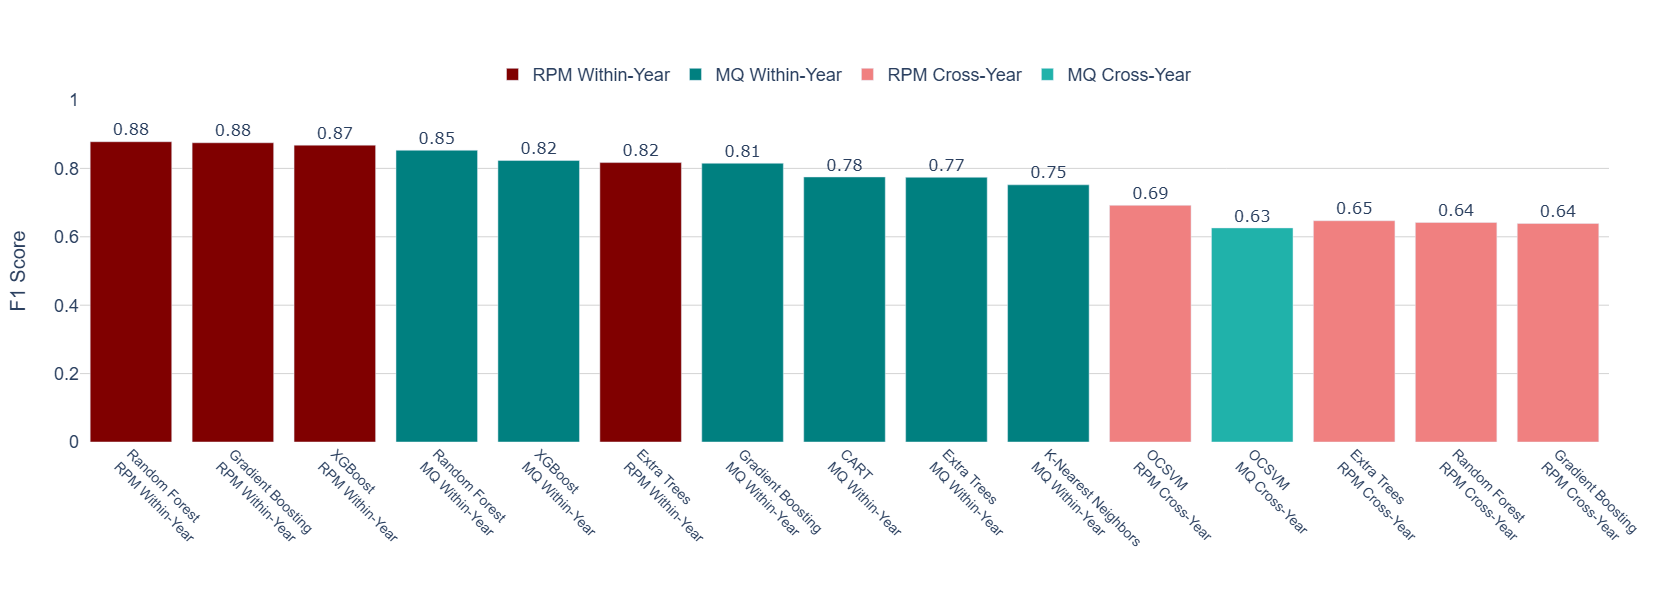

✓ Figure 1 saved: Figure1_Model_Performance_Top15.svg


In [1]:
import plotly.graph_objects as go
import pandas as pd

# Prepare data - Top 15 models by F1 score
results = pd.DataFrame({
    'model': ['Random Forest', 'Gradient Boosting', 'XGBoost', 'Random Forest', 
              'XGBoost', 'Extra Trees', 'Gradient Boosting', 'CART', 
              'Extra Trees', 'K-Nearest Neighbors', 'OCSVM', 'OCSVM',
              'Extra Trees', 'Random Forest', 'Gradient Boosting'],
    'data_source': ['RPM', 'RPM', 'RPM', 'MQ', 'MQ', 'RPM', 'MQ', 'MQ', 
                    'MQ', 'MQ', 'RPM', 'MQ', 'RPM', 'RPM', 'RPM'],
    'scenario': ['Within-Year', 'Within-Year', 'Within-Year', 'Within-Year',
                 'Within-Year', 'Within-Year', 'Within-Year', 'Within-Year',
                 'Within-Year', 'Within-Year', 'Cross-Year', 'Cross-Year',
                 'Cross-Year', 'Cross-Year', 'Cross-Year'],
    'f1': [0.878, 0.875, 0.868, 0.853, 0.823, 0.817, 0.815, 0.775,
           0.774, 0.752, 0.692, 0.626, 0.647, 0.642, 0.639]
})

# Add category column
results['category'] = results['data_source'] + ' ' + results['scenario']

# Create figure
fig = go.Figure()

# Define colors and labels
categories = {
    'RPM Within-Year': {'color': 'maroon', 'shown': False},
    'MQ Within-Year': {'color': 'teal', 'shown': False},
    'RPM Cross-Year': {'color': 'lightcoral', 'shown': False},
    'MQ Cross-Year': {'color': 'lightseagreen', 'shown': False}
}

# Add bars - one trace per bar, but smart legend control
for idx, row in results.iterrows():
    category = row['category']
    
    # Only show legend for first occurrence of each category
    show_this_legend = not categories[category]['shown']
    if show_this_legend:
        categories[category]['shown'] = True
    
    fig.add_trace(go.Bar(
        x=[idx],
        y=[row['f1']],
        marker_color=categories[category]['color'],
        name=category,
        legendgroup=category,
        text=f"{row['f1']:.2f}",
        textposition='outside',
        textfont=dict(size=16),
        hovertemplate=f"<b>{row['model']}</b><br>" +
                     f"{category}<br>" +
                     f"F1: {row['f1']:.2f}<extra></extra>",
        showlegend=show_this_legend
    ))

# Update layout
fig.update_layout(
    title=dict(
        # text='Top 15 Model Configurations by F1 Score',
        font=dict(size=24, family='Arial', color='black'),
        x=0.5,
        xanchor='center'
    ),
    xaxis=dict(
        title='',
        ticktext=[f"{r['model']}<br>{r['data_source']} {r['scenario']}" 
                 for _, r in results.iterrows()],
        tickvals=list(range(len(results))),
        tickfont=dict(size=14, family='Arial'),
        tickangle=45
    ),
    yaxis=dict(
        title='F1 Score',
        titlefont=dict(size=20, family='Arial'),
        tickfont=dict(size=18, family='Arial'),
        range=[0, 1.0]
    ),
    plot_bgcolor='white',
    paper_bgcolor='white',
    showlegend=True,
    legend=dict(
        font=dict(size=18, family='Arial'),
        orientation='h',
        yanchor='bottom',
        y=1.02,
        xanchor='center',
        x=0.5
    ),
    width=1000,
    height=600,
    margin=dict(l=80, r=40, t=100, b=150)
)

# Add gridlines
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='lightgray')

# Save
fig.write_image(r'data/', scale=20)
fig.show()

print("✓ Figure 1 saved: Figure1_Model_Performance_Top15.svg")

### Figure 2 Code: Temporal Transferability Analysis

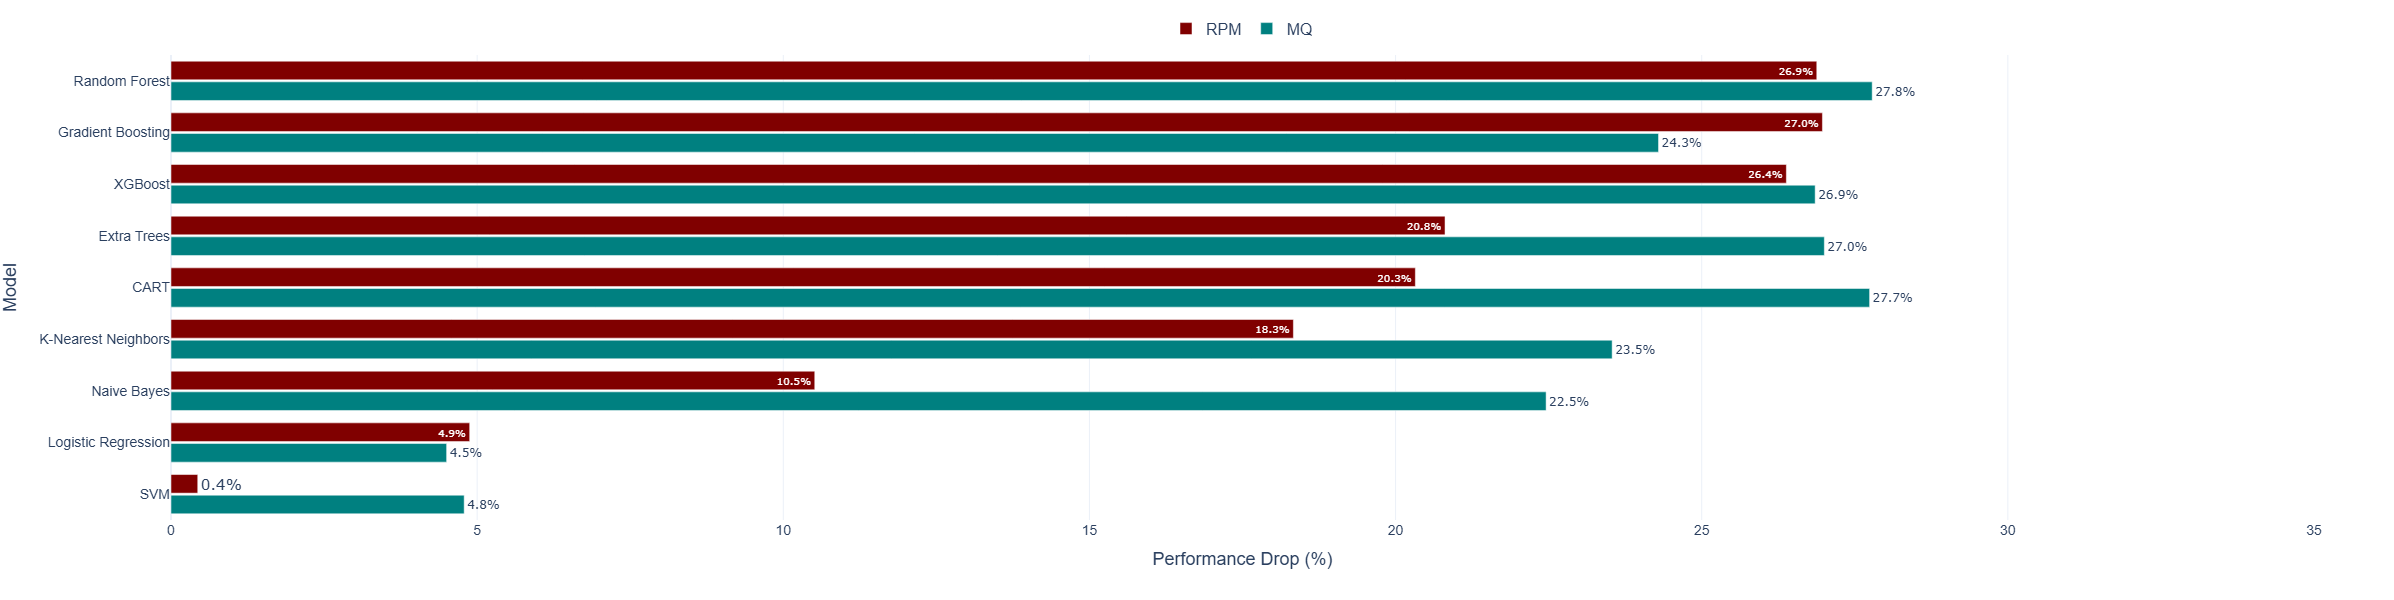

✓ Figure 2 saved: Figure2_Performance_Degradation.svg


In [220]:
import plotly.graph_objects as go
import pandas as pd

# All results for supervised models
all_results = pd.DataFrame({
    'model': ['Random Forest', 'Random Forest', 'Random Forest', 'Random Forest',
              'Extra Trees', 'Extra Trees', 'Extra Trees', 'Extra Trees',
              'XGBoost', 'XGBoost', 'XGBoost', 'XGBoost',
              'Gradient Boosting', 'Gradient Boosting', 'Gradient Boosting', 'Gradient Boosting',
              'Logistic Regression', 'Logistic Regression', 'Logistic Regression', 'Logistic Regression',
              'CART', 'CART', 'CART', 'CART',
              'K-Nearest Neighbors', 'K-Nearest Neighbors', 'K-Nearest Neighbors', 'K-Nearest Neighbors',
              'Naive Bayes', 'Naive Bayes', 'Naive Bayes', 'Naive Bayes',
              'SVM', 'SVM', 'SVM', 'SVM'],
    'data_source': ['RPM', 'RPM', 'MQ', 'MQ'] * 9,
    'scenario': ['Within-Year', 'Cross-Year', 'Within-Year', 'Cross-Year'] * 9,
    'f1': [0.878, 0.642, 0.853, 0.616,
           0.817, 0.647, 0.774, 0.565,
           0.868, 0.639, 0.823, 0.602,
           0.875, 0.639, 0.815, 0.617,
           0.615, 0.585, 0.622, 0.594,
           0.743, 0.592, 0.775, 0.560,
           0.731, 0.597, 0.752, 0.575,
           0.428, 0.383, 0.423, 0.328,
           0.458, 0.456, 0.543, 0.517]
})

# Calculate performance drops
models_to_compare = ['Random Forest', 'Extra Trees', 'XGBoost', 'Gradient Boosting',
                     'Logistic Regression', 'CART', 'K-Nearest Neighbors', 'Naive Bayes', 'SVM']

performance_data = []
for model in models_to_compare:
    for data_source in ['RPM', 'MQ']:
        subset = all_results[(all_results['model'] == model) & (all_results['data_source'] == data_source)]
        within = subset[subset['scenario'] == 'Within-Year']['f1'].values[0]
        cross = subset[subset['scenario'] == 'Cross-Year']['f1'].values[0]
        
        performance_data.append({
            'model': model,
            'data_source': data_source,
            'within_f1': within,
            'cross_f1': cross,
            'drop': within - cross,
            'drop_pct': (within - cross) / within * 100
        })

perf_df = pd.DataFrame(performance_data)

# Create figure
fig = go.Figure()

# Sort by drop percentage
rpm_drops = perf_df[perf_df['data_source'] == 'RPM'].sort_values('drop', ascending=False)
mq_drops = perf_df[perf_df['data_source'] == 'MQ'].sort_values('drop', ascending=False)

fig.add_trace(go.Bar(
    name='RPM',
    x=rpm_drops['drop_pct'],
    y=rpm_drops['model'],
    orientation='h',
    marker_color='maroon',
    text=[f"{x:.1f}%" for x in rpm_drops['drop_pct']],
    textposition='auto',
    textfont=dict(size=16),
    hovertemplate='<b>%{y}</b><br>RPM Drop: %{x:.1f}%<extra></extra>'
))

fig.add_trace(go.Bar(
    name='MQ',
    x=mq_drops['drop_pct'],
    y=mq_drops['model'],
    orientation='h',
    marker_color='teal',
    text=[f"{x:.1f}%" for x in mq_drops['drop_pct']],
    textposition='outside',
    textfont=dict(size=12),
    hovertemplate='<b>%{y}</b><br>MQ Drop: %{x:.1f}%<extra></extra>'
))

# Update layout
fig.update_layout(
    template='plotly_white',
    title=dict(
        # text='Performance Degradation: Within-Year to Cross-Year Validation',
        font=dict(size=22, family='Arial', color='black'),
        x=0.5,
        xanchor='center'
    ),
    xaxis=dict(
        title='Performance Drop (%)',
        titlefont=dict(size=18, family='Arial'),
        tickfont=dict(size=14, family='Arial'),
        range=[0, 35]
    ),
    yaxis=dict(
        title='Model',
        titlefont=dict(size=18, family='Arial'),
        tickfont=dict(size=14, family='Arial'),
        autorange='reversed'
    ),
    showlegend=True,
    legend=dict(
        font=dict(size=16, family='Arial'),
        orientation='h',
        yanchor='bottom',
        y=1.02,
        xanchor='center',
        x=0.5
    ),
    width=600,
    height=600,
    margin=dict(l=50, r=80, t=50, b=80),
    barmode='group',
    bargap=0.2,
    bargroupgap=0.1
)

# Save
fig.write_image(r'data/', scale=20)
fig.show()

print("✓ Figure 2 saved: Figure2_Performance_Degradation.svg")

### Figure 3 Code: Comprehensive Performance Heatmap

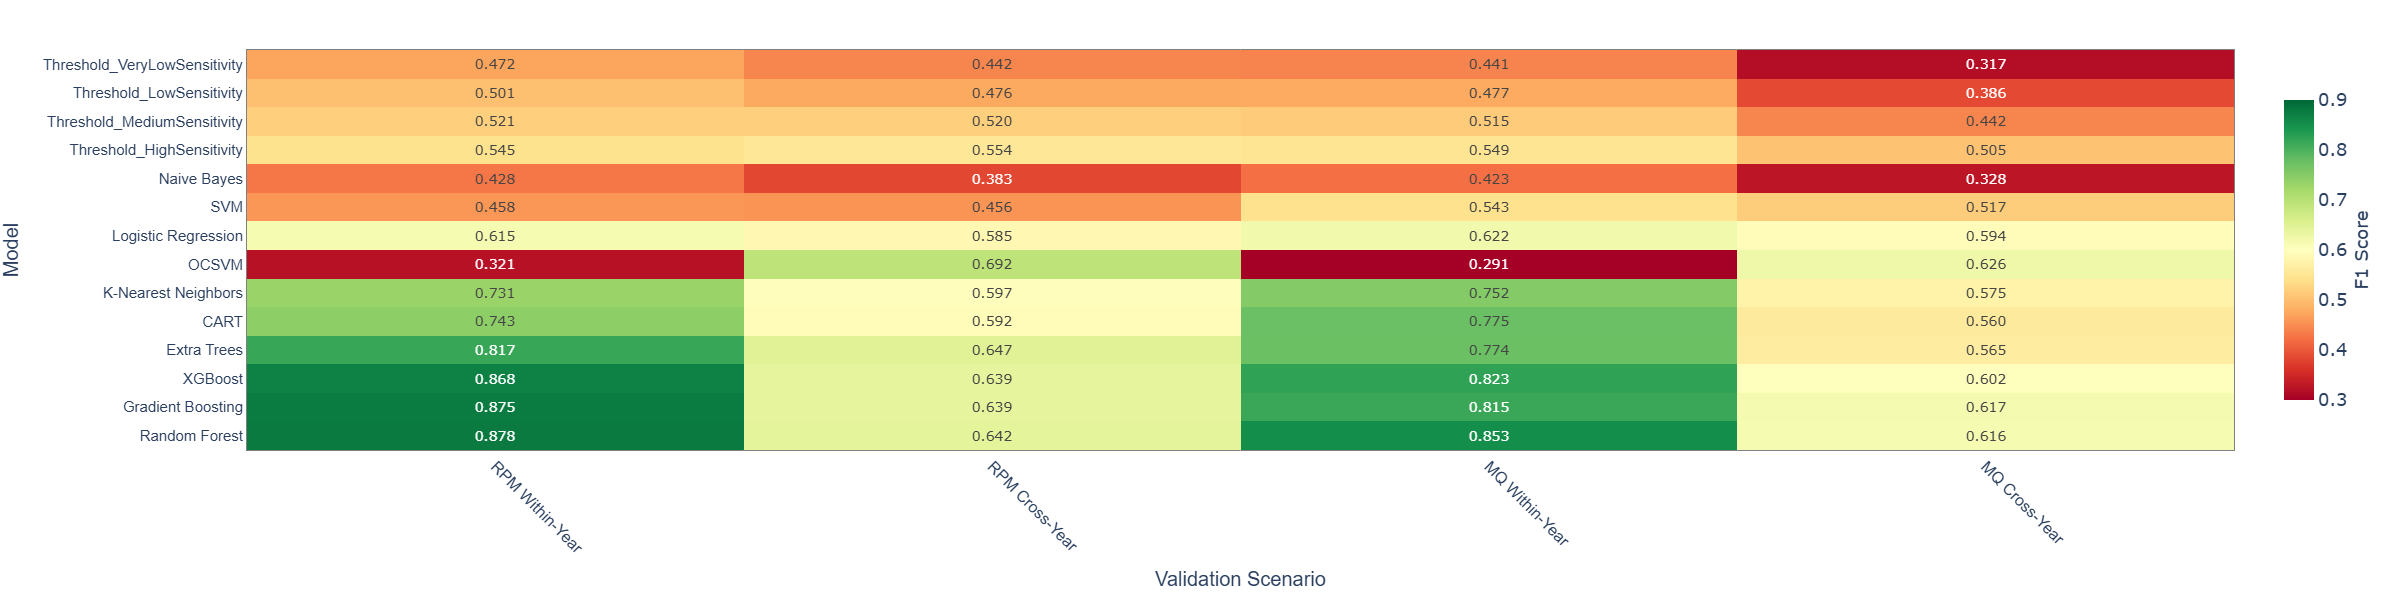

✓ Figure 3 saved: Figure3_Performance_Heatmap.svg


In [218]:
import plotly.graph_objects as go
import pandas as pd

# All 56 configurations data
all_results = pd.DataFrame({
    'model': ['Threshold_HighSensitivity', 'Threshold_HighSensitivity', 'Threshold_HighSensitivity', 'Threshold_HighSensitivity',
              'Threshold_MediumSensitivity', 'Threshold_MediumSensitivity', 'Threshold_MediumSensitivity', 'Threshold_MediumSensitivity',
              'Threshold_LowSensitivity', 'Threshold_LowSensitivity', 'Threshold_LowSensitivity', 'Threshold_LowSensitivity',
              'Threshold_VeryLowSensitivity', 'Threshold_VeryLowSensitivity', 'Threshold_VeryLowSensitivity', 'Threshold_VeryLowSensitivity',
              'Random Forest', 'Random Forest', 'Random Forest', 'Random Forest',
              'Extra Trees', 'Extra Trees', 'Extra Trees', 'Extra Trees',
              'XGBoost', 'XGBoost', 'XGBoost', 'XGBoost',
              'Gradient Boosting', 'Gradient Boosting', 'Gradient Boosting', 'Gradient Boosting',
              'Logistic Regression', 'Logistic Regression', 'Logistic Regression', 'Logistic Regression',
              'CART', 'CART', 'CART', 'CART',
              'K-Nearest Neighbors', 'K-Nearest Neighbors', 'K-Nearest Neighbors', 'K-Nearest Neighbors',
              'Naive Bayes', 'Naive Bayes', 'Naive Bayes', 'Naive Bayes',
              'SVM', 'SVM', 'SVM', 'SVM',
              'OCSVM', 'OCSVM', 'OCSVM', 'OCSVM'],
    'data_source': ['RPM', 'RPM', 'MQ', 'MQ'] * 14,
    'scenario': ['Within-Year', 'Cross-Year', 'Within-Year', 'Cross-Year'] * 14,
    'f1': [0.545, 0.554, 0.549, 0.505,
           0.521, 0.520, 0.515, 0.442,
           0.501, 0.476, 0.477, 0.386,
           0.472, 0.442, 0.441, 0.317,
           0.878, 0.642, 0.853, 0.616,
           0.817, 0.647, 0.774, 0.565,
           0.868, 0.639, 0.823, 0.602,
           0.875, 0.639, 0.815, 0.617,
           0.615, 0.585, 0.622, 0.594,
           0.743, 0.592, 0.775, 0.560,
           0.731, 0.597, 0.752, 0.575,
           0.428, 0.383, 0.423, 0.328,
           0.458, 0.456, 0.543, 0.517,
           0.321, 0.692, 0.291, 0.626]
})

# Create heatmap data
heatmap_data = all_results.copy()
heatmap_data['config'] = heatmap_data['data_source'] + ' ' + heatmap_data['scenario']

# Define model order (best performers first)
unique_models = ['Random Forest', 'Gradient Boosting', 'XGBoost', 'Extra Trees', 
                 'CART', 'K-Nearest Neighbors', 'OCSVM', 'Logistic Regression',
                 'SVM', 'Naive Bayes', 'Threshold_HighSensitivity',
                 'Threshold_MediumSensitivity', 'Threshold_LowSensitivity', 
                 'Threshold_VeryLowSensitivity']
configs = ['RPM Within-Year', 'RPM Cross-Year', 'MQ Within-Year', 'MQ Cross-Year']

# Build matrix
matrix = []
hover_text = []
for model in unique_models:
    row = []
    hover_row = []
    for config in configs:
        data_source, scenario = config.split(' ')
        value = heatmap_data[
            (heatmap_data['model'] == model) & 
            (heatmap_data['data_source'] == data_source) & 
            (heatmap_data['scenario'] == scenario)
        ]['f1'].values
        
        if len(value) > 0:
            row.append(value[0])
            hover_row.append(f"<b>{model}</b><br>{config}<br>F1: {value[0]:.3f}")
        else:
            row.append(0)
            hover_row.append("")
    matrix.append(row)
    hover_text.append(hover_row)

# Create figure
fig = go.Figure()

fig.add_trace(go.Heatmap(
    z=matrix,
    x=configs,
    y=unique_models,
    colorscale='RdYlGn',
    zmid=0.6,
    zmin=0.3,
    zmax=0.9,
    text=[[f"{val:.3f}" for val in row] for row in matrix],
    texttemplate="%{text}",
    textfont={"size": 14},
    hovertext=hover_text,
    hovertemplate='%{hovertext}<extra></extra>',
    colorbar=dict(
        title="F1 Score",
        titleside="right",
        titlefont=dict(size=18),
        tickmode="linear",
        tick0=0.3,
        dtick=0.1,
        tickfont=dict(size=18),
        len=0.8,
        x=1.02
    )
))

# Update layout
fig.update_layout(
    title=dict(
        # text='Comprehensive Model Performance Across All Validation Scenarios',
        font=dict(size=22, family='Arial', color='black'),
        x=0.5,
        xanchor='center'
    ),
    xaxis=dict(
        title='Validation Scenario',
        titlefont=dict(size=20, family='Arial'),
        tickfont=dict(size=16, family='Arial'),
        tickangle=45,
        side='bottom'
    ),
    yaxis=dict(
        title='Model',
        titlefont=dict(size=20, family='Arial'),
        tickfont=dict(size=15, family='Arial')
    ),
    plot_bgcolor='white',
    paper_bgcolor='white',
    width=800,
    height=600,
    margin=dict(l=200, r=120, t=50, b=150)
)

# Add axis lines
fig.update_xaxes(showline=True, linewidth=1, linecolor='gray', mirror=True)
fig.update_yaxes(showline=True, linewidth=1, linecolor='gray', mirror=True)

# Save
fig.write_image(r'data/', scale=20)
fig.show()

print("✓ Figure 3 saved: Figure3_Performance_Heatmap.svg")

### Results 3.1.2, 3.13

In [226]:
"""
Custom Diagnostic: Extract Results for Sections 3.1.2 and 3.1.3
================================================================
Tailored for B's actual data structure
"""

import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

print("="*80)
print("SECTION 3.1.2: TEMPORAL TRANSFERABILITY ASSESSMENT")
print("="*80)

# ============================================================================
# PART A: Confusion Matrices for Best Models
# ============================================================================

print("\n[CONFUSION MATRICES - Best Models]")
print("-"*80)

# 1. Random Forest (RPM Within-Year) - Best Overall
if 'pm_within_test' in globals():
    y_true = pm_within_test['temporal_grazing_label']
    y_pred = pm_within_test['RandomForest_pred']
    
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    print("\n1. Random Forest (RPM Within-Year) - Best Overall (F1 = 0.878):")
    print(f"   True Positives (TP):  {tp:4d}")
    print(f"   False Positives (FP): {fp:4d}")
    print(f"   True Negatives (TN):  {tn:4d}")
    print(f"   False Negatives (FN): {fn:4d}")
    print(f"   Total predictions:    {len(y_true)}")
    print(f"   Accuracy:             {(tp + tn) / len(y_true):.3f}")

# 2. OCSVM (RPM Cross-Year) - Best Transferability
if 'pm_cross_test' in globals():
    y_true = pm_cross_test['temporal_grazing_label']
    y_pred = pm_cross_test['OCSVM_pred']
    
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    print("\n2. OCSVM (RPM Cross-Year) - Best Transferability (F1 = 0.692):")
    print(f"   True Positives (TP):  {tp:4d}")
    print(f"   False Positives (FP): {fp:4d}")
    print(f"   True Negatives (TN):  {tn:4d}")
    print(f"   False Negatives (FN): {fn:4d}")
    print(f"   Total predictions:    {len(y_true)}")
    print(f"   Accuracy:             {(tp + tn) / len(y_true):.3f}")

# ============================================================================
# PART B: Comparison of Best Within vs Best Cross-Year
# ============================================================================

print("\n" + "="*80)
print("[PERFORMANCE COMPARISON]")
print("-"*80)

if 'pm_cross_test' in globals():
    # Random Forest on cross-year data (for comparison)
    y_true_cross = pm_cross_test['temporal_grazing_label']
    
    rf_cross_pred = pm_cross_test['RandomForest_pred']
    ocsvm_cross_pred = pm_cross_test['OCSVM_pred']
    
    rf_f1 = f1_score(y_true_cross, rf_cross_pred)
    ocsvm_f1 = f1_score(y_true_cross, ocsvm_cross_pred)
    
    print(f"\nCross-Year Performance (Year 2 Test Set, n={len(y_true_cross)}):")
    print(f"   Random Forest F1: {rf_f1:.3f}")
    print(f"   OCSVM F1:         {ocsvm_f1:.3f}")
    print(f"   Advantage:        {ocsvm_f1 - rf_f1:+.3f} (OCSVM better by {abs(ocsvm_f1 - rf_f1)*100:.1f}%)")

# ============================================================================
# PART C: All Models Cross-Year Performance Summary
# ============================================================================

print("\n" + "="*80)
print("[ALL MODELS CROSS-YEAR PERFORMANCE]")
print("-"*80)

if 'pm_cross_test' in globals():
    y_true = pm_cross_test['temporal_grazing_label']
    
    model_columns = [
        'RandomForest_pred', 'ExtraTrees_pred', 'XGBoost_pred', 
        'GradientBoosting_pred', 'LogisticRegression_pred', 'CART_pred',
        'K-NearestNeighbors_pred', 'NaiveBayes_pred', 'SVM_pred', 'OCSVM_pred'
    ]
    
    cross_year_results = []
    
    for model_col in model_columns:
        if model_col in pm_cross_test.columns:
            y_pred = pm_cross_test[model_col]
            
            f1 = f1_score(y_true, y_pred)
            prec = precision_score(y_true, y_pred, zero_division=0)
            rec = recall_score(y_true, y_pred)
            
            model_name = model_col.replace('_pred', '').replace('K-NearestNeighbors', 'KNN')
            
            cross_year_results.append({
                'Model': model_name,
                'Precision': prec,
                'Recall': rec,
                'F1': f1
            })
    
    cross_df = pd.DataFrame(cross_year_results).sort_values('F1', ascending=False)
    
    print("\nAll Models (RPM Cross-Year, sorted by F1):")
    print(cross_df.to_string(index=False, float_format='%.3f'))

print("\n" + "="*80)
print("SECTION 3.1.3: FARM-LEVEL DETECTION VARIABILITY")
print("="*80)

# ============================================================================
# PART A: Farm-Level F1 Scores
# ============================================================================

print("\n[FARM-LEVEL PERFORMANCE]")
print("-"*80)

if 'pm_cross_test' in globals():
    
    y_true_all = pm_cross_test['temporal_grazing_label']
    y_pred_all = pm_cross_test['OCSVM_pred']
    
    farm_performance = []
    
    for farm_code in sorted(pm_cross_test['Farm Code'].unique()):
        farm_data = pm_cross_test[pm_cross_test['Farm Code'] == farm_code]
        
        if len(farm_data) > 0:
            y_true = farm_data['temporal_grazing_label']
            y_pred = farm_data['OCSVM_pred']
            
            # Get region for this farm
            region = farm_data['Region'].iloc[0] if 'Region' in farm_data.columns else 'Unknown'
            farm_name = farm_data['FarmName'].iloc[0] if 'FarmName' in farm_data.columns else f'Farm {farm_code}'
            
            # Calculate metrics
            try:
                f1 = f1_score(y_true, y_pred, zero_division=0)
                prec = precision_score(y_true, y_pred, zero_division=0)
                rec = recall_score(y_true, y_pred, zero_division=0)
            except:
                f1 = prec = rec = 0.0
            
            n_obs = len(farm_data)
            n_grazed = sum(y_true)
            grazing_prev = n_grazed / n_obs if n_obs > 0 else 0
            
            farm_performance.append({
                'Farm_Code': farm_code,
                'Farm_Name': farm_name,
                'Region': region,
                'Observations': n_obs,
                'Grazed_Obs': n_grazed,
                'Prevalence': grazing_prev,
                'Precision': prec,
                'Recall': rec,
                'F1_Score': f1
            })
    
    farm_df = pd.DataFrame(farm_performance)
    farm_df = farm_df.sort_values('F1_Score', ascending=False)
    
    print(f"\nFarm-Level F1 Scores (OCSVM RPM Cross-Year, n={len(farm_df)} farms):")
    print(farm_df[['Farm_Code', 'Region', 'Observations', 'Grazed_Obs', 'F1_Score']].to_string(index=False, float_format='%.3f'))
    
    print("\n" + "-"*80)
    print("FARM PERFORMANCE SUMMARY:")
    print(f"   Best performing farm:  Farm {farm_df.iloc[0]['Farm_Code']} ({farm_df.iloc[0]['Region']}) - F1 = {farm_df.iloc[0]['F1_Score']:.3f}")
    print(f"   Worst performing farm: Farm {farm_df.iloc[-1]['Farm_Code']} ({farm_df.iloc[-1]['Region']}) - F1 = {farm_df.iloc[-1]['F1_Score']:.3f}")
    print(f"   Mean F1:               {farm_df['F1_Score'].mean():.3f}")
    print(f"   Median F1:             {farm_df['F1_Score'].median():.3f}")
    print(f"   Std F1:                {farm_df['F1_Score'].std():.3f}")
    print(f"   Range:                 {farm_df['F1_Score'].min():.3f} - {farm_df['F1_Score'].max():.3f}")
    print(f"   Coefficient of Var:    {farm_df['F1_Score'].std() / farm_df['F1_Score'].mean():.3f}")

# ============================================================================
# PART B: Regional Summary Statistics
# ============================================================================

print("\n" + "="*80)
print("[REGIONAL PERFORMANCE]")
print("-"*80)

if 'farm_df' in locals():
    regional_stats = farm_df.groupby('Region').agg({
        'F1_Score': ['count', 'mean', 'std', 'min', 'max'],
        'Observations': 'sum',
        'Grazed_Obs': 'sum'
    }).round(3)
    
    print("\nRegional Statistics (OCSVM RPM Cross-Year):")
    print(regional_stats)
    
    # Detailed breakdown
    print("\nDETAILED REGIONAL BREAKDOWN:")
    for region in sorted(farm_df['Region'].unique()):
        region_data = farm_df[farm_df['Region'] == region]
        print(f"\n{region}:")
        print(f"   Number of farms:      {len(region_data)}")
        print(f"   Mean F1:              {region_data['F1_Score'].mean():.3f} ± {region_data['F1_Score'].std():.3f}")
        print(f"   Median F1:            {region_data['F1_Score'].median():.3f}")
        print(f"   Range:                {region_data['F1_Score'].min():.3f} - {region_data['F1_Score'].max():.3f}")
        print(f"   Total observations:   {region_data['Observations'].sum()}")
        print(f"   Grazed observations:  {region_data['Grazed_Obs'].sum()}")
        print(f"   Grazing prevalence:   {region_data['Grazed_Obs'].sum() / region_data['Observations'].sum():.3f}")
        
        # List farms in this region
        farm_list = ', '.join([f"F{x}" for x in sorted(region_data['Farm_Code'])])
        print(f"   Farms:                {farm_list}")

# ============================================================================
# PART C: Export for Figure Creation
# ============================================================================

print("\n" + "="*80)
print("[DATA EXPORT FOR FIGURES]")
print("-"*80)

if 'farm_df' in locals():
    # Save farm-level data for Figure creation
    farm_df.to_csv(r'data/', index=False)
    print("\n✓ Saved: farm_level_performance.csv")
    print("  Columns: Farm_Code, Farm_Name, Region, Observations, Grazed_Obs, Prevalence, Precision, Recall, F1_Score")
    print(f"  Use this for creating Figure 4 (farm-level variability)")

print("\n" + "="*80)
print("DIAGNOSTIC COMPLETE")
print("="*80)

SECTION 3.1.2: TEMPORAL TRANSFERABILITY ASSESSMENT

[CONFUSION MATRICES - Best Models]
--------------------------------------------------------------------------------

1. Random Forest (RPM Within-Year) - Best Overall (F1 = 0.878):
   True Positives (TP):   878
   False Positives (FP):   58
   True Negatives (TN):   953
   False Negatives (FN):  186
   Total predictions:    2075
   Accuracy:             0.882

2. OCSVM (RPM Cross-Year) - Best Transferability (F1 = 0.692):
   True Positives (TP):   406
   False Positives (FP):  260
   True Negatives (TN):   103
   False Negatives (FN):  102
   Total predictions:    871
   Accuracy:             0.584

[PERFORMANCE COMPARISON]
--------------------------------------------------------------------------------

Cross-Year Performance (Year 2 Test Set, n=871):
   Random Forest F1: 0.642
   OCSVM F1:         0.692
   Advantage:        +0.049 (OCSVM better by 4.9%)

[ALL MODELS CROSS-YEAR PERFORMANCE]
-------------------------------------------

### Figure 4 Code: Farm-Level Detection Variability

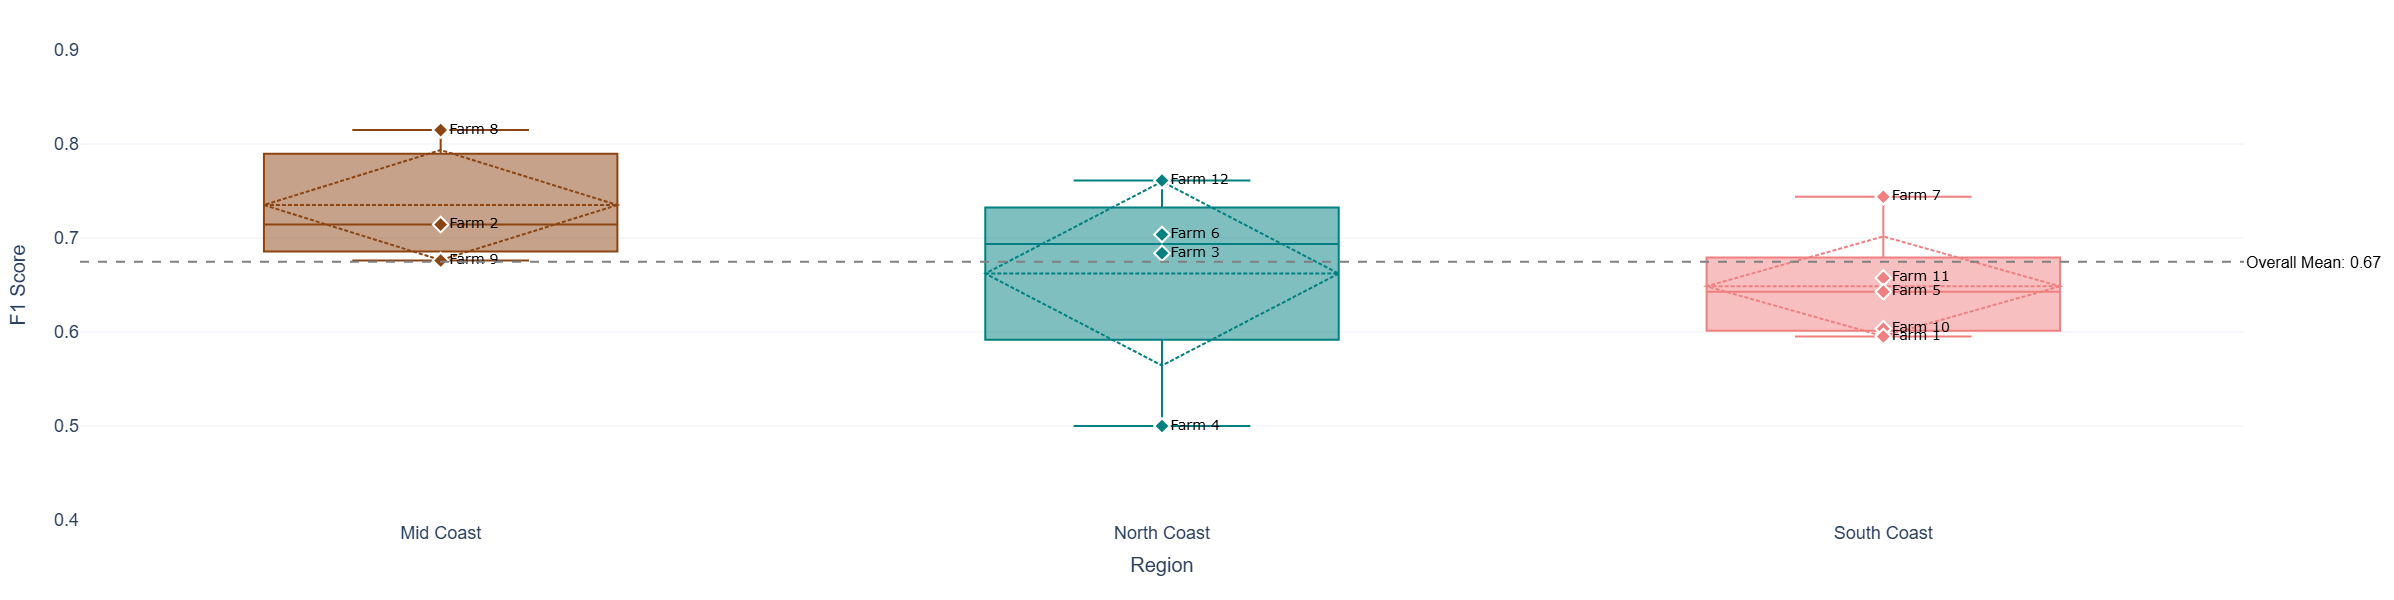

✓ Figure 4 saved: Figure4_Farm_Level_Variability.svg


In [259]:
import plotly.graph_objects as go
import pandas as pd

# Load farm-level data
farm_df = pd.read_csv(r'data/')

# Create farm name to number mapping
farm_mapping = {
    'Apps': 'Farm 1',
    'Bale': 'Farm 2',
    'Behrens': 'Farm 3',
    'Clarke': 'Farm 4',
    'Game': 'Farm 5',
    'Gould': 'Farm 6',
    'Holmes': 'Farm 7',
    'Neilson': 'Farm 8',
    'Nicholson': 'Farm 9',
    'Russell': 'Farm 10',
    'Ryan': 'Farm 11',
    'Tonge': 'Farm 12'
}

# Apply mapping to anonymize farm names
farm_df['Farm_ID'] = farm_df['Farm_Code'].map(farm_mapping)

# Sort by F1 score within each region
farm_df = farm_df.sort_values(['Region', 'F1_Score'], ascending=[True, False])

# # Define colors for regions
# region_colors = {
#     'Mid Coast': '#8B4513',      # Brown
#     'North Coast': '#2E8B57',    # Sea green
#     'South Coast': '#4682B4'     # Steel blue
# }

# Define colors for regions
region_colors = {
    'Mid Coast': '#8B4513',      # Brown
    'North Coast': 'teal',    # Sea green
    'South Coast': 'lightcoral'     # Steel blue
}

# Create figure
fig = go.Figure()

# Add box plot for each region
regions = ['Mid Coast', 'North Coast', 'South Coast']

for region in regions:
    region_data = farm_df[farm_df['Region'] == region]
    
    fig.add_trace(go.Box(
        y=region_data['F1_Score'],
        x=[region] * len(region_data),
        name=region,
        marker_color=region_colors[region],
        boxmean='sd',  # Show mean and SD
        marker=dict(size=10, opacity=0.7),
        line=dict(width=2),
        customdata=region_data[['Farm_ID', 'Observations']],
        hovertemplate='<b>%{customdata[0]}</b><br>' +
                     'F1 Score: %{y:.3f}<br>' +
                     'Observations: %{customdata[1]}<br>' +
                     '<extra></extra>'
    ))
    
    # Add individual farm points with labels
    fig.add_trace(go.Scatter(
        y=region_data['F1_Score'],
        x=[region] * len(region_data),
        mode='markers+text',
        marker=dict(
            size=12,
            color=region_colors[region],
            symbol='diamond',
            line=dict(width=2, color='white')
        ),
        text=region_data['Farm_ID'],
        textposition='middle right',
        textfont=dict(size=14, color='black'),
        showlegend=False,
        hovertemplate='<b>%{text}</b><br>' +
                     'F1: %{y:.3f}<extra></extra>'
    ))

# Add overall mean line
overall_mean = farm_df['F1_Score'].mean()
fig.add_hline(
    y=overall_mean, 
    line_dash="dash", 
    line_color="gray",
    annotation=dict(
        text=f"Overall Mean: {overall_mean:.2f}",
        font=dict(size=16, family='Arial', color='black')
    ),
    annotation_position="right"
)

# Update layout
fig.update_layout(
    template='plotly_white',
    title=dict(
        # text='Farm-Level Detection Performance Across Regions',
        font=dict(size=22, family='Arial', color='black'),
        x=0.5,
        xanchor='center'
    ),
    xaxis=dict(
        title='Region',
        titlefont=dict(size=20, family='Arial'),
        tickfont=dict(size=18, family='Arial')
    ),
    yaxis=dict(
        title='F1 Score',
        titlefont=dict(size=20, family='Arial'),
        tickfont=dict(size=18, family='Arial'),
        range=[0.40, 0.9]
    ),
    showlegend=False,
    width=650,
    height=600,
    margin=dict(l=80, r=150, t=50, b=80)
)

# Save
fig.write_image(r'data/', scale=20)
fig.show()

print("✓ Figure 4 saved: Figure4_Farm_Level_Variability.svg")

### Diagnostic section for 3.2

In [270]:
"""
Diagnostic: Extract Additional Details for Section 3.2
=======================================================
Extract farm-level breakdown, seasonal patterns, etc. for PU agreement analysis
"""

import pandas as pd
import numpy as np
from scipy.stats import pearsonr

print("="*80)
print("SECTION 3.2: BIOMASS AND UTILISATION AGREEMENT - ADDITIONAL ANALYSIS")
print("="*80)

if 'matched_pu' not in globals() or len(matched_pu) == 0:
    print("\n⚠ No matched_pu data available")
    print("  Run Block 10 Part B first")
else:
    print(f"\nAnalyzing {len(matched_pu)} matched events...")
    
    # Check what columns we have
    cols = matched_pu.columns.tolist()
    print(f"\nAvailable columns: {len(cols)}")
    
    # Detect column naming scheme
    if 'pm_pre_grazing' in cols:
        # Already renamed (from Block 10)
        pm_pre = 'pm_pre_grazing'
        pm_post = 'pm_post_grazing'
        pm_removal = 'pm_removal'
        pm_util = 'pm_utilization'
        mq_pre = 'sent_pre_grazing'
        mq_post = 'sent_post_grazing'
        mq_removal = 'sent_removal'
        mq_util = 'sent_utilization'
    elif 'pre_grazing_pm' in cols:
        # Original Block 10 naming (before rename)
        pm_pre = 'pre_grazing_pm'
        pm_post = 'post_grazing_pm'
        pm_removal = 'removal_pm'
        pm_util = 'utilization_rate_pm'
        mq_pre = 'pre_grazing_mq'
        mq_post = 'post_grazing_mq'
        mq_removal = 'removal_mq'
        mq_util = 'utilization_rate_mq'
    else:
        print("\n⚠ Cannot detect column naming scheme")
        print("  Available columns:", cols)
        import sys
        sys.exit()
    
    # ========================================================================
    # BASIC DESCRIPTIVE STATISTICS
    # ========================================================================
    
    print("\n" + "-"*80)
    print("DESCRIPTIVE STATISTICS")
    print("-"*80)
    
    print("\nPM (Rising Plate Meter):")
    print(f"  Pre-grazing:  {matched_pu[pm_pre].mean():.0f} ± {matched_pu[pm_pre].std():.0f} kg/ha")
    print(f"    Range: {matched_pu[pm_pre].min():.0f} - {matched_pu[pm_pre].max():.0f} kg/ha")
    print(f"  Post-grazing: {matched_pu[pm_post].mean():.0f} ± {matched_pu[pm_post].std():.0f} kg/ha")
    print(f"    Range: {matched_pu[pm_post].min():.0f} - {matched_pu[pm_post].max():.0f} kg/ha")
    print(f"  Removal:      {matched_pu[pm_removal].mean():.0f} ± {matched_pu[pm_removal].std():.0f} kg/ha")
    print(f"    Range: {matched_pu[pm_removal].min():.0f} - {matched_pu[pm_removal].max():.0f} kg/ha")
    print(f"  Utilization:  {matched_pu[pm_util].mean():.1f} ± {matched_pu[pm_util].std():.1f} %")
    print(f"    Range: {matched_pu[pm_util].min():.1f} - {matched_pu[pm_util].max():.1f} %")
    
    print("\nMQ (Satellite):")
    print(f"  Pre-grazing:  {matched_pu[mq_pre].mean():.0f} ± {matched_pu[mq_pre].std():.0f} kg/ha")
    print(f"    Range: {matched_pu[mq_pre].min():.0f} - {matched_pu[mq_pre].max():.0f} kg/ha")
    print(f"  Post-grazing: {matched_pu[mq_post].mean():.0f} ± {matched_pu[mq_post].std():.0f} kg/ha")
    print(f"    Range: {matched_pu[mq_post].min():.0f} - {matched_pu[mq_post].max():.0f} kg/ha")
    print(f"  Removal:      {matched_pu[mq_removal].mean():.0f} ± {matched_pu[mq_removal].std():.0f} kg/ha")
    print(f"    Range: {matched_pu[mq_removal].min():.0f} - {matched_pu[mq_removal].max():.0f} kg/ha")
    print(f"  Utilization:  {matched_pu[mq_util].mean():.1f} ± {matched_pu[mq_util].std():.1f} %")
    print(f"    Range: {matched_pu[mq_util].min():.1f} - {matched_pu[mq_util].max():.1f} %")
    
    # ========================================================================
    # BLAND-ALTMAN ANALYSIS
    # ========================================================================
    
    print("\n" + "="*80)
    print("BLAND-ALTMAN ANALYSIS")
    print("="*80)
    
    # Calculate differences and means for each metric
    metrics = {
        'Pre-grazing': (pm_pre, mq_pre),
        'Post-grazing': (pm_post, mq_post),
        'Removal': (pm_removal, mq_removal),
        'Utilization': (pm_util, mq_util)
    }
    
    bland_altman_stats = {}
    
    for metric_name, (pm_col, mq_col) in metrics.items():
        # Calculate differences (MQ - PM)
        diff = matched_pu[mq_col] - matched_pu[pm_col]
        mean_val = (matched_pu[pm_col] + matched_pu[mq_col]) / 2
        
        # Bland-Altman statistics
        bias = diff.mean()
        sd = diff.std()
        loa_upper = bias + 1.96 * sd
        loa_lower = bias - 1.96 * sd
        
        bland_altman_stats[metric_name] = {
            'bias': bias,
            'sd': sd,
            'loa_upper': loa_upper,
            'loa_lower': loa_lower,
            'n': len(diff)
        }
        
        print(f"\n{metric_name}:")
        print(f"  Bias (MQ - PM):           {bias:+.1f}")
        print(f"  SD of differences:        {sd:.1f}")
        print(f"  95% Limits of Agreement:  [{loa_lower:.1f}, {loa_upper:.1f}]")
        print(f"  Range of differences:     [{diff.min():.1f}, {diff.max():.1f}]")
    
    # ========================================================================
    # FARM-LEVEL BREAKDOWN
    # ========================================================================
    
    print("\n" + "="*80)
    print("FARM-LEVEL AGREEMENT")
    print("="*80)
    
    # Create farm mapping if not exists
    if 'farm_id_mapping' in globals():
        matched_pu['farm_id'] = matched_pu['farm_code'].map(farm_id_mapping)
    else:
        # Create temp mapping
        unique_farms = sorted(matched_pu['farm_code'].unique())
        temp_mapping = {farm: f"Farm {i+1}" for i, farm in enumerate(unique_farms)}
        matched_pu['farm_id'] = matched_pu['farm_code'].map(temp_mapping)
    
    farm_summary = []
    
    for farm_id in sorted(matched_pu['farm_id'].unique()):
        farm_data = matched_pu[matched_pu['farm_id'] == farm_id]
        
        if len(farm_data) >= 3:  # Need at least 3 points for correlation
            # Removal agreement
            removal_r, removal_p = pearsonr(farm_data['pm_removal'], farm_data['sent_removal'])
            removal_rmse = np.sqrt(np.mean((farm_data['sent_removal'] - farm_data['pm_removal'])**2))
            removal_bias = (farm_data['sent_removal'] - farm_data['pm_removal']).mean()
            
            farm_summary.append({
                'Farm': farm_id,
                'N_Events': len(farm_data),
                'Removal_r': removal_r,
                'Removal_RMSE': removal_rmse,
                'Removal_Bias': removal_bias,
                'PM_Removal_Mean': farm_data['pm_removal'].mean(),
                'MQ_Removal_Mean': farm_data['sent_removal'].mean()
            })
    
    if farm_summary:
        farm_df = pd.DataFrame(farm_summary).sort_values('N_Events', ascending=False)
        
        print(f"\nFarm-Level Removal Agreement (farms with ≥3 events):")
        print(farm_df[['Farm', 'N_Events', 'Removal_r', 'Removal_RMSE', 'Removal_Bias']].to_string(
            index=False, 
            float_format=lambda x: f'{x:.3f}' if abs(x) < 10 else f'{x:.0f}'
        ))
        
        print(f"\nFarm-Level Summary:")
        print(f"  Farms with data:         {len(farm_df)}")
        print(f"  Events per farm (mean):  {farm_df['N_Events'].mean():.1f}")
        print(f"  Events per farm (range): {farm_df['N_Events'].min():.0f} - {farm_df['N_Events'].max():.0f}")
        print(f"  Mean farm correlation:   {farm_df['Removal_r'].mean():.3f}")
        print(f"  Mean farm RMSE:          {farm_df['Removal_RMSE'].mean():.0f} kg/ha")
    
    # ========================================================================
    # UTILISATION CATEGORIES
    # ========================================================================
    
    print("\n" + "="*80)
    print("AGREEMENT BY UTILISATION LEVEL")
    print("="*80)
    
    # Categorize by PM utilization rate
    matched_pu['util_category'] = pd.cut(
        matched_pu['pm_utilization'],
        bins=[0, 10, 20, 100],
        labels=['Low (<10%)', 'Medium (10-20%)', 'High (>20%)']
    )
    
    print("\nAgreement by Utilisation Category:")
    for category in ['Low (<10%)', 'Medium (10-20%)', 'High (>20%)']:
        cat_data = matched_pu[matched_pu['util_category'] == category]
        
        if len(cat_data) >= 3:
            r, p = pearsonr(cat_data['pm_removal'], cat_data['sent_removal'])
            rmse = np.sqrt(np.mean((cat_data['sent_removal'] - cat_data['pm_removal'])**2))
            bias = (cat_data['sent_removal'] - cat_data['pm_removal']).mean()
            
            print(f"\n  {category} (n={len(cat_data)}):")
            print(f"    Correlation: r={r:.3f}")
            print(f"    RMSE: {rmse:.0f} kg/ha")
            print(f"    Bias: {bias:+.0f} kg/ha")
            print(f"    PM removal:  {cat_data['pm_removal'].mean():.0f} ± {cat_data['pm_removal'].std():.0f} kg/ha")
            print(f"    MQ removal:  {cat_data['sent_removal'].mean():.0f} ± {cat_data['sent_removal'].std():.0f} kg/ha")
    
    # ========================================================================
    # TEMPORAL DISTRIBUTION
    # ========================================================================
    
    print("\n" + "="*80)
    print("TEMPORAL DISTRIBUTION")
    print("="*80)
    
    # Add year and season if not present
    matched_pu['year'] = matched_pu['event_start'].dt.year
    matched_pu['month'] = matched_pu['event_start'].dt.month
    
    # Define seasons
    def get_season(month):
        if month in [12, 1, 2]:
            return 'Summer'
        elif month in [3, 4, 5]:
            return 'Autumn'
        elif month in [6, 7, 8]:
            return 'Winter'
        else:
            return 'Spring'
    
    matched_pu['season'] = matched_pu['month'].apply(get_season)
    
    print("\nEvents by Year:")
    for year in sorted(matched_pu['year'].unique()):
        count = len(matched_pu[matched_pu['year'] == year])
        print(f"  {year}: {count} events ({count/len(matched_pu)*100:.1f}%)")
    
    print("\nEvents by Season:")
    for season in ['Summer', 'Autumn', 'Winter', 'Spring']:
        count = len(matched_pu[matched_pu['season'] == season])
        print(f"  {season}: {count:3d} events ({count/len(matched_pu)*100:.1f}%)")
    
    # ========================================================================
    # EXPORT DATA FOR FIGURES
    # ========================================================================
    
    print("\n" + "="*80)
    print("DATA EXPORT")
    print("="*80)
    
     # Save matched_pu with all calculations for figure creation
    matched_pu.to_csv(r'data/', index=False)
    print("\n✓ Saved: pu_agreement_data.csv")
    print(f"  Contains {len(matched_pu)} matched events with all metrics")
    
    # Save bland-altman stats
    ba_df = pd.DataFrame(bland_altman_stats).T
    ba_df.to_csv(r'data/')
    print("✓ Saved: bland_altman_stats.csv")
    
    if farm_summary:
        farm_df.to_csv(r'data/', index=False)
        print("✓ Saved: farm_removal_agreement.csv")
    
    print("\n" + "="*80)
    print("DIAGNOSTIC COMPLETE")
    print("="*80)

SECTION 3.2: BIOMASS AND UTILISATION AGREEMENT - ADDITIONAL ANALYSIS

Analyzing 218 matched events...

Available columns: 22

--------------------------------------------------------------------------------
DESCRIPTIVE STATISTICS
--------------------------------------------------------------------------------

PM (Rising Plate Meter):
  Pre-grazing:  2913 ± 422 kg/ha
    Range: 1632 - 3720 kg/ha
  Post-grazing: 2539 ± 461 kg/ha
    Range: 1402 - 3356 kg/ha
  Removal:      374 ± 274 kg/ha
    Range: 19 - 1279 kg/ha
  Utilization:  12.8 ± 9.1 %
    Range: 0.7 - 45.3 %

MQ (Satellite):
  Pre-grazing:  2934 ± 417 kg/ha
    Range: 1679 - 3720 kg/ha
  Post-grazing: 2536 ± 459 kg/ha
    Range: 1402 - 3342 kg/ha
  Removal:      398 ± 286 kg/ha
    Range: 29 - 1584 kg/ha
  Utilization:  13.6 ± 9.3 %
    Range: 1.1 - 47.9 %

BLAND-ALTMAN ANALYSIS

Pre-grazing:
  Bias (MQ - PM):           +20.3
  SD of differences:        77.9
  95% Limits of Agreement:  [-132.3, 172.9]
  Range of differences:   

### Figure 5: Bland-Altman Plot for Biomass Removal

Available columns: ['farm_code', 'pcode', 'event_start', 'event_end_pm', 'duration_days_pm', 'pre_date_pm', 'post_date_pm', 'pm_pre_grazing', 'pm_post_grazing', 'pm_removal', 'pm_utilization', 'dataset_pm', 'event_end_mq', 'duration_days_mq', 'pre_date_mq', 'post_date_mq', 'sent_pre_grazing', 'sent_post_grazing', 'sent_removal', 'sent_utilization', 'dataset_mq', 'days_difference', 'farm_id', 'util_category', 'year', 'month', 'season']


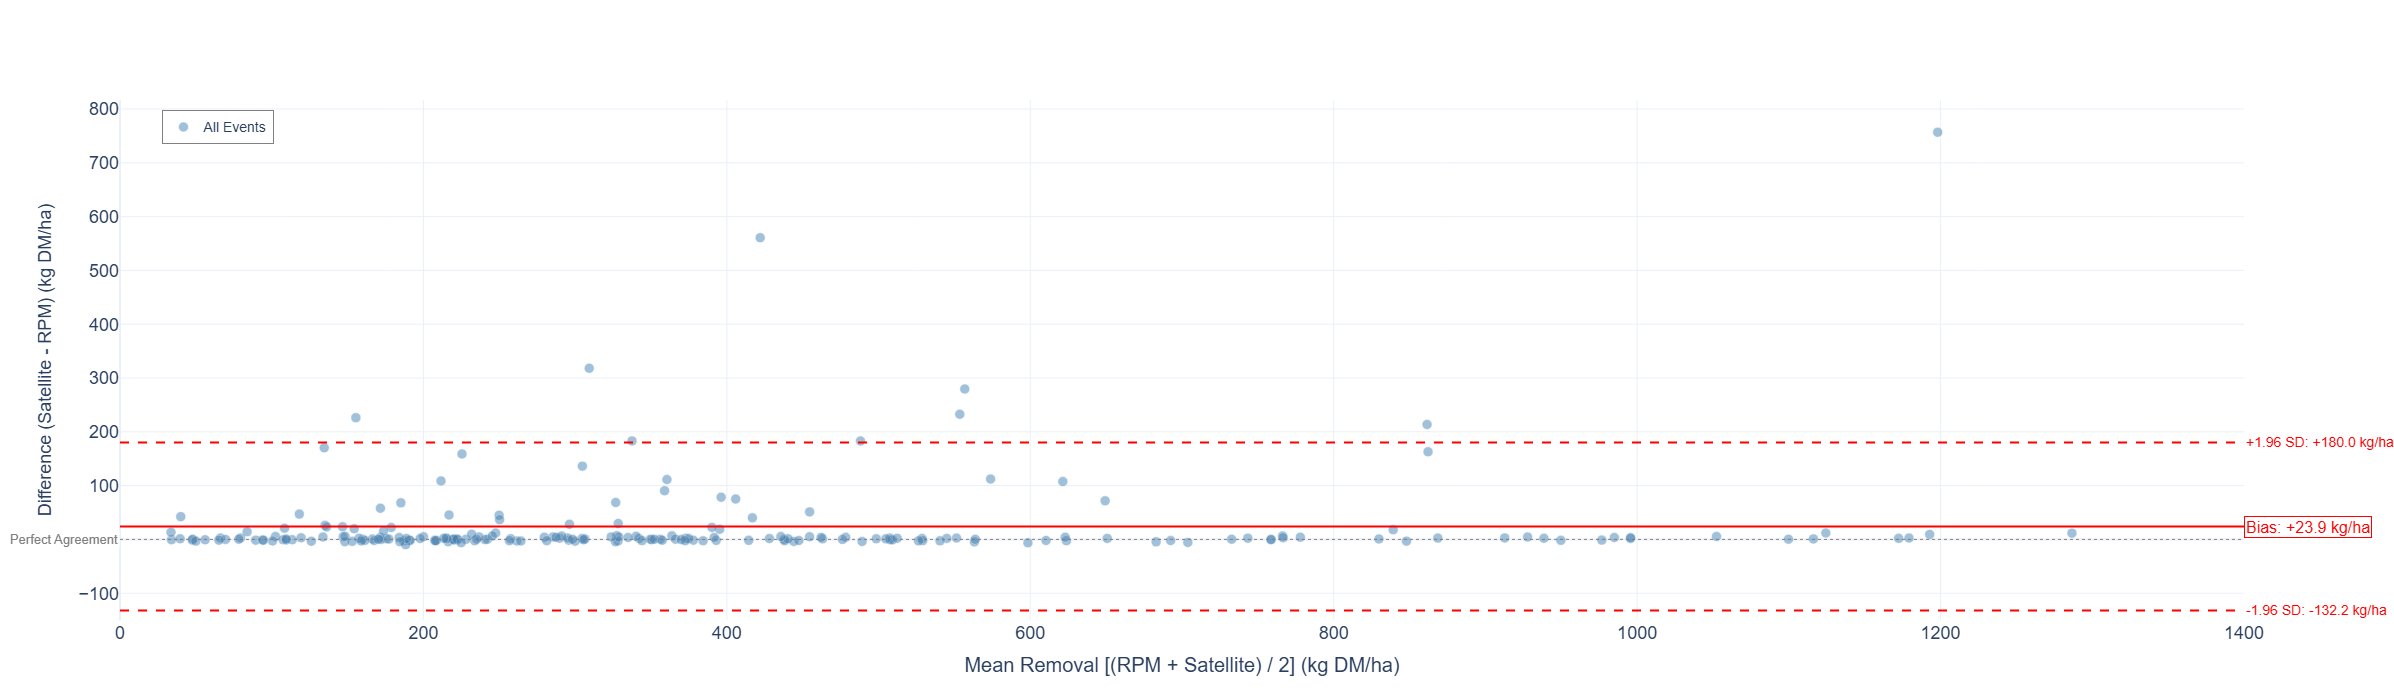

✓ Figure 5 saved: Figure5_Bland_Altman_Removal.svg
  Bias: +23.9 kg/ha
  95% LoA: [-132.2, 180.0] kg/ha
  n = 218 events


In [284]:
import plotly.graph_objects as go
import pandas as pd
import numpy as np

# Load data
matched_pu = pd.read_csv(r'data/')

# Check what columns exist and parse dates if needed
print("Available columns:", matched_pu.columns.tolist())

# Parse event_start if it exists (may have different name)
if 'event_start' in matched_pu.columns:
    matched_pu['event_start'] = pd.to_datetime(matched_pu['event_start'])
elif 'event_start_pm' in matched_pu.columns:
    matched_pu['event_start'] = pd.to_datetime(matched_pu['event_start_pm'])

# Calculate Bland-Altman metrics
matched_pu['removal_mean'] = (matched_pu['pm_removal'] + matched_pu['sent_removal']) / 2
matched_pu['removal_diff'] = matched_pu['sent_removal'] - matched_pu['pm_removal']

# Bland-Altman statistics
bias = matched_pu['removal_diff'].mean()
sd = matched_pu['removal_diff'].std()
loa_upper = bias + 1.96 * sd
loa_lower = bias - 1.96 * sd

# Farm mapping
farm_mapping = {
    'Apps': 'Farm 1', 'Bale': 'Farm 2', 'Behrens': 'Farm 3',
    'Clarke': 'Farm 4', 'Game': 'Farm 5', 'Gould': 'Farm 6',
    'Holmes': 'Farm 7', 'Neilson': 'Farm 8', 'Nicholson': 'Farm 9',
    'Russell': 'Farm 10', 'Ryan': 'Farm 11', 'Tonge': 'Farm 12'
}
matched_pu['farm_id'] = matched_pu['farm_code'].map(farm_mapping)

# Region colors (get from your data if available, or use defaults)
region_colors = {
    'Mid Coast': '#8B4513',      # Brown
    'North Coast': '#2E8B57',    # Sea green  
    'South Coast': '#4682B4'     # Steel blue
}

# Create figure
fig = go.Figure()

# Add small jitter to separate overlapping points (helps visualize density)
np.random.seed(42)  # Reproducible jitter

# Add points colored by region (if region column exists)
if 'region' in matched_pu.columns:
    for region in ['Mid Coast', 'North Coast', 'South Coast']:
        region_data = matched_pu[matched_pu['region'] == region]
        
        if len(region_data) > 0:
            # Add jitter to x and y for better visualization of overlapping points
            x_jitter = np.random.normal(0, 5, len(region_data))  # ±5 kg/ha horizontal jitter
            y_jitter = np.random.normal(0, 3, len(region_data))  # ±3 kg/ha vertical jitter
            
            fig.add_trace(go.Scatter(
                x=region_data['removal_mean'] + x_jitter,
                y=region_data['removal_diff'] + y_jitter,
                mode='markers',
                marker=dict(
                    color=region_colors[region],
                    size=10,
                    opacity=0.5,  # Semi-transparent to show overlapping points
                    line=dict(width=0.5, color='white')
                ),
                name=region,
                hovertemplate='<b>%{customdata}</b><br>' +
                             'Mean: %{x:.0f} kg/ha<br>' +
                             'Difference: %{y:.0f} kg/ha<br>' +
                             '<extra></extra>',
                customdata=region_data['farm_id']
            ))
else:
    # Fallback if no region column
    x_jitter = np.random.normal(0, 5, len(matched_pu))
    y_jitter = np.random.normal(0, 3, len(matched_pu))
    
    fig.add_trace(go.Scatter(
        x=matched_pu['removal_mean'] + x_jitter,
        y=matched_pu['removal_diff'] + y_jitter,
        mode='markers',
        marker=dict(
            color='steelblue',
            size=10,
            opacity=0.5,
            line=dict(width=0.5, color='white')
        ),
        name='All Events',
        hovertemplate='Mean: %{x:.0f} kg/ha<br>' +
                     'Difference: %{y:.0f} kg/ha<br>' +
                     '<extra></extra>'
    ))

# Add bias line (mean difference)
fig.add_hline(
    y=bias,
    line=dict(color='red', width=2, dash='solid'),
    annotation=dict(
        text=f'Bias: +{bias:.1f} kg/ha',
        font=dict(size=16, color='red', family='Arial'),
        bgcolor='white',
        bordercolor='red',
        borderwidth=1
    ),
    annotation_position='right'
)

# Add upper LoA
fig.add_hline(
    y=loa_upper,
    line=dict(color='red', width=2, dash='dash'),
    annotation=dict(
        text=f'+1.96 SD: +{loa_upper:.1f} kg/ha',
        font=dict(size=14, color='red', family='Arial'),
        bgcolor='white'
    ),
    annotation_position='right'
)

# Add lower LoA
fig.add_hline(
    y=loa_lower,
    line=dict(color='red', width=2, dash='dash'),
    annotation=dict(
        text=f'-1.96 SD: {loa_lower:.1f} kg/ha',
        font=dict(size=14, color='red', family='Arial'),
        bgcolor='white'
    ),
    annotation_position='right'
)

# Add zero reference line
fig.add_hline(
    y=0,
    line=dict(color='gray', width=1, dash='dot'),
    annotation=dict(
        text='Perfect Agreement',
        font=dict(size=13, color='gray', family='Arial'),
        bgcolor='white'
    ),
    annotation_position='left'
)

# Update layout
fig.update_layout(
    template='plotly_white',
    title=dict(
        # text='Bland-Altman Analysis: Biomass Removal Agreement',
        font=dict(size=22, family='Arial', color='black'),
        x=0.5,
        xanchor='center'
    ),
    xaxis=dict(
        title='Mean Removal [(RPM + Satellite) / 2] (kg DM/ha)',
        titlefont=dict(size=20, family='Arial'),
        tickfont=dict(size=18, family='Arial'),
        range=[0, 1400]
    ),
    yaxis=dict(
        title='Difference (Satellite - RPM) (kg DM/ha)',
        titlefont=dict(size=18, family='Arial'),
        tickfont=dict(size=18, family='Arial'),
        zeroline=True
    ),
    showlegend=True,
    legend=dict(
        font=dict(size=14, family='Arial'),
        orientation='v',
        yanchor='top',
        y=0.98,
        xanchor='left',
        x=0.02,
        bgcolor='rgba(255,255,255,0.8)',
        bordercolor='gray',
        borderwidth=1
    ),
    width=700,
    height=700,
    margin=dict(l=120, r=150, t=100, b=80)
)

# Save
fig.write_image(r'data/', scale=20)
fig.show()

print("✓ Figure 5 saved: Figure5_Bland_Altman_Removal.svg")
print(f"  Bias: +{bias:.1f} kg/ha")
print(f"  95% LoA: [{loa_lower:.1f}, {loa_upper:.1f}] kg/ha")
print(f"  n = {len(matched_pu)} events")

### Figure 6: Farm-Level Removal Scatter Plot

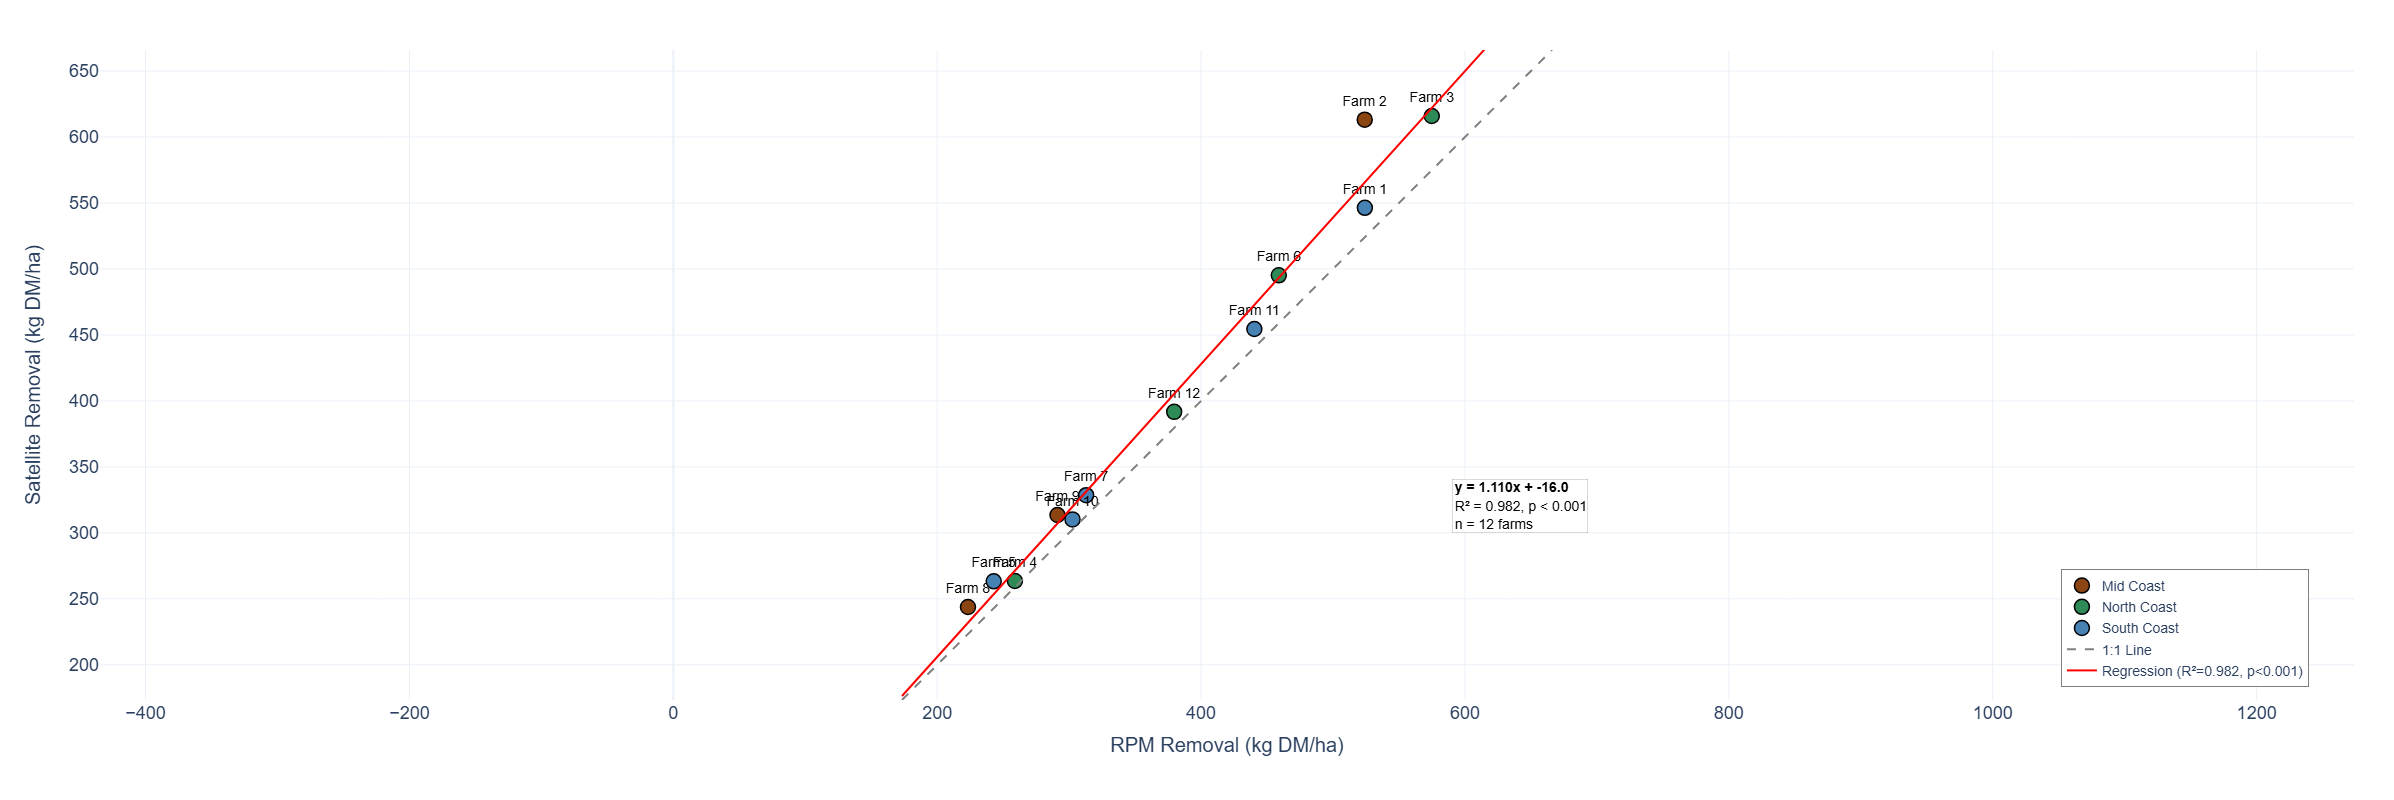

✓ Figure 6 saved: Figure6_Farm_Removal_Scatter.svg
  Farms shown: 12
  R²: 0.982, p=0.0000
  Regression: y = 1.110x + -16.0


In [317]:
import plotly.graph_objects as go
import pandas as pd
import numpy as np
from scipy.stats import pearsonr, linregress

# Load data
matched_pu = pd.read_csv(r'data/')


# Farm mapping
farm_mapping = {
    'Apps': 'Farm 1', 'Bale': 'Farm 2', 'Behrens': 'Farm 3',
    'Clarke': 'Farm 4', 'Game': 'Farm 5', 'Gould': 'Farm 6',
    'Holmes': 'Farm 7', 'Neilson': 'Farm 8', 'Nicholson': 'Farm 9',
    'Russell': 'Farm 10', 'Ryan': 'Farm 11', 'Tonge': 'Farm 12'
}

# Region mapping
region_mapping = {
    'Apps': 'South Coast', 'Bale': 'Mid Coast', 'Behrens': 'North Coast',
    'Clarke': 'North Coast', 'Game': 'South Coast', 'Gould': 'North Coast',
    'Holmes': 'South Coast', 'Neilson': 'Mid Coast', 'Nicholson': 'Mid Coast',
    'Russell': 'South Coast', 'Ryan': 'South Coast', 'Tonge': 'North Coast'
}

matched_pu['farm_id'] = matched_pu['farm_code'].map(farm_mapping)
if 'region' not in matched_pu.columns:
    matched_pu['region'] = matched_pu['farm_code'].map(region_mapping)

# Calculate farm-level averages
farm_avg = matched_pu.groupby('farm_code').agg({
    'pm_removal': 'mean',
    'sent_removal': 'mean'
}).reset_index()

farm_avg['farm_id'] = farm_avg['farm_code'].map(farm_mapping)
farm_avg['region'] = farm_avg['farm_code'].map(region_mapping)

# Regional colors
region_colors = {
    'Mid Coast': '#8B4513',      # Brown
    'North Coast': '#2E8B57',    # Sea green
    'South Coast': '#4682B4'     # Steel blue
}

# Create figure
fig = go.Figure()

# Add scatter by region with farm labels
for region in ['Mid Coast', 'North Coast', 'South Coast']:
    region_data = farm_avg[farm_avg['region'] == region]
    
    if len(region_data) > 0:
        fig.add_trace(go.Scatter(
            x=region_data['pm_removal'],
            y=region_data['sent_removal'],
            mode='markers+text',
            marker=dict(
                color=region_colors[region],
                size=15,
                line=dict(color='black', width=1.5),
                symbol='circle'
            ),
            text=region_data['farm_id'],
            textposition='top center',
            textfont=dict(size=14, color='black', family='Arial'),
            name=region,
            hovertemplate='<b>%{text}</b><br>' +
                         'Region: ' + region + '<br>' +
                         'RPM: %{x:.0f} kg/ha<br>' +
                         'Satellite: %{y:.0f} kg/ha<br>' +
                         '<extra></extra>'
        ))

# Calculate axis range
min_val = min(farm_avg['pm_removal'].min(), farm_avg['sent_removal'].min()) - 50
max_val = max(farm_avg['pm_removal'].max(), farm_avg['sent_removal'].max()) + 50

# Add 1:1 reference line
fig.add_trace(go.Scatter(
    x=[min_val, max_val],
    y=[min_val, max_val],
    mode='lines',
    line=dict(color='gray', dash='dash', width=2),
    name='1:1 Line',
    hoverinfo='skip',
    showlegend=True
))

# Calculate and add regression line
r, p = pearsonr(farm_avg['pm_removal'], farm_avg['sent_removal'])
r_squared = r ** 2
slope, intercept, _, _, _ = linregress(farm_avg['pm_removal'], farm_avg['sent_removal'])

x_reg = np.array([min_val, max_val])
y_reg = slope * x_reg + intercept

fig.add_trace(go.Scatter(
    x=x_reg,
    y=y_reg,
    mode='lines',
    line=dict(color='red', width=2, dash='solid'),
    name=f'Regression (R²={r_squared:.3f}, p<0.001)',
    hoverinfo='skip',
    showlegend=True
))

# Add regression equation as annotation
fig.add_annotation(
    x=0.60,
    y=0.34,
    xref='paper',
    yref='paper',
    text=f'<b>y = {slope:.3f}x + {intercept:.1f}</b><br>R² = {r_squared:.3f}, p < 0.001<br>n = {len(farm_avg)} farms',
    showarrow=False,
    font=dict(size=14, family='Arial', color='black'),
    bgcolor='rgba(255,255,255,0.9)',
    bordercolor='gray',
    borderwidth=0.3,
    align='left',
    xanchor='left',
    yanchor='top'
)

# Update layout
fig.update_layout(
    template='plotly_white',
    title=dict(
        # text='Farm-Level Biomass Removal Agreement',
        font=dict(size=22, family='Arial', color='black'),
        x=0.5,
        xanchor='center'
    ),
    xaxis=dict(
        title='RPM Removal (kg DM/ha)',
        titlefont=dict(size=20, family='Arial'),
        tickfont=dict(size=18, family='Arial'),
        range=[min_val, max_val]
    ),
    yaxis=dict(
        title='Satellite Removal (kg DM/ha)',
        titlefont=dict(size=20, family='Arial'),
        tickfont=dict(size=18, family='Arial'),
        range=[min_val, max_val]
    ),
    showlegend=True,
    legend=dict(
        font=dict(size=14, family='Arial'),
        orientation='v',
        yanchor='bottom',
        y=0.02,
        xanchor='right',
        x=0.98,
        bgcolor='rgba(255,255,255,0.9)',
        bordercolor='gray',
        borderwidth=1
    ),
    width=800,
    height=800,
    margin=dict(l=100, r=40, t=50, b=100)
)

# Make axes equal
fig.update_xaxes(scaleanchor="y", scaleratio=1)
fig.update_yaxes(scaleanchor="x", scaleratio=1)

# Save
fig.write_image(r'data/', scale=20)
fig.show()

print("✓ Figure 6 saved: Figure6_Farm_Removal_Scatter.svg")
print(f"  Farms shown: {len(farm_avg)}")
print(f"  R²: {r_squared:.3f}, p={p:.4f}")
print(f"  Regression: y = {slope:.3f}x + {intercept:.1f}")

### Figure 7: Paddock-Level Pre/Post Grazing Biomass

In [ ]:
matched_pu = pd.read_csv(r'data/')


[FIGURE 7] Paddock-Level Pre/Post by Farm and Region...

  Complete farm mapping (sorted by Farm number):
      Farm 1 → Apps            → South Coast     → 13 events
      Farm 2 → Bale            → Mid Coast       → 18 events
      Farm 3 → Behrens         → North Coast     → 15 events
      Farm 4 → Clarke          → North Coast     → 9 events
      Farm 5 → Game            → South Coast     → 10 events
      Farm 6 → Gould           → North Coast     → 14 events
      Farm 7 → Holmes          → South Coast     → 33 events
      Farm 8 → Neilson         → Mid Coast       → 17 events
      Farm 9 → Nicholson       → Mid Coast       → 11 events
     Farm 10 → Russell         → South Coast     → 32 events
     Farm 11 → Ryan            → South Coast     → 16 events
     Farm 12 → Tonge           → North Coast     → 30 events

  ----------------------------------------------------------------------

  Currently selected farms for Figure 7:
    Mid Coast       → Farm 2   (Bale)
    Nort

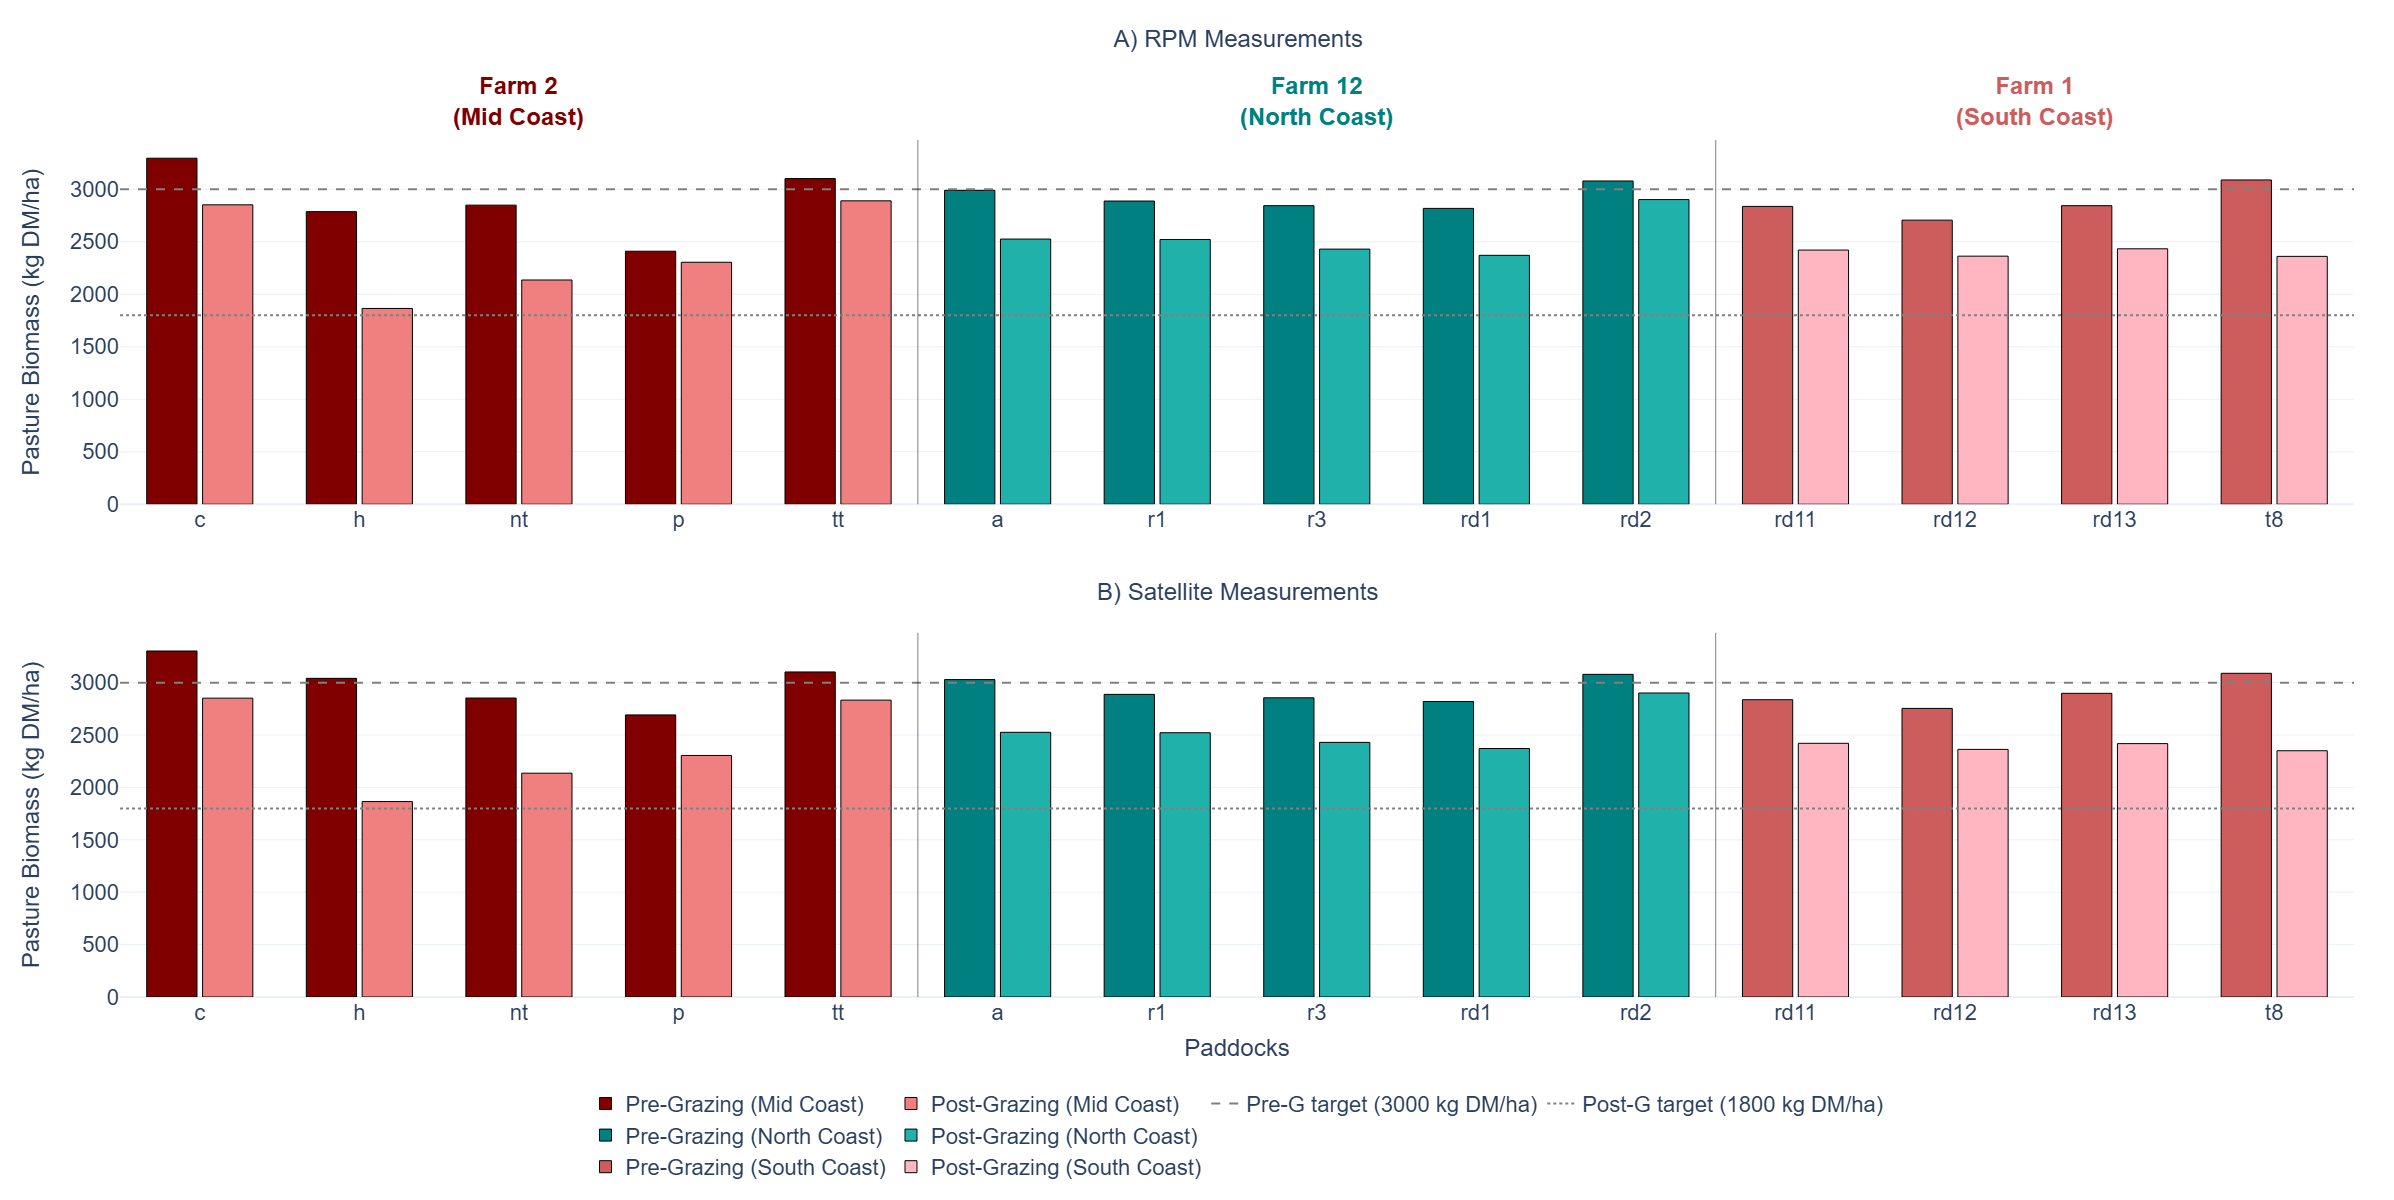

  ✓ Figure 7 saved
    Selected farms: {'Mid Coast': 'Farm 2', 'North Coast': 'Farm 12', 'South Coast': 'Farm 1'}
    Total paddocks shown: 14


In [333]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd
import numpy as np

# COLORS configuration (matching Block 12B)
COLORS = {
    'primary': 'maroon',
    'secondary': 'teal',
    'tertiary': 'indianred',
    'accent': 'pink',
    'light_primary': 'lightcoral',
    'light_secondary': 'lightseagreen',
    'light_accent': 'lightpink',
    'gray': 'gray',
    'lightgray': 'lightgray',
    'black': 'black'
}

# Load data
matched_pu = pd.read_csv(r'data/')

# Farm mapping
farm_mapping = {
    'Apps': 'Farm 1', 'Bale': 'Farm 2', 'Behrens': 'Farm 3',
    'Clarke': 'Farm 4', 'Game': 'Farm 5', 'Gould': 'Farm 6',
    'Holmes': 'Farm 7', 'Neilson': 'Farm 8', 'Nicholson': 'Farm 9',
    'Russell': 'Farm 10', 'Ryan': 'Farm 11', 'Tonge': 'Farm 12'
}

# Region mapping
region_mapping = {
    'Apps': 'South Coast', 'Bale': 'Mid Coast', 'Behrens': 'North Coast',
    'Clarke': 'North Coast', 'Game': 'South Coast', 'Gould': 'North Coast',
    'Holmes': 'South Coast', 'Neilson': 'Mid Coast', 'Nicholson': 'Mid Coast',
    'Russell': 'South Coast', 'Ryan': 'South Coast', 'Tonge': 'North Coast'
}

matched_pu['farm_id'] = matched_pu['farm_code'].map(farm_mapping)
if 'region' not in matched_pu.columns:
    matched_pu['region'] = matched_pu['farm_code'].map(region_mapping)

# Display farm mapping table
print("\n[FIGURE 7] Paddock-Level Pre/Post by Farm and Region...")
print("\n  Complete farm mapping (sorted by Farm number):")

# Count events per farm
farm_event_counts = matched_pu.groupby('farm_code').size().to_dict()

# Create list of all farms with their details
all_farms = []
for farm_code, farm_id in farm_mapping.items():
    region = region_mapping.get(farm_code, 'Unknown')
    n_events = farm_event_counts.get(farm_code, 0)
    # Extract farm number for sorting
    farm_num = int(farm_id.replace('Farm ', ''))
    all_farms.append({
        'farm_id': farm_id,
        'farm_code': farm_code,
        'region': region,
        'n_events': n_events,
        'farm_num': farm_num
    })

# Sort by farm number
all_farms = sorted(all_farms, key=lambda x: x['farm_num'])

# Display table
for farm in all_farms:
    print(f"    {farm['farm_id']:>8} → {farm['farm_code']:<15} → {farm['region']:<15} → {farm['n_events']} events")

print("\n" + "  " + "-"*70)

# Farm selection (easily changeable)
selected_farms = {
    'Mid Coast': 'Farm 2',      # Bale
    'North Coast': 'Farm 12',   # Tonge
    'South Coast': 'Farm 1'    # Russell
}

print(f"\n  Currently selected farms for Figure 7:")
for region, farm_id in selected_farms.items():
    farm_code_mapping = {v: k for k, v in farm_mapping.items()}
    farm_code = farm_code_mapping.get(farm_id, 'Unknown')
    print(f"    {region:<15} → {farm_id:<8} ({farm_code})")
print("\n  To change selection, modify the 'selected_farms' dictionary above")
print("  " + "-"*70)

# Reverse mapping: Farm ID to farm code
farm_code_mapping = {v: k for k, v in farm_mapping.items()}

# Get farm codes for selected farms
selected_farm_codes = {}
for region, farm_id in selected_farms.items():
    if farm_id in farm_code_mapping:
        selected_farm_codes[region] = farm_code_mapping[farm_id]

# Filter matches for selected farms
selected_matches = matched_pu[matched_pu['farm_code'].isin(selected_farm_codes.values())].copy()

# Calculate paddock-level averages for selected farms
paddock_data = selected_matches.groupby(['farm_code', 'pcode']).agg({
    'sent_pre_grazing': 'mean',
    'sent_post_grazing': 'mean',
    'pm_pre_grazing': 'mean',
    'pm_post_grazing': 'mean'
}).reset_index()

# Add farm IDs and regions
paddock_data['farm_id'] = paddock_data['farm_code'].map(farm_mapping)
paddock_data['region'] = paddock_data['farm_code'].map(region_mapping)
paddock_data['paddock_label'] = paddock_data['pcode']

# Sort by region and paddock
region_order = ['Mid Coast', 'North Coast', 'South Coast']
paddock_data['region_order'] = paddock_data['region'].map({r: i for i, r in enumerate(region_order)})
paddock_data = paddock_data.sort_values(['region_order', 'farm_code', 'pcode'])

# Regional colors (EXACT from Block 12B)
region_colors = {
    'Mid Coast': COLORS['primary'],
    'North Coast': COLORS['secondary'],
    'South Coast': COLORS['tertiary']
}

light_colors = {
    'Mid Coast': COLORS['light_primary'],
    'North Coast': COLORS['light_secondary'],
    'South Coast': COLORS['light_accent']
}

# Create subplots (2 rows: RPM top, Satellite bottom)
fig = make_subplots(
    rows=2, cols=1,
    subplot_titles=['A) RPM Measurements', 'B) Satellite Measurements'],
    vertical_spacing=0.15
)

# Add RPM bars (top subplot)
for region in region_order:
    region_data = paddock_data[paddock_data['region'] == region]
    if not region_data.empty:
        # RPM Pre-grazing
        fig.add_trace(go.Bar(
            name=f'Pre-Grazing ({region})',
            x=region_data['paddock_label'],
            y=region_data['pm_pre_grazing'].round().astype(int),
            marker_color=region_colors[region],
            marker_line_color='black',
            marker_line_width=1,
            offsetgroup=1,
            legendgroup='pre',
            showlegend=True
        ), row=1, col=1)

# Add RPM post-grazing bars
for region in region_order:
    region_data = paddock_data[paddock_data['region'] == region]
    if not region_data.empty:
        # RPM Post-grazing
        fig.add_trace(go.Bar(
            name=f'Post-Grazing ({region})',
            x=region_data['paddock_label'],
            y=region_data['pm_post_grazing'].round().astype(int),
            marker_color=light_colors[region],
            marker_line_color='black',
            marker_line_width=1,
            offsetgroup=2,
            legendgroup='post',
            showlegend=False
        ), row=1, col=1)

# Add Satellite bars (bottom subplot)
for region in region_order:
    region_data = paddock_data[paddock_data['region'] == region]
    if not region_data.empty:
        # Satellite Pre-grazing
        fig.add_trace(go.Bar(
            name=f'Pre-Grazing ({region})',
            x=region_data['paddock_label'],
            y=region_data['sent_pre_grazing'].round().astype(int),
            marker_color=region_colors[region],
            marker_line_color='black',
            marker_line_width=1,
            offsetgroup=1,
            legendgroup='pre',
            showlegend=False
        ), row=2, col=1)

for region in region_order:
    region_data = paddock_data[paddock_data['region'] == region]
    if not region_data.empty:
        # Satellite Post-grazing
        fig.add_trace(go.Bar(
            name=f'Post-Grazing ({region})',
            x=region_data['paddock_label'],
            y=region_data['sent_post_grazing'].round().astype(int),
            marker_color=light_colors[region],
            marker_line_color='black',
            marker_line_width=1,
            offsetgroup=2,
            legendgroup='post',
            showlegend=True
        ), row=2, col=1)

# Add benchmark lines
for row in [1, 2]:
    fig.add_hline(y=3000, line_dash="dash", line_color="gray", line_width=2, row=row, col=1)
    fig.add_hline(y=1800, line_dash="dot", line_color="gray", line_width=2, row=row, col=1)

# Add legend for target lines
fig.add_trace(go.Scatter(x=[None], y=[None], mode='lines',
                          line=dict(color='gray', dash='dash'),
                          name='Pre-G target (3000 kg DM/ha)', showlegend=True))
fig.add_trace(go.Scatter(x=[None], y=[None], mode='lines',
                          line=dict(color='gray', dash='dot'),
                          name='Post-G target (1800 kg DM/ha)', showlegend=True))

# Add farm separators
farm_boundaries = []
current_pos = -0.5

for region in region_order:
    region_data = paddock_data[paddock_data['region'] == region]
    if not region_data.empty:
        farm_paddock_count = len(region_data)
        current_pos += farm_paddock_count
        if current_pos < len(paddock_data) - 0.5:
            farm_boundaries.append(current_pos)

for boundary in farm_boundaries:
    for row in [1, 2]:
        fig.add_vline(x=boundary, line_color="black", line_width=1, opacity=0.5, row=row, col=1)

# Update layout (EXACT from Block 12B)
fig.update_layout(
    title_font_size=20,
    height=1200,
    width=1000,
    font=dict(size=16, family='Arial'),
    template="plotly_white",
    margin=dict(l=120, r=40, t=140, b=120),
    barmode='group',
    bargap=0.3,
    bargroupgap=0.1,
    legend=dict(
        orientation='h',
        yanchor='top',
        y=-0.1,
        xanchor='center',
        x=0.5,
        font=dict(size=22)
    )
)

# Update axes (EXACT from Block 12B)
for row in [1, 2]:
    fig.update_xaxes(
        title_text="Paddocks" if row == 2 else "",
        titlefont=dict(size=24),
        tickfont=dict(size=22),
        row=row, col=1
    )
    
    fig.update_yaxes(
        title_text="Pasture Biomass (kg DM/ha)",
        titlefont=dict(size=24),
        tickfont=dict(size=22),
        row=row, col=1
    )

# Add region annotations (NO BORDERS - matching Block 12B)
region_positions = {}
current_pos = 0

for region in region_order:
    region_data = paddock_data[paddock_data['region'] == region]
    if not region_data.empty:
        farm_paddock_count = len(region_data)
        region_center = current_pos + (farm_paddock_count - 1) / 2
        region_positions[region] = region_center
        current_pos += farm_paddock_count

for region, pos in region_positions.items():
    farm_id = selected_farms[region]
    fig.add_annotation(
        text=f"<b>{farm_id}<br>({region})</b>",
        x=pos,
        y=1.08,
        xref='x',
        yref='paper',
        showarrow=False,
        font=dict(size=14, color=region_colors[region]),
        bgcolor='rgba(255,255,255,0.8)'
    )

# Update subplot titles (EXACT from Block 12B)
fig.update_annotations(font_size=24, font_family='Arial')

for annotation in fig['layout']['annotations']:
    if 'A)' in annotation['text']:
        annotation['y'] = annotation['y'] + 0.10
    elif 'B)' in annotation['text']:
        annotation['y'] = annotation['y'] + 0.03

# Save figure
fig.write_image(r'data/', scale=20)
fig.show()

print("  ✓ Figure 7 saved")
print(f"    Selected farms: {selected_farms}")
print(f"    Total paddocks shown: {len(paddock_data)}")